In [1]:
%matplotlib inline

# Gaussian process models for stellar variability

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.6


When fitting exoplanets, we also need to fit for the stellar variability and Gaussian Processes (GPs) are often a good descriptive model for this variation.
[PyMC3 has support for all sorts of general GP models](https://docs.pymc.io/gp.html), but *exoplanet* includes support for scalable 1D GPs (see :ref:`gp` for more info) that can work with large datasets.
In this tutorial, we go through the process of modeling the light curve of a rotating star observed by Kepler using *exoplanet*.

First, let's download and plot the data:

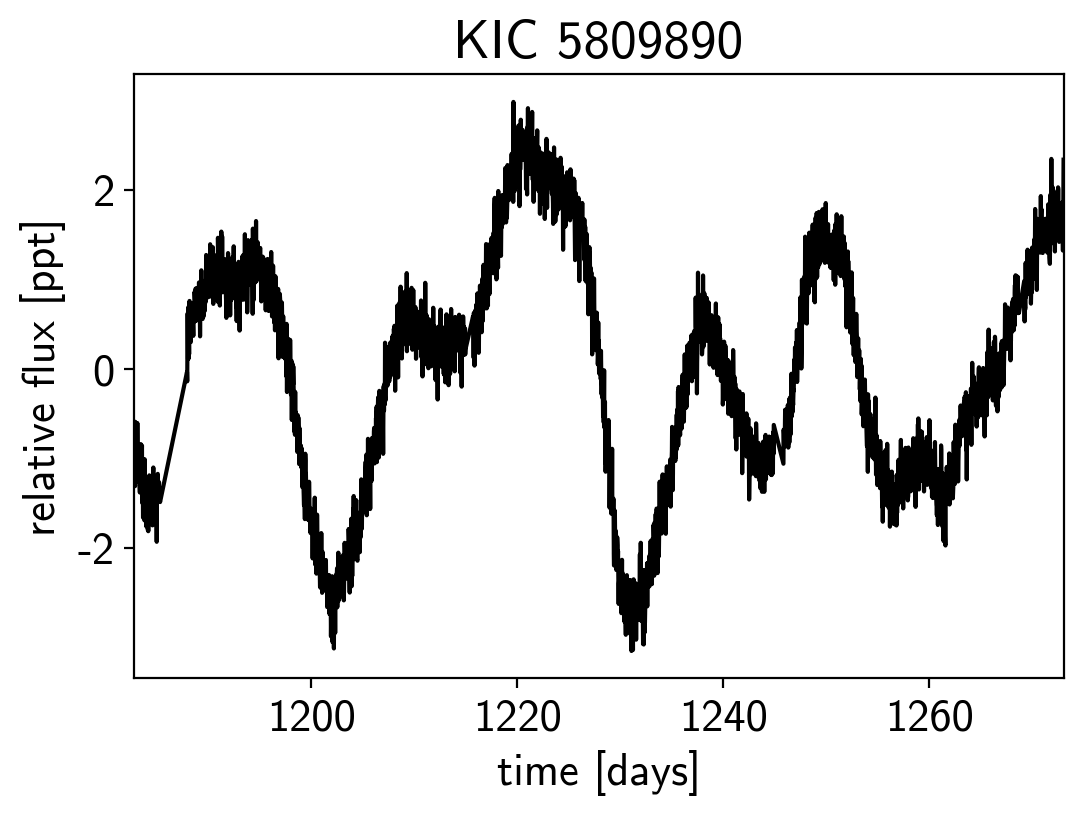

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

url = "https://archive.stsci.edu/missions/kepler/lightcurves/0058/005809890/kplr005809890-2012179063303_llc.fits"
with fits.open(url) as hdus:
    data = hdus[1].data
    
x = data["TIME"]
y = data["PDCSAP_FLUX"]
yerr = data["PDCSAP_FLUX_ERR"]
m = (data["SAP_QUALITY"] == 0) & np.isfinite(x) & np.isfinite(y)

x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
yerr = np.ascontiguousarray(yerr[m], dtype=np.float64)
mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

plt.plot(x, y, "k")
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890");

## A Gaussian process model for stellar variability

This looks like the light curve of a rotating star, and [it has been shown](https://arxiv.org/abs/1706.05459) that it is possible to model this variability by using a quasiperiodic Gaussian process.
To start with, let's get an estimate of the rotation period using the Lomb-Scargle periodogram:

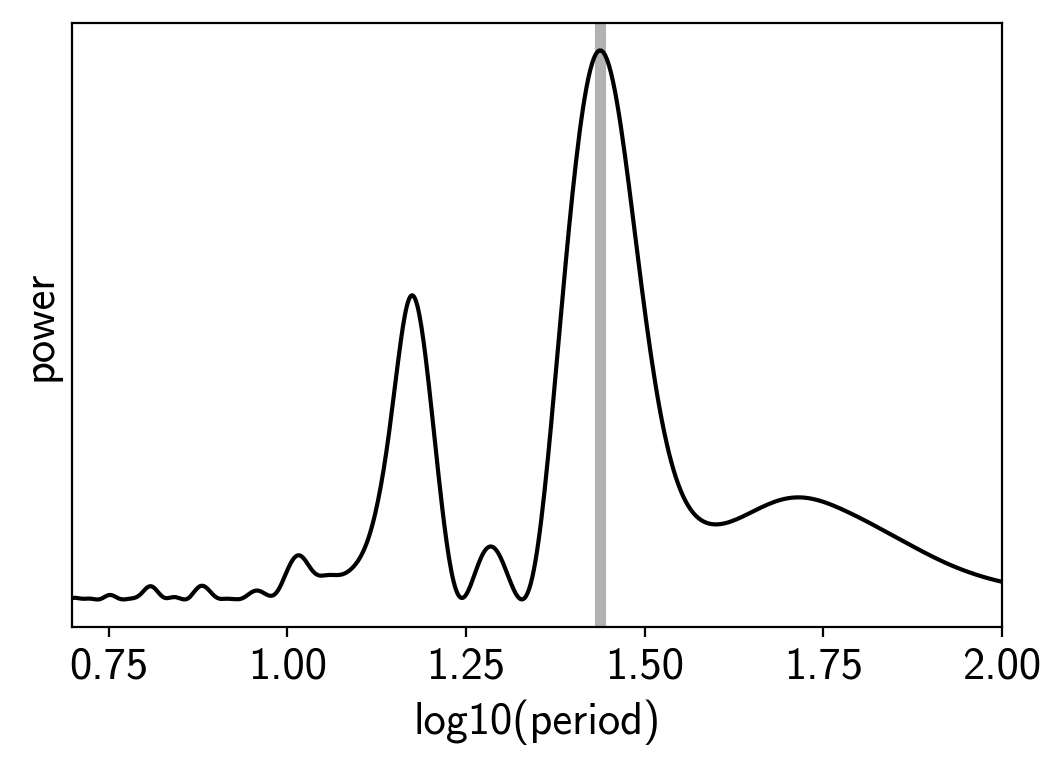

In [4]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=5.0, max_period=100.0,
    samples_per_peak=50)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(peak["period"]), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power");

Now, using this initialization, we can set up the GP model in *exoplanet*.
We'll use the :class:`exoplanet.gp.terms.RotationTerm` kernel that is a mixture of two simple harmonic oscillators with periods separated by a factor of two.
As you can see from the periodogram above, this might be a good model for this light curve and I've found that it works well in many cases.

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    
    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)
    
    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr)), sd=5.0)
    
    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
    logperiod = pm.Normal("logperiod", mu=np.log(peak["period"]), sd=5.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = pm.Uniform("mix", lower=0, upper=1.0)
    
    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))
    
    # Set up the Gaussian Process model
    kernel = xo.gp.terms.RotationTerm(
        log_amp=logamp,
        period=period,
        log_Q0=logQ0,
        log_deltaQ=logdeltaQ,
        mix=mix
    )
    gp = xo.gp.GP(kernel, x, yerr**2 + tt.exp(logs2), J=4)
    
    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    pm.Potential("loglike", gp.log_likelihood(y - mean))
    
    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())
    
    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp', 'logs2', 'mean']


message: Optimization terminated successfully.
logp: 515.8061433750984 -> 692.7159093512395


Now that we have the model set up, let's plot the maximum a posteriori model prediction.

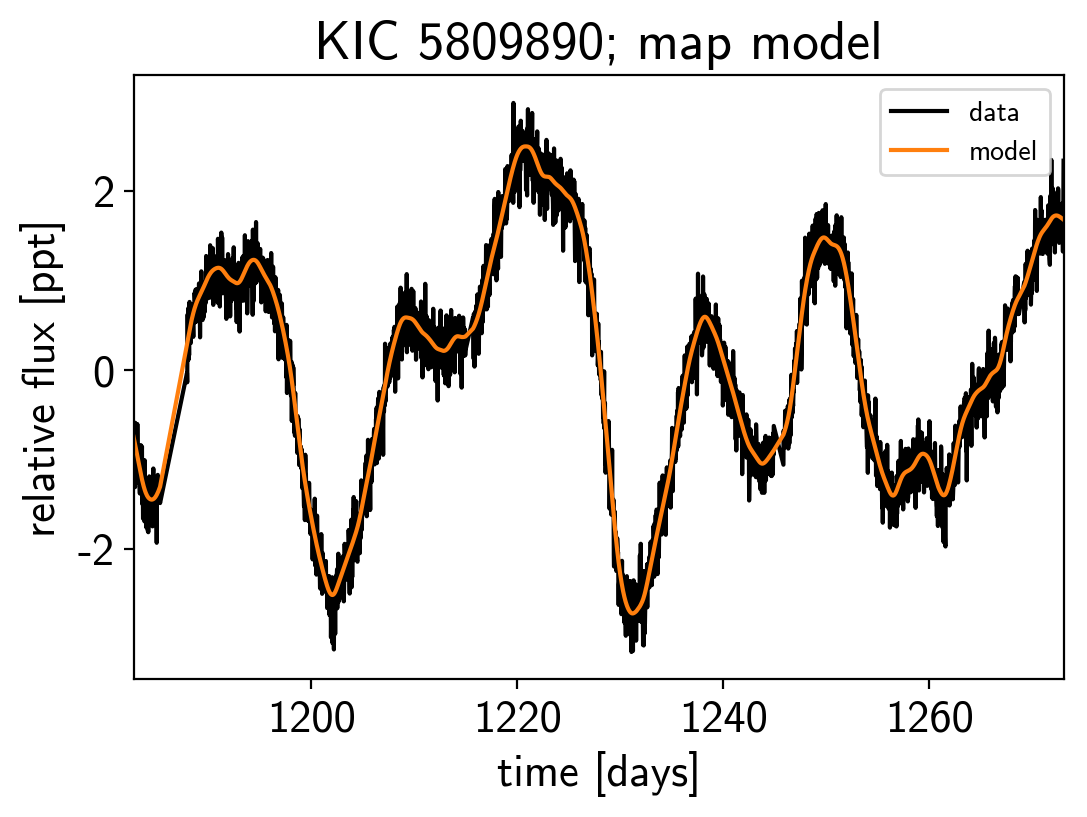

In [6]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890; map model");

That looks pretty good!
Now let's sample from the posterior using a :class:`exoplanet.PyMC3Sampler`.

In [7]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(finish=200)
with model:
    sampler.tune(tune=2000, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=2000)

Sampling 4 chains:   0%|          | 0/308 [00:00<?, ?draws/s]

Sampling 4 chains:   4%|▎         | 11/308 [00:00<00:03, 84.70draws/s]

Sampling 4 chains:   5%|▍         | 14/308 [00:00<00:08, 35.10draws/s]

Sampling 4 chains:   6%|▌         | 17/308 [00:00<00:22, 12.98draws/s]

Sampling 4 chains:   6%|▌         | 19/308 [00:01<00:20, 13.84draws/s]

Sampling 4 chains:   7%|▋         | 21/308 [00:01<00:19, 15.00draws/s]

Sampling 4 chains:   7%|▋         | 23/308 [00:01<00:33,  8.42draws/s]

Sampling 4 chains:   8%|▊         | 25/308 [00:01<00:31,  9.08draws/s]

Sampling 4 chains:   9%|▉         | 28/308 [00:02<00:27, 10.21draws/s]

Sampling 4 chains:  10%|▉         | 30/308 [00:02<00:25, 10.76draws/s]

Sampling 4 chains:  11%|█▏        | 35/308 [00:02<00:20, 13.29draws/s]

Sampling 4 chains:  13%|█▎        | 39/308 [00:02<00:16, 16.22draws/s]

Sampling 4 chains:  14%|█▎        | 42/308 [00:02<00:15, 17.32draws/s]

Sampling 4 chains:  15%|█▍        | 45/308 [00:02<00:14, 17.68draws/s]

Sampling 4 chains:  16%|█▌        | 48/308 [00:02<00:16, 16.14draws/s]

Sampling 4 chains:  16%|█▌        | 50/308 [00:03<00:17, 14.39draws/s]

Sampling 4 chains:  17%|█▋        | 52/308 [00:03<00:21, 11.95draws/s]

Sampling 4 chains:  18%|█▊        | 55/308 [00:03<00:20, 12.15draws/s]

Sampling 4 chains:  19%|█▊        | 57/308 [00:03<00:18, 13.54draws/s]

Sampling 4 chains:  19%|█▉        | 59/308 [00:03<00:18, 13.18draws/s]

Sampling 4 chains:  20%|█▉        | 61/308 [00:04<00:22, 10.93draws/s]

Sampling 4 chains:  20%|██        | 63/308 [00:04<00:29,  8.34draws/s]

Sampling 4 chains:  21%|██▏       | 66/308 [00:04<00:23, 10.47draws/s]

Sampling 4 chains:  23%|██▎       | 70/308 [00:04<00:18, 13.17draws/s]

Sampling 4 chains:  24%|██▎       | 73/308 [00:05<00:22, 10.33draws/s]

Sampling 4 chains:  24%|██▍       | 75/308 [00:05<00:23,  9.88draws/s]

Sampling 4 chains:  25%|██▌       | 78/308 [00:05<00:19, 12.09draws/s]

Sampling 4 chains:  26%|██▌       | 80/308 [00:05<00:25,  8.87draws/s]

Sampling 4 chains:  27%|██▋       | 82/308 [00:06<00:24,  9.14draws/s]

Sampling 4 chains:  28%|██▊       | 85/308 [00:06<00:19, 11.50draws/s]

Sampling 4 chains:  29%|██▉       | 89/308 [00:06<00:16, 13.65draws/s]

Sampling 4 chains:  30%|██▉       | 91/308 [00:06<00:17, 12.12draws/s]

Sampling 4 chains:  30%|███       | 93/308 [00:06<00:18, 11.32draws/s]

Sampling 4 chains:  31%|███       | 95/308 [00:06<00:16, 12.94draws/s]

Sampling 4 chains:  31%|███▏      | 97/308 [00:07<00:21,  9.99draws/s]

Sampling 4 chains:  32%|███▏      | 99/308 [00:07<00:18, 11.31draws/s]

Sampling 4 chains:  33%|███▎      | 101/308 [00:07<00:16, 12.93draws/s]

Sampling 4 chains:  33%|███▎      | 103/308 [00:07<00:14, 13.92draws/s]

Sampling 4 chains:  34%|███▍      | 105/308 [00:07<00:13, 15.08draws/s]

Sampling 4 chains:  35%|███▌      | 109/308 [00:07<00:12, 16.42draws/s]

Sampling 4 chains:  36%|███▌      | 111/308 [00:07<00:12, 16.05draws/s]

Sampling 4 chains:  37%|███▋      | 114/308 [00:08<00:10, 17.95draws/s]

Sampling 4 chains:  38%|███▊      | 116/308 [00:08<00:15, 12.37draws/s]

Sampling 4 chains:  38%|███▊      | 118/308 [00:08<00:15, 12.47draws/s]

Sampling 4 chains:  39%|███▉      | 120/308 [00:08<00:13, 13.73draws/s]

Sampling 4 chains:  40%|███▉      | 122/308 [00:09<00:20,  9.28draws/s]

Sampling 4 chains:  40%|████      | 124/308 [00:09<00:21,  8.71draws/s]

Sampling 4 chains:  41%|████      | 126/308 [00:09<00:20,  8.71draws/s]

Sampling 4 chains:  42%|████▏     | 129/308 [00:09<00:20,  8.86draws/s]

Sampling 4 chains:  43%|████▎     | 131/308 [00:09<00:18,  9.77draws/s]

Sampling 4 chains:  43%|████▎     | 133/308 [00:10<00:16, 10.91draws/s]

Sampling 4 chains:  44%|████▍     | 135/308 [00:10<00:20,  8.44draws/s]

Sampling 4 chains:  44%|████▍     | 137/308 [00:10<00:16, 10.12draws/s]

Sampling 4 chains:  45%|████▌     | 139/308 [00:10<00:16, 10.52draws/s]

Sampling 4 chains:  46%|████▌     | 141/308 [00:11<00:18,  9.08draws/s]

Sampling 4 chains:  46%|████▋     | 143/308 [00:11<00:19,  8.61draws/s]

Sampling 4 chains:  47%|████▋     | 145/308 [00:11<00:19,  8.21draws/s]

Sampling 4 chains:  48%|████▊     | 147/308 [00:11<00:16,  9.68draws/s]

Sampling 4 chains:  48%|████▊     | 149/308 [00:11<00:15, 10.58draws/s]

Sampling 4 chains:  49%|████▉     | 151/308 [00:12<00:17,  8.91draws/s]

Sampling 4 chains:  50%|█████     | 154/308 [00:12<00:13, 11.28draws/s]

Sampling 4 chains:  51%|█████     | 157/308 [00:12<00:11, 13.29draws/s]

Sampling 4 chains:  52%|█████▏    | 159/308 [00:12<00:12, 11.88draws/s]

Sampling 4 chains:  53%|█████▎    | 162/308 [00:12<00:11, 12.83draws/s]

Sampling 4 chains:  54%|█████▍    | 166/308 [00:12<00:09, 15.53draws/s]

Sampling 4 chains:  55%|█████▍    | 169/308 [00:13<00:10, 13.22draws/s]

Sampling 4 chains:  56%|█████▌    | 171/308 [00:13<00:09, 14.70draws/s]

Sampling 4 chains:  56%|█████▌    | 173/308 [00:13<00:08, 15.02draws/s]

Sampling 4 chains:  57%|█████▋    | 175/308 [00:13<00:09, 13.43draws/s]

Sampling 4 chains:  57%|█████▋    | 177/308 [00:13<00:11, 10.98draws/s]

Sampling 4 chains:  58%|█████▊    | 179/308 [00:14<00:11, 11.13draws/s]

Sampling 4 chains:  59%|█████▉    | 182/308 [00:14<00:10, 11.70draws/s]

Sampling 4 chains:  60%|██████    | 185/308 [00:14<00:10, 12.28draws/s]

Sampling 4 chains:  61%|██████    | 187/308 [00:14<00:08, 13.50draws/s]

Sampling 4 chains:  62%|██████▏   | 190/308 [00:15<00:10, 10.93draws/s]

Sampling 4 chains:  62%|██████▏   | 192/308 [00:15<00:11,  9.79draws/s]

Sampling 4 chains:  63%|██████▎   | 195/308 [00:15<00:12,  9.06draws/s]

Sampling 4 chains:  65%|██████▍   | 199/308 [00:15<00:09, 11.02draws/s]

Sampling 4 chains:  65%|██████▌   | 201/308 [00:16<00:10, 10.32draws/s]

Sampling 4 chains:  66%|██████▌   | 203/308 [00:16<00:13,  7.80draws/s]

Sampling 4 chains:  67%|██████▋   | 206/308 [00:16<00:12,  8.35draws/s]

Sampling 4 chains:  68%|██████▊   | 208/308 [00:16<00:09, 10.10draws/s]

Sampling 4 chains:  68%|██████▊   | 210/308 [00:17<00:10,  9.35draws/s]

Sampling 4 chains:  69%|██████▉   | 212/308 [00:17<00:10,  9.49draws/s]

Sampling 4 chains:  70%|██████▉   | 215/308 [00:17<00:07, 11.91draws/s]

Sampling 4 chains:  71%|███████   | 218/308 [00:17<00:06, 14.50draws/s]

Sampling 4 chains:  72%|███████▏  | 221/308 [00:17<00:06, 13.89draws/s]

Sampling 4 chains:  73%|███████▎  | 226/308 [00:17<00:04, 17.06draws/s]

Sampling 4 chains:  74%|███████▍  | 229/308 [00:18<00:05, 14.06draws/s]

Sampling 4 chains:  75%|███████▌  | 231/308 [00:18<00:06, 11.54draws/s]

Sampling 4 chains:  76%|███████▌  | 233/308 [00:18<00:08,  9.25draws/s]

Sampling 4 chains:  77%|███████▋  | 237/308 [00:18<00:06, 10.98draws/s]

Sampling 4 chains:  78%|███████▊  | 239/308 [00:19<00:07,  9.81draws/s]

Sampling 4 chains:  78%|███████▊  | 241/308 [00:19<00:06, 10.53draws/s]

Sampling 4 chains:  79%|███████▉  | 244/308 [00:19<00:04, 13.02draws/s]

Sampling 4 chains:  80%|███████▉  | 246/308 [00:19<00:05, 11.11draws/s]

Sampling 4 chains:  81%|████████  | 248/308 [00:20<00:07,  8.13draws/s]

Sampling 4 chains:  81%|████████  | 250/308 [00:20<00:06,  9.55draws/s]

Sampling 4 chains:  83%|████████▎ | 255/308 [00:20<00:04, 11.99draws/s]

Sampling 4 chains:  83%|████████▎ | 257/308 [00:20<00:03, 13.04draws/s]

Sampling 4 chains:  84%|████████▍ | 259/308 [00:20<00:05,  8.96draws/s]

Sampling 4 chains:  85%|████████▌ | 263/308 [00:21<00:03, 11.37draws/s]

Sampling 4 chains:  87%|████████▋ | 267/308 [00:21<00:02, 14.32draws/s]

Sampling 4 chains:  88%|████████▊ | 270/308 [00:21<00:02, 13.23draws/s]

Sampling 4 chains:  89%|████████▊ | 273/308 [00:21<00:02, 12.87draws/s]

Sampling 4 chains:  89%|████████▉ | 275/308 [00:21<00:02, 13.64draws/s]

Sampling 4 chains:  91%|█████████ | 279/308 [00:21<00:01, 16.99draws/s]

Sampling 4 chains:  92%|█████████▏| 282/308 [00:22<00:01, 18.79draws/s]

Sampling 4 chains:  93%|█████████▎| 285/308 [00:22<00:01, 15.02draws/s]

Sampling 4 chains:  94%|█████████▎| 288/308 [00:22<00:01, 15.95draws/s]

Sampling 4 chains:  94%|█████████▍| 290/308 [00:22<00:01, 12.38draws/s]

Sampling 4 chains:  95%|█████████▍| 292/308 [00:23<00:01,  8.62draws/s]

Sampling 4 chains:  95%|█████████▌| 294/308 [00:23<00:01,  7.87draws/s]

Sampling 4 chains:  96%|█████████▌| 296/308 [00:23<00:01,  8.66draws/s]

Sampling 4 chains:  97%|█████████▋| 299/308 [00:23<00:00, 10.10draws/s]

Sampling 4 chains:  98%|█████████▊| 301/308 [00:24<00:00,  7.55draws/s]

Sampling 4 chains:  98%|█████████▊| 303/308 [00:24<00:00,  5.78draws/s]

Sampling 4 chains:  99%|█████████▉| 305/308 [00:24<00:00,  6.56draws/s]

Sampling 4 chains:  99%|█████████▉| 306/308 [00:25<00:00,  6.92draws/s]

Sampling 4 chains: 100%|█████████▉| 307/308 [00:25<00:00,  3.91draws/s]

Sampling 4 chains: 100%|██████████| 308/308 [00:25<00:00,  3.62draws/s]

Sampling 4 chains:   0%|          | 0/108 [00:00<?, ?draws/s]

Sampling 4 chains:  10%|█         | 11/108 [00:00<00:01, 58.48draws/s]

Sampling 4 chains:  14%|█▍        | 15/108 [00:00<00:01, 50.64draws/s]

Sampling 4 chains:  17%|█▋        | 18/108 [00:00<00:02, 38.68draws/s]

Sampling 4 chains:  19%|█▉        | 21/108 [00:00<00:02, 29.90draws/s]

Sampling 4 chains:  22%|██▏       | 24/108 [00:00<00:03, 25.03draws/s]

Sampling 4 chains:  25%|██▌       | 27/108 [00:00<00:03, 23.70draws/s]

Sampling 4 chains:  29%|██▊       | 31/108 [00:01<00:03, 24.65draws/s]

Sampling 4 chains:  31%|███▏      | 34/108 [00:01<00:04, 16.53draws/s]

Sampling 4 chains:  33%|███▎      | 36/108 [00:01<00:05, 14.02draws/s]

Sampling 4 chains:  36%|███▌      | 39/108 [00:01<00:04, 16.67draws/s]

Sampling 4 chains:  39%|███▉      | 42/108 [00:01<00:04, 14.22draws/s]

Sampling 4 chains:  44%|████▎     | 47/108 [00:02<00:03, 17.68draws/s]

Sampling 4 chains:  46%|████▋     | 50/108 [00:02<00:03, 19.26draws/s]

Sampling 4 chains:  49%|████▉     | 53/108 [00:02<00:02, 21.28draws/s]

Sampling 4 chains:  52%|█████▏    | 56/108 [00:02<00:02, 18.41draws/s]

Sampling 4 chains:  55%|█████▍    | 59/108 [00:02<00:03, 13.12draws/s]

Sampling 4 chains:  59%|█████▉    | 64/108 [00:03<00:02, 16.16draws/s]

Sampling 4 chains:  62%|██████▏   | 67/108 [00:03<00:02, 15.01draws/s]

Sampling 4 chains:  65%|██████▍   | 70/108 [00:03<00:03, 11.59draws/s]

Sampling 4 chains:  67%|██████▋   | 72/108 [00:03<00:02, 12.86draws/s]

Sampling 4 chains:  70%|███████   | 76/108 [00:03<00:02, 15.39draws/s]

Sampling 4 chains:  73%|███████▎  | 79/108 [00:04<00:02, 14.47draws/s]

Sampling 4 chains:  77%|███████▋  | 83/108 [00:04<00:01, 14.22draws/s]

Sampling 4 chains:  79%|███████▊  | 85/108 [00:04<00:01, 14.85draws/s]

Sampling 4 chains:  81%|████████  | 87/108 [00:04<00:01, 13.09draws/s]

Sampling 4 chains:  82%|████████▏ | 89/108 [00:04<00:01, 12.36draws/s]

Sampling 4 chains:  84%|████████▍ | 91/108 [00:05<00:01, 12.72draws/s]

Sampling 4 chains:  88%|████████▊ | 95/108 [00:05<00:00, 14.58draws/s]

Sampling 4 chains:  91%|█████████ | 98/108 [00:05<00:00, 14.59draws/s]

Sampling 4 chains:  93%|█████████▎| 100/108 [00:05<00:00, 15.05draws/s]

Sampling 4 chains:  95%|█████████▌| 103/108 [00:05<00:00, 16.59draws/s]

Sampling 4 chains:  97%|█████████▋| 105/108 [00:05<00:00, 13.63draws/s]

Sampling 4 chains: 100%|██████████| 108/108 [00:06<00:00, 15.66draws/s]

Sampling 4 chains:   0%|          | 0/208 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 7/208 [00:00<00:02, 67.45draws/s]

Sampling 4 chains:   7%|▋         | 15/208 [00:00<00:02, 68.54draws/s]

Sampling 4 chains:  11%|█         | 22/208 [00:00<00:02, 64.94draws/s]

Sampling 4 chains:  14%|█▍        | 29/208 [00:00<00:02, 65.36draws/s]

Sampling 4 chains:  18%|█▊        | 38/208 [00:00<00:02, 70.78draws/s]

Sampling 4 chains:  23%|██▎       | 47/208 [00:00<00:02, 74.79draws/s]

Sampling 4 chains:  26%|██▋       | 55/208 [00:00<00:02, 75.31draws/s]

Sampling 4 chains:  30%|███       | 63/208 [00:00<00:02, 70.26draws/s]

Sampling 4 chains:  34%|███▎      | 70/208 [00:00<00:01, 69.50draws/s]

Sampling 4 chains:  38%|███▊      | 79/208 [00:01<00:01, 73.96draws/s]

Sampling 4 chains:  43%|████▎     | 89/208 [00:01<00:01, 76.64draws/s]

Sampling 4 chains:  47%|████▋     | 97/208 [00:01<00:01, 69.79draws/s]

Sampling 4 chains:  51%|█████▏    | 107/208 [00:01<00:01, 73.04draws/s]

Sampling 4 chains:  56%|█████▌    | 116/208 [00:01<00:01, 74.70draws/s]

Sampling 4 chains:  60%|█████▉    | 124/208 [00:01<00:01, 62.06draws/s]

Sampling 4 chains:  63%|██████▎   | 131/208 [00:01<00:01, 57.27draws/s]

Sampling 4 chains:  66%|██████▋   | 138/208 [00:02<00:01, 55.18draws/s]

Sampling 4 chains:  70%|███████   | 146/208 [00:02<00:01, 57.45draws/s]

Sampling 4 chains:  75%|███████▍  | 155/208 [00:02<00:00, 63.31draws/s]

Sampling 4 chains:  78%|███████▊  | 163/208 [00:02<00:00, 67.29draws/s]

Sampling 4 chains:  83%|████████▎ | 172/208 [00:02<00:00, 70.77draws/s]

Sampling 4 chains:  87%|████████▋ | 180/208 [00:02<00:00, 69.04draws/s]

Sampling 4 chains:  90%|█████████ | 188/208 [00:02<00:00, 68.05draws/s]

Sampling 4 chains:  94%|█████████▍| 195/208 [00:02<00:00, 60.72draws/s]

Sampling 4 chains:  97%|█████████▋| 202/208 [00:03<00:00, 51.79draws/s]

Sampling 4 chains: 100%|██████████| 208/208 [00:03<00:00, 34.27draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 9/408 [00:00<00:04, 80.35draws/s]

Sampling 4 chains:   4%|▍         | 16/408 [00:00<00:05, 75.95draws/s]

Sampling 4 chains:   6%|▌         | 24/408 [00:00<00:05, 74.99draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:00<00:04, 76.67draws/s]

Sampling 4 chains:  11%|█         | 45/408 [00:00<00:04, 85.78draws/s]

Sampling 4 chains:  13%|█▎        | 53/408 [00:00<00:04, 83.39draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:00<00:04, 82.04draws/s]

Sampling 4 chains:  17%|█▋        | 69/408 [00:00<00:04, 76.44draws/s]

Sampling 4 chains:  19%|█▉        | 77/408 [00:01<00:04, 67.07draws/s]

Sampling 4 chains:  21%|██        | 84/408 [00:01<00:04, 67.02draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:01<00:04, 63.63draws/s]

Sampling 4 chains:  24%|██▍       | 98/408 [00:01<00:05, 61.31draws/s]

Sampling 4 chains:  26%|██▌       | 106/408 [00:01<00:04, 63.62draws/s]

Sampling 4 chains:  28%|██▊       | 113/408 [00:01<00:05, 55.69draws/s]

Sampling 4 chains:  29%|██▉       | 119/408 [00:01<00:05, 52.81draws/s]

Sampling 4 chains:  31%|███       | 125/408 [00:01<00:05, 51.60draws/s]

Sampling 4 chains:  32%|███▏      | 131/408 [00:02<00:05, 50.47draws/s]

Sampling 4 chains:  34%|███▍      | 138/408 [00:02<00:05, 53.73draws/s]

Sampling 4 chains:  35%|███▌      | 144/408 [00:02<00:05, 50.68draws/s]

Sampling 4 chains:  37%|███▋      | 150/408 [00:02<00:05, 50.21draws/s]

Sampling 4 chains:  38%|███▊      | 156/408 [00:02<00:04, 51.92draws/s]

Sampling 4 chains:  40%|███▉      | 163/408 [00:02<00:04, 53.77draws/s]

Sampling 4 chains:  41%|████▏     | 169/408 [00:02<00:04, 52.28draws/s]

Sampling 4 chains:  43%|████▎     | 177/408 [00:02<00:03, 58.00draws/s]

Sampling 4 chains:  45%|████▌     | 185/408 [00:02<00:03, 57.37draws/s]

Sampling 4 chains:  47%|████▋     | 191/408 [00:03<00:04, 53.68draws/s]

Sampling 4 chains:  49%|████▉     | 200/408 [00:03<00:03, 60.64draws/s]

Sampling 4 chains:  51%|█████     | 207/408 [00:03<00:03, 60.65draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [00:03<00:03, 56.78draws/s]

Sampling 4 chains:  54%|█████▍    | 220/408 [00:03<00:03, 53.40draws/s]

Sampling 4 chains:  56%|█████▌    | 228/408 [00:03<00:03, 57.35draws/s]

Sampling 4 chains:  58%|█████▊    | 238/408 [00:03<00:02, 64.27draws/s]

Sampling 4 chains:  60%|██████    | 245/408 [00:03<00:02, 65.82draws/s]

Sampling 4 chains:  62%|██████▏   | 252/408 [00:04<00:02, 62.82draws/s]

Sampling 4 chains:  64%|██████▎   | 260/408 [00:04<00:02, 63.67draws/s]

Sampling 4 chains:  66%|██████▌   | 269/408 [00:04<00:02, 68.94draws/s]

Sampling 4 chains:  68%|██████▊   | 277/408 [00:04<00:02, 65.33draws/s]

Sampling 4 chains:  70%|███████   | 286/408 [00:04<00:01, 69.53draws/s]

Sampling 4 chains:  72%|███████▏  | 294/408 [00:04<00:01, 72.21draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [00:04<00:01, 78.48draws/s]

Sampling 4 chains:  77%|███████▋  | 314/408 [00:04<00:01, 83.66draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [00:04<00:01, 73.77draws/s]

Sampling 4 chains:  81%|████████  | 331/408 [00:05<00:01, 73.98draws/s]

Sampling 4 chains:  83%|████████▎ | 339/408 [00:05<00:01, 66.69draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [00:05<00:00, 63.98draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [00:05<00:00, 71.10draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [00:05<00:00, 62.75draws/s]

Sampling 4 chains:  91%|█████████ | 372/408 [00:05<00:00, 56.34draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [00:05<00:00, 54.02draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:06<00:00, 54.47draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [00:06<00:00, 53.76draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [00:06<00:00, 59.38draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:06<00:00, 52.70draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:06<00:00, 62.43draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 7/808 [00:00<00:12, 66.11draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:00<00:11, 69.08draws/s]

Sampling 4 chains:   3%|▎         | 22/808 [00:00<00:11, 68.23draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:00<00:10, 71.79draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:00<00:11, 69.77draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:00<00:11, 64.88draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:00<00:10, 70.22draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:00<00:10, 71.66draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:00<00:10, 69.29draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:01<00:09, 74.25draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:01<00:09, 73.02draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:01<00:09, 78.21draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:01<00:08, 79.90draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:01<00:09, 72.95draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:01<00:09, 70.59draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:01<00:09, 73.45draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:02<00:11, 60.27draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:02<00:11, 59.34draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:02<00:11, 58.74draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:02<00:10, 61.25draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:02<00:09, 64.50draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [00:02<00:10, 61.65draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:02<00:09, 63.10draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:02<00:10, 60.78draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:02<00:09, 64.91draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:03<00:09, 65.87draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [00:03<00:09, 64.15draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [00:03<00:09, 63.13draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:03<00:08, 68.07draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:03<00:07, 75.28draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:03<00:07, 77.00draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [00:03<00:07, 76.11draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:03<00:06, 77.14draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:03<00:06, 83.73draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:04<00:06, 85.05draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [00:04<00:05, 87.25draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:04<00:05, 89.86draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [00:04<00:05, 91.90draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:04<00:05, 88.25draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [00:04<00:05, 89.35draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [00:04<00:04, 91.74draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [00:04<00:05, 76.60draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [00:05<00:05, 77.25draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [00:05<00:05, 76.74draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [00:05<00:05, 73.46draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [00:05<00:05, 74.62draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [00:05<00:05, 75.96draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [00:05<00:04, 79.46draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [00:05<00:04, 79.93draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [00:05<00:04, 78.32draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [00:05<00:04, 76.56draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [00:06<00:04, 74.35draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [00:06<00:04, 80.99draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [00:06<00:04, 85.24draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [00:06<00:04, 82.06draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [00:06<00:04, 79.41draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [00:06<00:03, 78.62draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [00:06<00:04, 67.17draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [00:06<00:04, 72.17draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [00:06<00:04, 69.83draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [00:07<00:03, 74.28draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [00:07<00:03, 74.78draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [00:07<00:03, 79.13draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [00:07<00:02, 85.85draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [00:07<00:03, 78.99draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [00:07<00:03, 69.84draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [00:07<00:03, 70.47draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [00:07<00:02, 71.51draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [00:08<00:02, 72.10draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [00:08<00:02, 75.97draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [00:08<00:02, 75.23draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [00:08<00:02, 76.06draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [00:08<00:02, 79.36draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [00:08<00:02, 79.05draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [00:08<00:01, 79.15draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [00:08<00:01, 79.77draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [00:08<00:01, 81.20draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [00:09<00:01, 85.58draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [00:09<00:01, 84.95draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [00:09<00:01, 83.89draws/s]

Sampling 4 chains:  88%|████████▊ | 710/808 [00:09<00:01, 80.46draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [00:09<00:01, 76.84draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [00:09<00:01, 77.19draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [00:09<00:00, 76.33draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [00:09<00:00, 70.19draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [00:09<00:00, 68.76draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [00:10<00:00, 67.88draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [00:10<00:00, 67.95draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [00:10<00:00, 70.60draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [00:10<00:00, 70.07draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [00:10<00:00, 64.99draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [00:10<00:00, 51.20draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [00:10<00:00, 42.69draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:11<00:00, 71.65draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:00<00:19, 83.87draws/s]

Sampling 4 chains:   1%|          | 15/1608 [00:00<00:22, 71.72draws/s]

Sampling 4 chains:   1%|▏         | 22/1608 [00:00<00:23, 68.68draws/s]

Sampling 4 chains:   2%|▏         | 30/1608 [00:00<00:22, 70.29draws/s]

Sampling 4 chains:   2%|▏         | 37/1608 [00:00<00:23, 66.88draws/s]

Sampling 4 chains:   3%|▎         | 43/1608 [00:00<00:25, 61.75draws/s]

Sampling 4 chains:   3%|▎         | 51/1608 [00:00<00:24, 63.93draws/s]

Sampling 4 chains:   4%|▎         | 57/1608 [00:00<00:27, 57.22draws/s]

Sampling 4 chains:   4%|▍         | 64/1608 [00:01<00:25, 59.95draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:01<00:29, 52.43draws/s]

Sampling 4 chains:   5%|▍         | 77/1608 [00:01<00:28, 54.11draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:01<00:28, 54.22draws/s]

Sampling 4 chains:   6%|▌         | 90/1608 [00:01<00:26, 56.61draws/s]

Sampling 4 chains:   6%|▌         | 99/1608 [00:01<00:25, 59.49draws/s]

Sampling 4 chains:   7%|▋         | 108/1608 [00:01<00:23, 64.35draws/s]

Sampling 4 chains:   7%|▋         | 115/1608 [00:01<00:25, 59.69draws/s]

Sampling 4 chains:   8%|▊         | 122/1608 [00:02<00:24, 61.01draws/s]

Sampling 4 chains:   8%|▊         | 129/1608 [00:02<00:27, 54.55draws/s]

Sampling 4 chains:   8%|▊         | 135/1608 [00:02<00:28, 52.29draws/s]

Sampling 4 chains:   9%|▉         | 143/1608 [00:02<00:26, 54.70draws/s]

Sampling 4 chains:   9%|▉         | 149/1608 [00:02<00:27, 52.73draws/s]

Sampling 4 chains:  10%|▉         | 155/1608 [00:02<00:27, 53.72draws/s]

Sampling 4 chains:  10%|█         | 161/1608 [00:02<00:26, 54.63draws/s]

Sampling 4 chains:  11%|█         | 169/1608 [00:02<00:24, 57.81draws/s]

Sampling 4 chains:  11%|█         | 176/1608 [00:02<00:24, 57.90draws/s]

Sampling 4 chains:  11%|█▏        | 183/1608 [00:03<00:24, 57.67draws/s]

Sampling 4 chains:  12%|█▏        | 191/1608 [00:03<00:22, 62.50draws/s]

Sampling 4 chains:  12%|█▏        | 198/1608 [00:03<00:25, 56.23draws/s]

Sampling 4 chains:  13%|█▎        | 205/1608 [00:03<00:24, 56.36draws/s]

Sampling 4 chains:  13%|█▎        | 211/1608 [00:03<00:24, 57.15draws/s]

Sampling 4 chains:  13%|█▎        | 217/1608 [00:03<00:31, 44.72draws/s]

Sampling 4 chains:  14%|█▍        | 222/1608 [00:03<00:31, 44.14draws/s]

Sampling 4 chains:  14%|█▍        | 228/1608 [00:04<00:29, 47.15draws/s]

Sampling 4 chains:  15%|█▍        | 234/1608 [00:04<00:27, 49.63draws/s]

Sampling 4 chains:  15%|█▍        | 241/1608 [00:04<00:25, 52.79draws/s]

Sampling 4 chains:  15%|█▌        | 247/1608 [00:04<00:25, 53.46draws/s]

Sampling 4 chains:  16%|█▌        | 254/1608 [00:04<00:24, 55.82draws/s]

Sampling 4 chains:  16%|█▌        | 260/1608 [00:04<00:23, 56.45draws/s]

Sampling 4 chains:  17%|█▋        | 267/1608 [00:04<00:25, 51.74draws/s]

Sampling 4 chains:  17%|█▋        | 274/1608 [00:04<00:24, 55.18draws/s]

Sampling 4 chains:  17%|█▋        | 280/1608 [00:04<00:26, 50.47draws/s]

Sampling 4 chains:  18%|█▊        | 288/1608 [00:05<00:23, 56.27draws/s]

Sampling 4 chains:  19%|█▊        | 299/1608 [00:05<00:20, 63.68draws/s]

Sampling 4 chains:  19%|█▉        | 309/1608 [00:05<00:19, 67.18draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [00:05<00:18, 70.53draws/s]

Sampling 4 chains:  20%|██        | 325/1608 [00:05<00:19, 64.87draws/s]

Sampling 4 chains:  21%|██        | 332/1608 [00:05<00:21, 58.07draws/s]

Sampling 4 chains:  21%|██        | 339/1608 [00:05<00:26, 48.44draws/s]

Sampling 4 chains:  22%|██▏       | 348/1608 [00:06<00:23, 54.74draws/s]

Sampling 4 chains:  22%|██▏       | 355/1608 [00:06<00:23, 54.36draws/s]

Sampling 4 chains:  22%|██▏       | 361/1608 [00:06<00:22, 55.06draws/s]

Sampling 4 chains:  23%|██▎       | 367/1608 [00:06<00:24, 50.87draws/s]

Sampling 4 chains:  23%|██▎       | 373/1608 [00:06<00:23, 51.56draws/s]

Sampling 4 chains:  24%|██▎       | 380/1608 [00:06<00:22, 54.45draws/s]

Sampling 4 chains:  24%|██▍       | 388/1608 [00:06<00:20, 59.98draws/s]

Sampling 4 chains:  25%|██▍       | 397/1608 [00:06<00:19, 63.47draws/s]

Sampling 4 chains:  25%|██▌       | 405/1608 [00:06<00:17, 66.94draws/s]

Sampling 4 chains:  26%|██▌       | 415/1608 [00:07<00:16, 74.06draws/s]

Sampling 4 chains:  26%|██▋       | 425/1608 [00:07<00:14, 79.86draws/s]

Sampling 4 chains:  27%|██▋       | 434/1608 [00:07<00:14, 79.17draws/s]

Sampling 4 chains:  28%|██▊       | 443/1608 [00:07<00:14, 80.92draws/s]

Sampling 4 chains:  28%|██▊       | 452/1608 [00:07<00:14, 78.43draws/s]

Sampling 4 chains:  29%|██▊       | 462/1608 [00:07<00:13, 83.63draws/s]

Sampling 4 chains:  29%|██▉       | 471/1608 [00:07<00:15, 72.63draws/s]

Sampling 4 chains:  30%|██▉       | 479/1608 [00:07<00:16, 70.09draws/s]

Sampling 4 chains:  30%|███       | 487/1608 [00:08<00:17, 62.46draws/s]

Sampling 4 chains:  31%|███       | 494/1608 [00:08<00:17, 61.93draws/s]

Sampling 4 chains:  31%|███       | 501/1608 [00:08<00:17, 62.47draws/s]

Sampling 4 chains:  32%|███▏      | 508/1608 [00:08<00:17, 61.20draws/s]

Sampling 4 chains:  32%|███▏      | 516/1608 [00:08<00:16, 65.01draws/s]

Sampling 4 chains:  33%|███▎      | 523/1608 [00:08<00:16, 66.02draws/s]

Sampling 4 chains:  33%|███▎      | 530/1608 [00:08<00:16, 67.10draws/s]

Sampling 4 chains:  33%|███▎      | 538/1608 [00:08<00:15, 69.91draws/s]

Sampling 4 chains:  34%|███▍      | 546/1608 [00:08<00:15, 70.40draws/s]

Sampling 4 chains:  35%|███▍      | 555/1608 [00:09<00:14, 74.50draws/s]

Sampling 4 chains:  35%|███▌      | 566/1608 [00:09<00:13, 78.00draws/s]

Sampling 4 chains:  36%|███▌      | 574/1608 [00:09<00:13, 75.60draws/s]

Sampling 4 chains:  36%|███▌      | 582/1608 [00:09<00:14, 72.67draws/s]

Sampling 4 chains:  37%|███▋      | 590/1608 [00:09<00:14, 70.15draws/s]

Sampling 4 chains:  37%|███▋      | 601/1608 [00:09<00:12, 78.17draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [00:09<00:11, 85.15draws/s]

Sampling 4 chains:  39%|███▊      | 622/1608 [00:09<00:11, 88.44draws/s]

Sampling 4 chains:  39%|███▉      | 632/1608 [00:09<00:11, 88.25draws/s]

Sampling 4 chains:  40%|███▉      | 642/1608 [00:10<00:10, 90.93draws/s]

Sampling 4 chains:  41%|████      | 652/1608 [00:10<00:10, 92.84draws/s]

Sampling 4 chains:  41%|████      | 662/1608 [00:10<00:11, 80.46draws/s]

Sampling 4 chains:  42%|████▏     | 671/1608 [00:10<00:12, 77.72draws/s]

Sampling 4 chains:  42%|████▏     | 680/1608 [00:10<00:12, 76.25draws/s]

Sampling 4 chains:  43%|████▎     | 688/1608 [00:10<00:12, 75.57draws/s]

Sampling 4 chains:  43%|████▎     | 696/1608 [00:10<00:12, 74.90draws/s]

Sampling 4 chains:  44%|████▍     | 705/1608 [00:10<00:11, 75.95draws/s]

Sampling 4 chains:  44%|████▍     | 713/1608 [00:11<00:12, 70.77draws/s]

Sampling 4 chains:  45%|████▍     | 721/1608 [00:11<00:13, 64.06draws/s]

Sampling 4 chains:  45%|████▌     | 728/1608 [00:11<00:14, 62.04draws/s]

Sampling 4 chains:  46%|████▌     | 735/1608 [00:11<00:14, 58.49draws/s]

Sampling 4 chains:  46%|████▋     | 745/1608 [00:11<00:13, 63.84draws/s]

Sampling 4 chains:  47%|████▋     | 754/1608 [00:11<00:12, 66.02draws/s]

Sampling 4 chains:  48%|████▊     | 765/1608 [00:11<00:11, 74.58draws/s]

Sampling 4 chains:  48%|████▊     | 775/1608 [00:11<00:10, 76.30draws/s]

Sampling 4 chains:  49%|████▊     | 783/1608 [00:12<00:10, 75.33draws/s]

Sampling 4 chains:  49%|████▉     | 791/1608 [00:12<00:11, 73.81draws/s]

Sampling 4 chains:  50%|████▉     | 799/1608 [00:12<00:12, 67.25draws/s]

Sampling 4 chains:  50%|█████     | 807/1608 [00:12<00:11, 70.00draws/s]

Sampling 4 chains:  51%|█████     | 815/1608 [00:12<00:10, 72.49draws/s]

Sampling 4 chains:  51%|█████     | 823/1608 [00:12<00:11, 67.49draws/s]

Sampling 4 chains:  52%|█████▏    | 831/1608 [00:12<00:11, 70.36draws/s]

Sampling 4 chains:  52%|█████▏    | 842/1608 [00:12<00:09, 77.56draws/s]

Sampling 4 chains:  53%|█████▎    | 853/1608 [00:12<00:09, 82.22draws/s]

Sampling 4 chains:  54%|█████▎    | 863/1608 [00:13<00:08, 86.33draws/s]

Sampling 4 chains:  54%|█████▍    | 872/1608 [00:13<00:09, 78.76draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [00:13<00:09, 72.89draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [00:13<00:09, 73.03draws/s]

Sampling 4 chains:  56%|█████▌    | 897/1608 [00:13<00:10, 67.08draws/s]

Sampling 4 chains:  56%|█████▌    | 904/1608 [00:13<00:10, 67.39draws/s]

Sampling 4 chains:  57%|█████▋    | 913/1608 [00:13<00:09, 71.60draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [00:13<00:08, 76.86draws/s]

Sampling 4 chains:  58%|█████▊    | 934/1608 [00:14<00:09, 74.54draws/s]

Sampling 4 chains:  59%|█████▊    | 942/1608 [00:14<00:08, 75.13draws/s]

Sampling 4 chains:  59%|█████▉    | 950/1608 [00:14<00:09, 68.48draws/s]

Sampling 4 chains:  60%|█████▉    | 958/1608 [00:14<00:09, 71.23draws/s]

Sampling 4 chains:  60%|██████    | 966/1608 [00:14<00:10, 61.04draws/s]

Sampling 4 chains:  61%|██████    | 973/1608 [00:14<00:10, 60.03draws/s]

Sampling 4 chains:  61%|██████    | 980/1608 [00:14<00:10, 59.05draws/s]

Sampling 4 chains:  61%|██████▏   | 987/1608 [00:14<00:10, 56.69draws/s]

Sampling 4 chains:  62%|██████▏   | 995/1608 [00:15<00:09, 61.46draws/s]

Sampling 4 chains:  62%|██████▏   | 1003/1608 [00:15<00:09, 61.90draws/s]

Sampling 4 chains:  63%|██████▎   | 1014/1608 [00:15<00:08, 69.12draws/s]

Sampling 4 chains:  64%|██████▎   | 1022/1608 [00:15<00:09, 64.74draws/s]

Sampling 4 chains:  64%|██████▍   | 1030/1608 [00:15<00:08, 68.00draws/s]

Sampling 4 chains:  65%|██████▍   | 1038/1608 [00:15<00:08, 67.56draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [00:15<00:08, 68.47draws/s]

Sampling 4 chains:  65%|██████▌   | 1053/1608 [00:15<00:08, 67.98draws/s]

Sampling 4 chains:  66%|██████▌   | 1060/1608 [00:15<00:08, 66.95draws/s]

Sampling 4 chains:  66%|██████▋   | 1067/1608 [00:16<00:08, 63.67draws/s]

Sampling 4 chains:  67%|██████▋   | 1074/1608 [00:16<00:08, 64.86draws/s]

Sampling 4 chains:  67%|██████▋   | 1083/1608 [00:16<00:07, 67.83draws/s]

Sampling 4 chains:  68%|██████▊   | 1092/1608 [00:16<00:07, 69.84draws/s]

Sampling 4 chains:  68%|██████▊   | 1100/1608 [00:16<00:08, 61.09draws/s]

Sampling 4 chains:  69%|██████▉   | 1110/1608 [00:16<00:07, 66.15draws/s]

Sampling 4 chains:  70%|██████▉   | 1119/1608 [00:16<00:07, 69.39draws/s]

Sampling 4 chains:  70%|███████   | 1128/1608 [00:16<00:06, 73.38draws/s]

Sampling 4 chains:  71%|███████   | 1138/1608 [00:17<00:05, 78.39draws/s]

Sampling 4 chains:  71%|███████▏  | 1147/1608 [00:17<00:05, 78.76draws/s]

Sampling 4 chains:  72%|███████▏  | 1156/1608 [00:17<00:05, 81.64draws/s]

Sampling 4 chains:  72%|███████▏  | 1165/1608 [00:17<00:05, 74.80draws/s]

Sampling 4 chains:  73%|███████▎  | 1173/1608 [00:17<00:06, 67.81draws/s]

Sampling 4 chains:  73%|███████▎  | 1181/1608 [00:17<00:06, 70.63draws/s]

Sampling 4 chains:  74%|███████▍  | 1189/1608 [00:17<00:05, 70.62draws/s]

Sampling 4 chains:  75%|███████▍  | 1199/1608 [00:17<00:05, 70.38draws/s]

Sampling 4 chains:  75%|███████▌  | 1209/1608 [00:18<00:05, 75.60draws/s]

Sampling 4 chains:  76%|███████▌  | 1217/1608 [00:18<00:05, 73.78draws/s]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [00:18<00:05, 67.03draws/s]

Sampling 4 chains:  77%|███████▋  | 1234/1608 [00:18<00:05, 72.00draws/s]

Sampling 4 chains:  77%|███████▋  | 1242/1608 [00:18<00:05, 68.47draws/s]

Sampling 4 chains:  78%|███████▊  | 1250/1608 [00:18<00:05, 64.64draws/s]

Sampling 4 chains:  78%|███████▊  | 1257/1608 [00:18<00:05, 66.02draws/s]

Sampling 4 chains:  79%|███████▊  | 1266/1608 [00:18<00:04, 69.76draws/s]

Sampling 4 chains:  79%|███████▉  | 1274/1608 [00:19<00:04, 69.51draws/s]

Sampling 4 chains:  80%|███████▉  | 1282/1608 [00:19<00:04, 69.91draws/s]

Sampling 4 chains:  80%|████████  | 1291/1608 [00:19<00:04, 72.69draws/s]

Sampling 4 chains:  81%|████████  | 1300/1608 [00:19<00:04, 75.42draws/s]

Sampling 4 chains:  81%|████████▏ | 1308/1608 [00:19<00:04, 74.13draws/s]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [00:19<00:04, 70.74draws/s]

Sampling 4 chains:  82%|████████▏ | 1325/1608 [00:19<00:03, 71.03draws/s]

Sampling 4 chains:  83%|████████▎ | 1334/1608 [00:19<00:03, 75.77draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [00:19<00:03, 70.85draws/s]

Sampling 4 chains:  84%|████████▍ | 1351/1608 [00:20<00:03, 74.77draws/s]

Sampling 4 chains:  85%|████████▍ | 1359/1608 [00:20<00:03, 69.81draws/s]

Sampling 4 chains:  85%|████████▌ | 1367/1608 [00:20<00:03, 67.77draws/s]

Sampling 4 chains:  85%|████████▌ | 1374/1608 [00:20<00:03, 64.81draws/s]

Sampling 4 chains:  86%|████████▌ | 1381/1608 [00:20<00:03, 62.25draws/s]

Sampling 4 chains:  86%|████████▋ | 1388/1608 [00:20<00:03, 57.23draws/s]

Sampling 4 chains:  87%|████████▋ | 1398/1608 [00:20<00:03, 62.80draws/s]

Sampling 4 chains:  88%|████████▊ | 1409/1608 [00:20<00:02, 67.81draws/s]

Sampling 4 chains:  88%|████████▊ | 1417/1608 [00:21<00:02, 68.59draws/s]

Sampling 4 chains:  89%|████████▊ | 1425/1608 [00:21<00:02, 66.25draws/s]

Sampling 4 chains:  89%|████████▉ | 1432/1608 [00:21<00:02, 63.43draws/s]

Sampling 4 chains:  89%|████████▉ | 1439/1608 [00:21<00:02, 60.28draws/s]

Sampling 4 chains:  90%|████████▉ | 1446/1608 [00:21<00:02, 58.08draws/s]

Sampling 4 chains:  90%|█████████ | 1454/1608 [00:21<00:02, 62.65draws/s]

Sampling 4 chains:  91%|█████████ | 1461/1608 [00:21<00:02, 61.00draws/s]

Sampling 4 chains:  92%|█████████▏| 1472/1608 [00:21<00:02, 67.59draws/s]

Sampling 4 chains:  92%|█████████▏| 1480/1608 [00:22<00:01, 67.03draws/s]

Sampling 4 chains:  92%|█████████▏| 1487/1608 [00:22<00:01, 64.26draws/s]

Sampling 4 chains:  93%|█████████▎| 1494/1608 [00:22<00:01, 63.30draws/s]

Sampling 4 chains:  93%|█████████▎| 1501/1608 [00:22<00:01, 64.07draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [00:22<00:01, 64.38draws/s]

Sampling 4 chains:  94%|█████████▍| 1517/1608 [00:22<00:01, 66.18draws/s]

Sampling 4 chains:  95%|█████████▍| 1525/1608 [00:22<00:01, 68.68draws/s]

Sampling 4 chains:  95%|█████████▌| 1532/1608 [00:22<00:01, 64.84draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [00:22<00:01, 64.94draws/s]

Sampling 4 chains:  96%|█████████▌| 1547/1608 [00:23<00:00, 63.76draws/s]

Sampling 4 chains:  97%|█████████▋| 1554/1608 [00:23<00:00, 60.38draws/s]

Sampling 4 chains:  97%|█████████▋| 1561/1608 [00:23<00:00, 53.36draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [00:23<00:00, 53.35draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [00:23<00:00, 51.98draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [00:23<00:00, 53.16draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [00:24<00:00, 37.21draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [00:24<00:00, 23.82draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [00:24<00:00, 20.93draws/s]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [00:24<00:00, 23.43draws/s]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [00:24<00:00, 21.51draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [00:25<00:00, 22.17draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:25<00:00, 63.62draws/s]

Sampling 4 chains:   0%|          | 0/4608 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 11/4608 [00:00<00:43, 105.33draws/s]

Sampling 4 chains:   0%|          | 16/4608 [00:00<00:58, 78.25draws/s] 

Sampling 4 chains:   0%|          | 22/4608 [00:00<01:05, 70.17draws/s]

Sampling 4 chains:   1%|          | 28/4608 [00:00<01:09, 66.17draws/s]

Sampling 4 chains:   1%|          | 33/4608 [00:00<01:23, 54.82draws/s]

Sampling 4 chains:   1%|          | 39/4608 [00:00<01:24, 53.85draws/s]

Sampling 4 chains:   1%|          | 47/4608 [00:00<01:20, 56.84draws/s]

Sampling 4 chains:   1%|          | 55/4608 [00:00<01:13, 61.96draws/s]

Sampling 4 chains:   1%|▏         | 63/4608 [00:00<01:09, 65.16draws/s]

Sampling 4 chains:   2%|▏         | 73/4608 [00:01<01:02, 72.16draws/s]

Sampling 4 chains:   2%|▏         | 81/4608 [00:01<01:02, 72.76draws/s]

Sampling 4 chains:   2%|▏         | 89/4608 [00:01<01:11, 63.48draws/s]

Sampling 4 chains:   2%|▏         | 96/4608 [00:01<01:11, 63.10draws/s]

Sampling 4 chains:   2%|▏         | 103/4608 [00:01<01:15, 59.78draws/s]

Sampling 4 chains:   2%|▏         | 110/4608 [00:01<01:12, 62.18draws/s]

Sampling 4 chains:   3%|▎         | 117/4608 [00:01<01:14, 60.41draws/s]

Sampling 4 chains:   3%|▎         | 124/4608 [00:01<01:16, 58.79draws/s]

Sampling 4 chains:   3%|▎         | 132/4608 [00:02<01:11, 62.20draws/s]

Sampling 4 chains:   3%|▎         | 139/4608 [00:02<01:14, 59.62draws/s]

Sampling 4 chains:   3%|▎         | 149/4608 [00:02<01:06, 67.55draws/s]

Sampling 4 chains:   3%|▎         | 157/4608 [00:02<01:06, 66.90draws/s]

Sampling 4 chains:   4%|▎         | 165/4608 [00:02<01:03, 69.68draws/s]

Sampling 4 chains:   4%|▍         | 173/4608 [00:02<01:02, 70.68draws/s]

Sampling 4 chains:   4%|▍         | 181/4608 [00:02<01:05, 67.98draws/s]

Sampling 4 chains:   4%|▍         | 188/4608 [00:02<01:05, 67.90draws/s]

Sampling 4 chains:   4%|▍         | 198/4608 [00:02<01:00, 73.08draws/s]

Sampling 4 chains:   4%|▍         | 206/4608 [00:03<01:02, 70.63draws/s]

Sampling 4 chains:   5%|▍         | 217/4608 [00:03<00:55, 78.50draws/s]

Sampling 4 chains:   5%|▍         | 226/4608 [00:03<00:55, 79.33draws/s]

Sampling 4 chains:   5%|▌         | 235/4608 [00:03<00:53, 81.53draws/s]

Sampling 4 chains:   5%|▌         | 244/4608 [00:03<00:52, 83.15draws/s]

Sampling 4 chains:   5%|▌         | 253/4608 [00:03<00:55, 78.52draws/s]

Sampling 4 chains:   6%|▌         | 262/4608 [00:03<01:07, 64.09draws/s]

Sampling 4 chains:   6%|▌         | 270/4608 [00:03<01:10, 61.79draws/s]

Sampling 4 chains:   6%|▌         | 277/4608 [00:04<01:08, 62.87draws/s]

Sampling 4 chains:   6%|▌         | 285/4608 [00:04<01:07, 63.87draws/s]

Sampling 4 chains:   6%|▋         | 296/4608 [00:04<01:01, 69.67draws/s]

Sampling 4 chains:   7%|▋         | 304/4608 [00:04<01:03, 68.30draws/s]

Sampling 4 chains:   7%|▋         | 315/4608 [00:04<00:56, 76.05draws/s]

Sampling 4 chains:   7%|▋         | 324/4608 [00:04<01:00, 70.37draws/s]

Sampling 4 chains:   7%|▋         | 335/4608 [00:04<00:55, 77.66draws/s]

Sampling 4 chains:   7%|▋         | 344/4608 [00:04<00:57, 73.84draws/s]

Sampling 4 chains:   8%|▊         | 352/4608 [00:05<01:01, 69.20draws/s]

Sampling 4 chains:   8%|▊         | 361/4608 [00:05<00:58, 72.89draws/s]

Sampling 4 chains:   8%|▊         | 370/4608 [00:05<00:55, 76.10draws/s]

Sampling 4 chains:   8%|▊         | 381/4608 [00:05<00:53, 79.72draws/s]

Sampling 4 chains:   8%|▊         | 390/4608 [00:05<00:59, 70.40draws/s]

Sampling 4 chains:   9%|▊         | 398/4608 [00:05<00:59, 70.97draws/s]

Sampling 4 chains:   9%|▉         | 406/4608 [00:05<00:58, 71.94draws/s]

Sampling 4 chains:   9%|▉         | 414/4608 [00:05<01:01, 68.53draws/s]

Sampling 4 chains:   9%|▉         | 423/4608 [00:06<00:56, 73.49draws/s]

Sampling 4 chains:   9%|▉         | 431/4608 [00:06<01:08, 60.97draws/s]

Sampling 4 chains:  10%|▉         | 439/4608 [00:06<01:08, 60.66draws/s]

Sampling 4 chains:  10%|▉         | 447/4608 [00:06<01:11, 58.05draws/s]

Sampling 4 chains:  10%|▉         | 454/4608 [00:06<01:08, 60.81draws/s]

Sampling 4 chains:  10%|█         | 464/4608 [00:06<01:00, 68.11draws/s]

Sampling 4 chains:  10%|█         | 473/4608 [00:06<00:56, 72.76draws/s]

Sampling 4 chains:  11%|█         | 484/4608 [00:06<00:52, 79.05draws/s]

Sampling 4 chains:  11%|█         | 494/4608 [00:07<00:49, 83.89draws/s]

Sampling 4 chains:  11%|█         | 503/4608 [00:07<00:52, 78.38draws/s]

Sampling 4 chains:  11%|█         | 512/4608 [00:07<00:56, 72.55draws/s]

Sampling 4 chains:  11%|█▏        | 520/4608 [00:07<00:55, 73.26draws/s]

Sampling 4 chains:  11%|█▏        | 529/4608 [00:07<00:53, 76.08draws/s]

Sampling 4 chains:  12%|█▏        | 540/4608 [00:07<00:52, 78.15draws/s]

Sampling 4 chains:  12%|█▏        | 548/4608 [00:07<00:53, 76.59draws/s]

Sampling 4 chains:  12%|█▏        | 557/4608 [00:07<00:52, 77.56draws/s]

Sampling 4 chains:  12%|█▏        | 565/4608 [00:08<00:56, 71.22draws/s]

Sampling 4 chains:  12%|█▏        | 573/4608 [00:08<00:58, 69.45draws/s]

Sampling 4 chains:  13%|█▎        | 582/4608 [00:08<00:55, 72.16draws/s]

Sampling 4 chains:  13%|█▎        | 592/4608 [00:08<00:52, 77.17draws/s]

Sampling 4 chains:  13%|█▎        | 600/4608 [00:08<00:54, 73.52draws/s]

Sampling 4 chains:  13%|█▎        | 608/4608 [00:08<00:53, 74.15draws/s]

Sampling 4 chains:  13%|█▎        | 617/4608 [00:08<00:51, 77.88draws/s]

Sampling 4 chains:  14%|█▎        | 627/4608 [00:08<00:50, 78.96draws/s]

Sampling 4 chains:  14%|█▍        | 636/4608 [00:08<00:51, 77.78draws/s]

Sampling 4 chains:  14%|█▍        | 644/4608 [00:09<00:54, 73.00draws/s]

Sampling 4 chains:  14%|█▍        | 653/4608 [00:09<00:51, 76.90draws/s]

Sampling 4 chains:  14%|█▍        | 663/4608 [00:09<00:47, 82.39draws/s]

Sampling 4 chains:  15%|█▍        | 676/4608 [00:09<00:42, 92.07draws/s]

Sampling 4 chains:  15%|█▍        | 686/4608 [00:09<00:48, 81.54draws/s]

Sampling 4 chains:  15%|█▌        | 696/4608 [00:09<00:45, 85.18draws/s]

Sampling 4 chains:  15%|█▌        | 705/4608 [00:09<00:48, 80.67draws/s]

Sampling 4 chains:  15%|█▌        | 714/4608 [00:09<00:47, 82.57draws/s]

Sampling 4 chains:  16%|█▌        | 723/4608 [00:09<00:47, 81.44draws/s]

Sampling 4 chains:  16%|█▌        | 732/4608 [00:10<00:46, 82.94draws/s]

Sampling 4 chains:  16%|█▌        | 741/4608 [00:10<00:50, 76.11draws/s]

Sampling 4 chains:  16%|█▋        | 750/4608 [00:10<00:48, 79.34draws/s]

Sampling 4 chains:  16%|█▋        | 759/4608 [00:10<00:47, 80.46draws/s]

Sampling 4 chains:  17%|█▋        | 768/4608 [00:10<00:51, 75.09draws/s]

Sampling 4 chains:  17%|█▋        | 776/4608 [00:10<00:53, 71.48draws/s]

Sampling 4 chains:  17%|█▋        | 784/4608 [00:10<00:54, 69.90draws/s]

Sampling 4 chains:  17%|█▋        | 792/4608 [00:10<00:55, 68.84draws/s]

Sampling 4 chains:  17%|█▋        | 802/4608 [00:11<00:50, 75.84draws/s]

Sampling 4 chains:  18%|█▊        | 813/4608 [00:11<00:46, 81.89draws/s]

Sampling 4 chains:  18%|█▊        | 822/4608 [00:11<00:46, 82.30draws/s]

Sampling 4 chains:  18%|█▊        | 831/4608 [00:11<00:49, 77.03draws/s]

Sampling 4 chains:  18%|█▊        | 839/4608 [00:11<00:55, 67.79draws/s]

Sampling 4 chains:  18%|█▊        | 847/4608 [00:11<00:56, 67.06draws/s]

Sampling 4 chains:  19%|█▊        | 856/4608 [00:11<00:54, 68.33draws/s]

Sampling 4 chains:  19%|█▉        | 865/4608 [00:11<00:51, 72.08draws/s]

Sampling 4 chains:  19%|█▉        | 873/4608 [00:12<00:51, 72.71draws/s]

Sampling 4 chains:  19%|█▉        | 882/4608 [00:12<00:48, 77.06draws/s]

Sampling 4 chains:  19%|█▉        | 890/4608 [00:12<00:50, 73.57draws/s]

Sampling 4 chains:  19%|█▉        | 898/4608 [00:12<00:50, 73.34draws/s]

Sampling 4 chains:  20%|█▉        | 906/4608 [00:12<00:51, 72.15draws/s]

Sampling 4 chains:  20%|█▉        | 915/4608 [00:12<00:48, 76.33draws/s]

Sampling 4 chains:  20%|██        | 925/4608 [00:12<00:45, 81.61draws/s]

Sampling 4 chains:  20%|██        | 934/4608 [00:12<00:44, 83.49draws/s]

Sampling 4 chains:  20%|██        | 943/4608 [00:12<00:46, 79.64draws/s]

Sampling 4 chains:  21%|██        | 955/4608 [00:13<00:42, 85.02draws/s]

Sampling 4 chains:  21%|██        | 967/4608 [00:13<00:39, 92.65draws/s]

Sampling 4 chains:  21%|██        | 977/4608 [00:13<00:39, 92.90draws/s]

Sampling 4 chains:  21%|██▏       | 988/4608 [00:13<00:37, 97.08draws/s]

Sampling 4 chains:  22%|██▏       | 998/4608 [00:13<00:38, 93.02draws/s]

Sampling 4 chains:  22%|██▏       | 1008/4608 [00:13<00:40, 89.24draws/s]

Sampling 4 chains:  22%|██▏       | 1019/4608 [00:13<00:38, 93.03draws/s]

Sampling 4 chains:  22%|██▏       | 1029/4608 [00:13<00:44, 80.32draws/s]

Sampling 4 chains:  23%|██▎       | 1038/4608 [00:13<00:48, 73.79draws/s]

Sampling 4 chains:  23%|██▎       | 1046/4608 [00:14<00:51, 68.87draws/s]

Sampling 4 chains:  23%|██▎       | 1054/4608 [00:14<00:50, 69.99draws/s]

Sampling 4 chains:  23%|██▎       | 1062/4608 [00:14<00:56, 62.72draws/s]

Sampling 4 chains:  23%|██▎       | 1069/4608 [00:14<00:57, 61.39draws/s]

Sampling 4 chains:  23%|██▎       | 1077/4608 [00:14<00:54, 64.79draws/s]

Sampling 4 chains:  24%|██▎       | 1085/4608 [00:14<00:51, 68.49draws/s]

Sampling 4 chains:  24%|██▎       | 1094/4608 [00:14<00:50, 69.42draws/s]

Sampling 4 chains:  24%|██▍       | 1104/4608 [00:14<00:47, 73.06draws/s]

Sampling 4 chains:  24%|██▍       | 1114/4608 [00:15<00:46, 75.46draws/s]

Sampling 4 chains:  24%|██▍       | 1122/4608 [00:15<00:48, 72.08draws/s]

Sampling 4 chains:  25%|██▍       | 1130/4608 [00:15<00:47, 73.11draws/s]

Sampling 4 chains:  25%|██▍       | 1138/4608 [00:15<00:47, 72.66draws/s]

Sampling 4 chains:  25%|██▍       | 1147/4608 [00:15<00:46, 74.66draws/s]

Sampling 4 chains:  25%|██▌       | 1157/4608 [00:15<00:43, 79.15draws/s]

Sampling 4 chains:  25%|██▌       | 1167/4608 [00:15<00:43, 79.35draws/s]

Sampling 4 chains:  26%|██▌       | 1176/4608 [00:15<00:46, 73.87draws/s]

Sampling 4 chains:  26%|██▌       | 1184/4608 [00:16<00:53, 64.23draws/s]

Sampling 4 chains:  26%|██▌       | 1193/4608 [00:16<00:51, 66.82draws/s]

Sampling 4 chains:  26%|██▌       | 1203/4608 [00:16<00:46, 72.49draws/s]

Sampling 4 chains:  26%|██▋       | 1214/4608 [00:16<00:42, 79.50draws/s]

Sampling 4 chains:  27%|██▋       | 1223/4608 [00:16<00:42, 79.62draws/s]

Sampling 4 chains:  27%|██▋       | 1232/4608 [00:16<00:41, 81.02draws/s]

Sampling 4 chains:  27%|██▋       | 1241/4608 [00:16<00:43, 78.27draws/s]

Sampling 4 chains:  27%|██▋       | 1249/4608 [00:16<00:43, 77.85draws/s]

Sampling 4 chains:  27%|██▋       | 1259/4608 [00:16<00:41, 81.27draws/s]

Sampling 4 chains:  28%|██▊       | 1268/4608 [00:17<00:41, 80.39draws/s]

Sampling 4 chains:  28%|██▊       | 1277/4608 [00:17<00:44, 75.14draws/s]

Sampling 4 chains:  28%|██▊       | 1286/4608 [00:17<00:42, 77.72draws/s]

Sampling 4 chains:  28%|██▊       | 1294/4608 [00:17<00:44, 74.98draws/s]

Sampling 4 chains:  28%|██▊       | 1303/4608 [00:17<00:42, 78.04draws/s]

Sampling 4 chains:  28%|██▊       | 1313/4608 [00:17<00:41, 79.11draws/s]

Sampling 4 chains:  29%|██▊       | 1321/4608 [00:17<00:42, 77.91draws/s]

Sampling 4 chains:  29%|██▉       | 1332/4608 [00:17<00:39, 82.92draws/s]

Sampling 4 chains:  29%|██▉       | 1341/4608 [00:17<00:39, 83.24draws/s]

Sampling 4 chains:  29%|██▉       | 1350/4608 [00:18<00:42, 77.14draws/s]

Sampling 4 chains:  30%|██▉       | 1360/4608 [00:18<00:39, 82.32draws/s]

Sampling 4 chains:  30%|██▉       | 1370/4608 [00:18<00:38, 85.18draws/s]

Sampling 4 chains:  30%|██▉       | 1379/4608 [00:18<00:38, 84.69draws/s]

Sampling 4 chains:  30%|███       | 1388/4608 [00:18<00:41, 76.94draws/s]

Sampling 4 chains:  30%|███       | 1397/4608 [00:18<00:40, 79.59draws/s]

Sampling 4 chains:  31%|███       | 1406/4608 [00:18<00:39, 81.37draws/s]

Sampling 4 chains:  31%|███       | 1415/4608 [00:18<00:38, 83.11draws/s]

Sampling 4 chains:  31%|███       | 1424/4608 [00:18<00:38, 83.45draws/s]

Sampling 4 chains:  31%|███       | 1433/4608 [00:19<00:38, 81.80draws/s]

Sampling 4 chains:  31%|███▏      | 1443/4608 [00:19<00:38, 81.16draws/s]

Sampling 4 chains:  32%|███▏      | 1452/4608 [00:19<00:39, 79.83draws/s]

Sampling 4 chains:  32%|███▏      | 1463/4608 [00:19<00:37, 84.91draws/s]

Sampling 4 chains:  32%|███▏      | 1472/4608 [00:19<00:37, 83.07draws/s]

Sampling 4 chains:  32%|███▏      | 1482/4608 [00:19<00:36, 86.79draws/s]

Sampling 4 chains:  32%|███▏      | 1491/4608 [00:19<00:42, 74.10draws/s]

Sampling 4 chains:  33%|███▎      | 1500/4608 [00:19<00:39, 78.05draws/s]

Sampling 4 chains:  33%|███▎      | 1509/4608 [00:20<00:44, 69.43draws/s]

Sampling 4 chains:  33%|███▎      | 1517/4608 [00:20<00:44, 69.61draws/s]

Sampling 4 chains:  33%|███▎      | 1525/4608 [00:20<00:44, 70.03draws/s]

Sampling 4 chains:  33%|███▎      | 1534/4608 [00:20<00:41, 74.85draws/s]

Sampling 4 chains:  33%|███▎      | 1543/4608 [00:20<00:41, 74.70draws/s]

Sampling 4 chains:  34%|███▎      | 1553/4608 [00:20<00:38, 79.85draws/s]

Sampling 4 chains:  34%|███▍      | 1562/4608 [00:20<00:37, 81.14draws/s]

Sampling 4 chains:  34%|███▍      | 1571/4608 [00:20<00:36, 83.18draws/s]

Sampling 4 chains:  34%|███▍      | 1581/4608 [00:20<00:34, 86.91draws/s]

Sampling 4 chains:  35%|███▍      | 1590/4608 [00:21<00:35, 84.28draws/s]

Sampling 4 chains:  35%|███▍      | 1600/4608 [00:21<00:34, 87.91draws/s]

Sampling 4 chains:  35%|███▍      | 1610/4608 [00:21<00:33, 89.98draws/s]

Sampling 4 chains:  35%|███▌      | 1620/4608 [00:21<00:33, 87.94draws/s]

Sampling 4 chains:  35%|███▌      | 1629/4608 [00:21<00:33, 88.05draws/s]

Sampling 4 chains:  36%|███▌      | 1638/4608 [00:21<00:33, 87.48draws/s]

Sampling 4 chains:  36%|███▌      | 1647/4608 [00:21<00:34, 86.21draws/s]

Sampling 4 chains:  36%|███▌      | 1656/4608 [00:21<00:37, 79.18draws/s]

Sampling 4 chains:  36%|███▌      | 1665/4608 [00:21<00:37, 79.01draws/s]

Sampling 4 chains:  36%|███▋      | 1674/4608 [00:22<00:37, 78.40draws/s]

Sampling 4 chains:  37%|███▋      | 1685/4608 [00:22<00:35, 82.29draws/s]

Sampling 4 chains:  37%|███▋      | 1694/4608 [00:22<00:34, 84.09draws/s]

Sampling 4 chains:  37%|███▋      | 1705/4608 [00:22<00:33, 86.62draws/s]

Sampling 4 chains:  37%|███▋      | 1714/4608 [00:22<00:35, 82.19draws/s]

Sampling 4 chains:  37%|███▋      | 1724/4608 [00:22<00:33, 86.36draws/s]

Sampling 4 chains:  38%|███▊      | 1733/4608 [00:22<00:35, 82.12draws/s]

Sampling 4 chains:  38%|███▊      | 1742/4608 [00:22<00:39, 72.56draws/s]

Sampling 4 chains:  38%|███▊      | 1750/4608 [00:23<00:40, 70.97draws/s]

Sampling 4 chains:  38%|███▊      | 1761/4608 [00:23<00:36, 77.47draws/s]

Sampling 4 chains:  38%|███▊      | 1770/4608 [00:23<00:35, 80.43draws/s]

Sampling 4 chains:  39%|███▊      | 1779/4608 [00:23<00:39, 72.13draws/s]

Sampling 4 chains:  39%|███▉      | 1789/4608 [00:23<00:36, 78.13draws/s]

Sampling 4 chains:  39%|███▉      | 1798/4608 [00:23<00:34, 80.47draws/s]

Sampling 4 chains:  39%|███▉      | 1808/4608 [00:23<00:33, 84.64draws/s]

Sampling 4 chains:  39%|███▉      | 1818/4608 [00:23<00:31, 88.09draws/s]

Sampling 4 chains:  40%|███▉      | 1828/4608 [00:23<00:31, 87.06draws/s]

Sampling 4 chains:  40%|███▉      | 1837/4608 [00:24<00:33, 82.45draws/s]

Sampling 4 chains:  40%|████      | 1846/4608 [00:24<00:34, 79.51draws/s]

Sampling 4 chains:  40%|████      | 1855/4608 [00:24<00:33, 81.90draws/s]

Sampling 4 chains:  40%|████      | 1864/4608 [00:24<00:34, 79.92draws/s]

Sampling 4 chains:  41%|████      | 1873/4608 [00:24<00:33, 81.56draws/s]

Sampling 4 chains:  41%|████      | 1882/4608 [00:24<00:33, 81.40draws/s]

Sampling 4 chains:  41%|████      | 1891/4608 [00:24<00:34, 78.60draws/s]

Sampling 4 chains:  41%|████      | 1899/4608 [00:24<00:35, 75.29draws/s]

Sampling 4 chains:  41%|████▏     | 1907/4608 [00:25<00:39, 69.08draws/s]

Sampling 4 chains:  42%|████▏     | 1915/4608 [00:25<00:39, 68.16draws/s]

Sampling 4 chains:  42%|████▏     | 1922/4608 [00:25<00:39, 68.18draws/s]

Sampling 4 chains:  42%|████▏     | 1931/4608 [00:25<00:36, 73.34draws/s]

Sampling 4 chains:  42%|████▏     | 1939/4608 [00:25<00:35, 74.53draws/s]

Sampling 4 chains:  42%|████▏     | 1948/4608 [00:25<00:33, 78.53draws/s]

Sampling 4 chains:  42%|████▏     | 1956/4608 [00:25<00:38, 69.04draws/s]

Sampling 4 chains:  43%|████▎     | 1965/4608 [00:25<00:35, 73.86draws/s]

Sampling 4 chains:  43%|████▎     | 1973/4608 [00:25<00:36, 71.90draws/s]

Sampling 4 chains:  43%|████▎     | 1982/4608 [00:26<00:36, 72.77draws/s]

Sampling 4 chains:  43%|████▎     | 1993/4608 [00:26<00:32, 80.01draws/s]

Sampling 4 chains:  43%|████▎     | 2002/4608 [00:26<00:31, 82.02draws/s]

Sampling 4 chains:  44%|████▎     | 2011/4608 [00:26<00:31, 82.80draws/s]

Sampling 4 chains:  44%|████▍     | 2020/4608 [00:26<00:31, 81.70draws/s]

Sampling 4 chains:  44%|████▍     | 2029/4608 [00:26<00:32, 80.32draws/s]

Sampling 4 chains:  44%|████▍     | 2038/4608 [00:26<00:33, 77.60draws/s]

Sampling 4 chains:  44%|████▍     | 2047/4608 [00:26<00:32, 79.39draws/s]

Sampling 4 chains:  45%|████▍     | 2056/4608 [00:26<00:31, 81.16draws/s]

Sampling 4 chains:  45%|████▍     | 2065/4608 [00:27<00:32, 78.07draws/s]

Sampling 4 chains:  45%|████▌     | 2076/4608 [00:27<00:30, 82.74draws/s]

Sampling 4 chains:  45%|████▌     | 2088/4608 [00:27<00:28, 89.65draws/s]

Sampling 4 chains:  46%|████▌     | 2098/4608 [00:27<00:28, 88.44draws/s]

Sampling 4 chains:  46%|████▌     | 2109/4608 [00:27<00:28, 88.57draws/s]

Sampling 4 chains:  46%|████▌     | 2118/4608 [00:27<00:28, 88.45draws/s]

Sampling 4 chains:  46%|████▌     | 2127/4608 [00:27<00:28, 87.46draws/s]

Sampling 4 chains:  46%|████▋     | 2138/4608 [00:27<00:26, 92.60draws/s]

Sampling 4 chains:  47%|████▋     | 2148/4608 [00:27<00:27, 89.16draws/s]

Sampling 4 chains:  47%|████▋     | 2158/4608 [00:28<00:28, 86.16draws/s]

Sampling 4 chains:  47%|████▋     | 2169/4608 [00:28<00:26, 91.63draws/s]

Sampling 4 chains:  47%|████▋     | 2179/4608 [00:28<00:26, 90.19draws/s]

Sampling 4 chains:  48%|████▊     | 2189/4608 [00:28<00:27, 88.82draws/s]

Sampling 4 chains:  48%|████▊     | 2198/4608 [00:28<00:29, 81.59draws/s]

Sampling 4 chains:  48%|████▊     | 2207/4608 [00:28<00:33, 71.60draws/s]

Sampling 4 chains:  48%|████▊     | 2217/4608 [00:28<00:32, 74.06draws/s]

Sampling 4 chains:  48%|████▊     | 2227/4608 [00:28<00:29, 79.56draws/s]

Sampling 4 chains:  49%|████▊     | 2236/4608 [00:29<00:30, 77.66draws/s]

Sampling 4 chains:  49%|████▊     | 2244/4608 [00:29<00:30, 78.34draws/s]

Sampling 4 chains:  49%|████▉     | 2253/4608 [00:29<00:29, 80.60draws/s]

Sampling 4 chains:  49%|████▉     | 2262/4608 [00:29<00:29, 78.85draws/s]

Sampling 4 chains:  49%|████▉     | 2270/4608 [00:29<00:29, 78.60draws/s]

Sampling 4 chains:  49%|████▉     | 2278/4608 [00:29<00:29, 78.69draws/s]

Sampling 4 chains:  50%|████▉     | 2286/4608 [00:29<00:33, 69.13draws/s]

Sampling 4 chains:  50%|████▉     | 2294/4608 [00:29<00:32, 70.27draws/s]

Sampling 4 chains:  50%|████▉     | 2302/4608 [00:29<00:34, 67.22draws/s]

Sampling 4 chains:  50%|█████     | 2309/4608 [00:30<00:35, 65.52draws/s]

Sampling 4 chains:  50%|█████     | 2317/4608 [00:30<00:33, 68.18draws/s]

Sampling 4 chains:  50%|█████     | 2325/4608 [00:30<00:32, 70.13draws/s]

Sampling 4 chains:  51%|█████     | 2333/4608 [00:30<00:31, 72.39draws/s]

Sampling 4 chains:  51%|█████     | 2343/4608 [00:30<00:29, 78.01draws/s]

Sampling 4 chains:  51%|█████     | 2351/4608 [00:30<00:29, 76.46draws/s]

Sampling 4 chains:  51%|█████     | 2360/4608 [00:30<00:28, 77.65draws/s]

Sampling 4 chains:  51%|█████▏    | 2370/4608 [00:30<00:29, 76.95draws/s]

Sampling 4 chains:  52%|█████▏    | 2379/4608 [00:30<00:28, 79.43draws/s]

Sampling 4 chains:  52%|█████▏    | 2388/4608 [00:31<00:29, 75.55draws/s]

Sampling 4 chains:  52%|█████▏    | 2396/4608 [00:31<00:30, 73.14draws/s]

Sampling 4 chains:  52%|█████▏    | 2404/4608 [00:31<00:31, 69.71draws/s]

Sampling 4 chains:  52%|█████▏    | 2414/4608 [00:31<00:30, 72.91draws/s]

Sampling 4 chains:  53%|█████▎    | 2422/4608 [00:31<00:31, 69.53draws/s]

Sampling 4 chains:  53%|█████▎    | 2433/4608 [00:31<00:27, 77.83draws/s]

Sampling 4 chains:  53%|█████▎    | 2442/4608 [00:31<00:27, 77.37draws/s]

Sampling 4 chains:  53%|█████▎    | 2451/4608 [00:31<00:28, 76.20draws/s]

Sampling 4 chains:  53%|█████▎    | 2459/4608 [00:32<00:28, 74.20draws/s]

Sampling 4 chains:  54%|█████▎    | 2468/4608 [00:32<00:27, 77.33draws/s]

Sampling 4 chains:  54%|█████▎    | 2476/4608 [00:32<00:27, 77.93draws/s]

Sampling 4 chains:  54%|█████▍    | 2486/4608 [00:32<00:25, 81.76draws/s]

Sampling 4 chains:  54%|█████▍    | 2497/4608 [00:32<00:24, 87.55draws/s]

Sampling 4 chains:  54%|█████▍    | 2506/4608 [00:32<00:26, 79.04draws/s]

Sampling 4 chains:  55%|█████▍    | 2515/4608 [00:32<00:26, 79.71draws/s]

Sampling 4 chains:  55%|█████▍    | 2524/4608 [00:32<00:27, 76.92draws/s]

Sampling 4 chains:  55%|█████▍    | 2532/4608 [00:32<00:26, 77.25draws/s]

Sampling 4 chains:  55%|█████▌    | 2541/4608 [00:33<00:26, 79.30draws/s]

Sampling 4 chains:  55%|█████▌    | 2550/4608 [00:33<00:28, 73.09draws/s]

Sampling 4 chains:  56%|█████▌    | 2558/4608 [00:33<00:29, 70.64draws/s]

Sampling 4 chains:  56%|█████▌    | 2567/4608 [00:33<00:27, 74.14draws/s]

Sampling 4 chains:  56%|█████▌    | 2575/4608 [00:33<00:29, 70.01draws/s]

Sampling 4 chains:  56%|█████▌    | 2583/4608 [00:33<00:27, 72.54draws/s]

Sampling 4 chains:  56%|█████▋    | 2594/4608 [00:33<00:25, 80.30draws/s]

Sampling 4 chains:  57%|█████▋    | 2604/4608 [00:33<00:23, 84.99draws/s]

Sampling 4 chains:  57%|█████▋    | 2614/4608 [00:33<00:22, 88.44draws/s]

Sampling 4 chains:  57%|█████▋    | 2624/4608 [00:34<00:23, 85.44draws/s]

Sampling 4 chains:  57%|█████▋    | 2633/4608 [00:34<00:23, 84.21draws/s]

Sampling 4 chains:  57%|█████▋    | 2642/4608 [00:34<00:24, 79.00draws/s]

Sampling 4 chains:  58%|█████▊    | 2652/4608 [00:34<00:24, 80.54draws/s]

Sampling 4 chains:  58%|█████▊    | 2661/4608 [00:34<00:25, 77.18draws/s]

Sampling 4 chains:  58%|█████▊    | 2669/4608 [00:34<00:26, 72.37draws/s]

Sampling 4 chains:  58%|█████▊    | 2677/4608 [00:34<00:26, 72.15draws/s]

Sampling 4 chains:  58%|█████▊    | 2685/4608 [00:34<00:25, 74.01draws/s]

Sampling 4 chains:  58%|█████▊    | 2693/4608 [00:35<00:25, 75.28draws/s]

Sampling 4 chains:  59%|█████▊    | 2701/4608 [00:35<00:27, 69.95draws/s]

Sampling 4 chains:  59%|█████▉    | 2710/4608 [00:35<00:26, 72.89draws/s]

Sampling 4 chains:  59%|█████▉    | 2718/4608 [00:35<00:26, 71.77draws/s]

Sampling 4 chains:  59%|█████▉    | 2727/4608 [00:35<00:25, 74.83draws/s]

Sampling 4 chains:  59%|█████▉    | 2736/4608 [00:35<00:23, 78.64draws/s]

Sampling 4 chains:  60%|█████▉    | 2744/4608 [00:35<00:25, 73.53draws/s]

Sampling 4 chains:  60%|█████▉    | 2752/4608 [00:35<00:25, 71.55draws/s]

Sampling 4 chains:  60%|█████▉    | 2760/4608 [00:35<00:27, 68.01draws/s]

Sampling 4 chains:  60%|██████    | 2768/4608 [00:36<00:25, 70.89draws/s]

Sampling 4 chains:  60%|██████    | 2776/4608 [00:36<00:26, 69.18draws/s]

Sampling 4 chains:  60%|██████    | 2784/4608 [00:36<00:26, 67.98draws/s]

Sampling 4 chains:  61%|██████    | 2794/4608 [00:36<00:24, 73.08draws/s]

Sampling 4 chains:  61%|██████    | 2803/4608 [00:36<00:23, 76.83draws/s]

Sampling 4 chains:  61%|██████    | 2812/4608 [00:36<00:22, 78.21draws/s]

Sampling 4 chains:  61%|██████    | 2822/4608 [00:36<00:22, 79.59draws/s]

Sampling 4 chains:  61%|██████▏   | 2831/4608 [00:36<00:21, 81.49draws/s]

Sampling 4 chains:  62%|██████▏   | 2840/4608 [00:36<00:21, 81.52draws/s]

Sampling 4 chains:  62%|██████▏   | 2849/4608 [00:37<00:21, 82.74draws/s]

Sampling 4 chains:  62%|██████▏   | 2858/4608 [00:37<00:21, 79.79draws/s]

Sampling 4 chains:  62%|██████▏   | 2867/4608 [00:37<00:22, 76.25draws/s]

Sampling 4 chains:  62%|██████▏   | 2875/4608 [00:37<00:24, 72.08draws/s]

Sampling 4 chains:  63%|██████▎   | 2884/4608 [00:37<00:23, 74.51draws/s]

Sampling 4 chains:  63%|██████▎   | 2892/4608 [00:37<00:22, 75.80draws/s]

Sampling 4 chains:  63%|██████▎   | 2900/4608 [00:37<00:23, 72.85draws/s]

Sampling 4 chains:  63%|██████▎   | 2908/4608 [00:37<00:25, 66.53draws/s]

Sampling 4 chains:  63%|██████▎   | 2916/4608 [00:38<00:24, 68.65draws/s]

Sampling 4 chains:  63%|██████▎   | 2926/4608 [00:38<00:22, 75.24draws/s]

Sampling 4 chains:  64%|██████▎   | 2934/4608 [00:38<00:22, 75.45draws/s]

Sampling 4 chains:  64%|██████▍   | 2945/4608 [00:38<00:21, 78.72draws/s]

Sampling 4 chains:  64%|██████▍   | 2955/4608 [00:38<00:20, 82.50draws/s]

Sampling 4 chains:  64%|██████▍   | 2964/4608 [00:38<00:20, 82.13draws/s]

Sampling 4 chains:  65%|██████▍   | 2973/4608 [00:38<00:20, 79.64draws/s]

Sampling 4 chains:  65%|██████▍   | 2982/4608 [00:38<00:21, 75.93draws/s]

Sampling 4 chains:  65%|██████▍   | 2990/4608 [00:38<00:21, 74.39draws/s]

Sampling 4 chains:  65%|██████▌   | 3000/4608 [00:39<00:21, 76.08draws/s]

Sampling 4 chains:  65%|██████▌   | 3009/4608 [00:39<00:20, 79.12draws/s]

Sampling 4 chains:  65%|██████▌   | 3017/4608 [00:39<00:20, 78.84draws/s]

Sampling 4 chains:  66%|██████▌   | 3025/4608 [00:39<00:20, 78.22draws/s]

Sampling 4 chains:  66%|██████▌   | 3033/4608 [00:39<00:22, 71.09draws/s]

Sampling 4 chains:  66%|██████▌   | 3041/4608 [00:39<00:22, 70.65draws/s]

Sampling 4 chains:  66%|██████▌   | 3050/4608 [00:39<00:20, 75.41draws/s]

Sampling 4 chains:  66%|██████▋   | 3060/4608 [00:39<00:19, 80.47draws/s]

Sampling 4 chains:  67%|██████▋   | 3069/4608 [00:39<00:20, 73.65draws/s]

Sampling 4 chains:  67%|██████▋   | 3077/4608 [00:40<00:22, 67.08draws/s]

Sampling 4 chains:  67%|██████▋   | 3085/4608 [00:40<00:22, 66.48draws/s]

Sampling 4 chains:  67%|██████▋   | 3095/4608 [00:40<00:21, 70.60draws/s]

Sampling 4 chains:  67%|██████▋   | 3104/4608 [00:40<00:21, 71.44draws/s]

Sampling 4 chains:  68%|██████▊   | 3117/4608 [00:40<00:18, 82.26draws/s]

Sampling 4 chains:  68%|██████▊   | 3126/4608 [00:40<00:17, 83.91draws/s]

Sampling 4 chains:  68%|██████▊   | 3135/4608 [00:40<00:17, 82.94draws/s]

Sampling 4 chains:  68%|██████▊   | 3146/4608 [00:40<00:16, 86.82draws/s]

Sampling 4 chains:  68%|██████▊   | 3156/4608 [00:41<00:16, 89.87draws/s]

Sampling 4 chains:  69%|██████▊   | 3166/4608 [00:41<00:16, 87.31draws/s]

Sampling 4 chains:  69%|██████▉   | 3175/4608 [00:41<00:17, 82.74draws/s]

Sampling 4 chains:  69%|██████▉   | 3184/4608 [00:41<00:17, 82.66draws/s]

Sampling 4 chains:  69%|██████▉   | 3194/4608 [00:41<00:16, 86.27draws/s]

Sampling 4 chains:  70%|██████▉   | 3203/4608 [00:41<00:16, 86.61draws/s]

Sampling 4 chains:  70%|██████▉   | 3212/4608 [00:41<00:16, 83.00draws/s]

Sampling 4 chains:  70%|██████▉   | 3221/4608 [00:41<00:17, 79.11draws/s]

Sampling 4 chains:  70%|███████   | 3230/4608 [00:41<00:17, 78.35draws/s]

Sampling 4 chains:  70%|███████   | 3240/4608 [00:42<00:17, 78.37draws/s]

Sampling 4 chains:  70%|███████   | 3248/4608 [00:42<00:18, 74.01draws/s]

Sampling 4 chains:  71%|███████   | 3256/4608 [00:42<00:17, 75.31draws/s]

Sampling 4 chains:  71%|███████   | 3265/4608 [00:42<00:17, 78.15draws/s]

Sampling 4 chains:  71%|███████   | 3274/4608 [00:42<00:17, 77.29draws/s]

Sampling 4 chains:  71%|███████▏  | 3284/4608 [00:42<00:16, 82.58draws/s]

Sampling 4 chains:  71%|███████▏  | 3293/4608 [00:42<00:16, 80.41draws/s]

Sampling 4 chains:  72%|███████▏  | 3302/4608 [00:42<00:16, 77.68draws/s]

Sampling 4 chains:  72%|███████▏  | 3310/4608 [00:43<00:18, 69.77draws/s]

Sampling 4 chains:  72%|███████▏  | 3319/4608 [00:43<00:18, 70.56draws/s]

Sampling 4 chains:  72%|███████▏  | 3328/4608 [00:43<00:17, 71.40draws/s]

Sampling 4 chains:  72%|███████▏  | 3336/4608 [00:43<00:17, 73.72draws/s]

Sampling 4 chains:  73%|███████▎  | 3344/4608 [00:43<00:17, 71.06draws/s]

Sampling 4 chains:  73%|███████▎  | 3352/4608 [00:43<00:18, 69.12draws/s]

Sampling 4 chains:  73%|███████▎  | 3363/4608 [00:43<00:16, 77.50draws/s]

Sampling 4 chains:  73%|███████▎  | 3373/4608 [00:43<00:15, 79.33draws/s]

Sampling 4 chains:  73%|███████▎  | 3384/4608 [00:43<00:14, 85.78draws/s]

Sampling 4 chains:  74%|███████▎  | 3395/4608 [00:44<00:13, 91.33draws/s]

Sampling 4 chains:  74%|███████▍  | 3405/4608 [00:44<00:13, 91.16draws/s]

Sampling 4 chains:  74%|███████▍  | 3418/4608 [00:44<00:12, 96.62draws/s]

Sampling 4 chains:  74%|███████▍  | 3428/4608 [00:44<00:12, 91.62draws/s]

Sampling 4 chains:  75%|███████▍  | 3438/4608 [00:44<00:13, 85.22draws/s]

Sampling 4 chains:  75%|███████▍  | 3447/4608 [00:44<00:13, 84.68draws/s]

Sampling 4 chains:  75%|███████▌  | 3456/4608 [00:44<00:13, 85.98draws/s]

Sampling 4 chains:  75%|███████▌  | 3467/4608 [00:44<00:12, 91.52draws/s]

Sampling 4 chains:  75%|███████▌  | 3477/4608 [00:44<00:12, 93.26draws/s]

Sampling 4 chains:  76%|███████▌  | 3487/4608 [00:45<00:12, 91.74draws/s]

Sampling 4 chains:  76%|███████▌  | 3497/4608 [00:45<00:12, 87.79draws/s]

Sampling 4 chains:  76%|███████▌  | 3506/4608 [00:45<00:12, 87.61draws/s]

Sampling 4 chains:  76%|███████▋  | 3515/4608 [00:45<00:13, 78.45draws/s]

Sampling 4 chains:  76%|███████▋  | 3524/4608 [00:45<00:14, 76.42draws/s]

Sampling 4 chains:  77%|███████▋  | 3533/4608 [00:45<00:13, 78.05draws/s]

Sampling 4 chains:  77%|███████▋  | 3542/4608 [00:45<00:13, 76.59draws/s]

Sampling 4 chains:  77%|███████▋  | 3551/4608 [00:45<00:13, 77.26draws/s]

Sampling 4 chains:  77%|███████▋  | 3560/4608 [00:46<00:13, 76.13draws/s]

Sampling 4 chains:  77%|███████▋  | 3568/4608 [00:46<00:13, 76.38draws/s]

Sampling 4 chains:  78%|███████▊  | 3576/4608 [00:46<00:13, 75.58draws/s]

Sampling 4 chains:  78%|███████▊  | 3586/4608 [00:46<00:13, 77.28draws/s]

Sampling 4 chains:  78%|███████▊  | 3595/4608 [00:46<00:13, 76.67draws/s]

Sampling 4 chains:  78%|███████▊  | 3605/4608 [00:46<00:12, 77.57draws/s]

Sampling 4 chains:  78%|███████▊  | 3613/4608 [00:46<00:13, 71.96draws/s]

Sampling 4 chains:  79%|███████▊  | 3621/4608 [00:46<00:14, 70.26draws/s]

Sampling 4 chains:  79%|███████▉  | 3631/4608 [00:46<00:12, 76.29draws/s]

Sampling 4 chains:  79%|███████▉  | 3639/4608 [00:47<00:14, 68.45draws/s]

Sampling 4 chains:  79%|███████▉  | 3649/4608 [00:47<00:13, 73.75draws/s]

Sampling 4 chains:  79%|███████▉  | 3657/4608 [00:47<00:13, 72.90draws/s]

Sampling 4 chains:  80%|███████▉  | 3666/4608 [00:47<00:12, 75.12draws/s]

Sampling 4 chains:  80%|███████▉  | 3675/4608 [00:47<00:11, 77.92draws/s]

Sampling 4 chains:  80%|███████▉  | 3683/4608 [00:47<00:12, 76.55draws/s]

Sampling 4 chains:  80%|████████  | 3691/4608 [00:47<00:11, 77.41draws/s]

Sampling 4 chains:  80%|████████  | 3701/4608 [00:47<00:10, 82.51draws/s]

Sampling 4 chains:  81%|████████  | 3710/4608 [00:47<00:11, 79.68draws/s]

Sampling 4 chains:  81%|████████  | 3720/4608 [00:48<00:11, 74.84draws/s]

Sampling 4 chains:  81%|████████  | 3730/4608 [00:48<00:10, 80.44draws/s]

Sampling 4 chains:  81%|████████  | 3739/4608 [00:48<00:11, 77.91draws/s]

Sampling 4 chains:  81%|████████▏ | 3750/4608 [00:48<00:10, 84.91draws/s]

Sampling 4 chains:  82%|████████▏ | 3759/4608 [00:48<00:10, 83.99draws/s]

Sampling 4 chains:  82%|████████▏ | 3768/4608 [00:48<00:09, 84.66draws/s]

Sampling 4 chains:  82%|████████▏ | 3777/4608 [00:48<00:10, 82.36draws/s]

Sampling 4 chains:  82%|████████▏ | 3788/4608 [00:48<00:09, 84.07draws/s]

Sampling 4 chains:  82%|████████▏ | 3797/4608 [00:49<00:09, 83.89draws/s]

Sampling 4 chains:  83%|████████▎ | 3808/4608 [00:49<00:09, 88.03draws/s]

Sampling 4 chains:  83%|████████▎ | 3819/4608 [00:49<00:08, 93.14draws/s]

Sampling 4 chains:  83%|████████▎ | 3829/4608 [00:49<00:08, 92.64draws/s]

Sampling 4 chains:  83%|████████▎ | 3839/4608 [00:49<00:08, 89.13draws/s]

Sampling 4 chains:  84%|████████▎ | 3849/4608 [00:49<00:09, 83.04draws/s]

Sampling 4 chains:  84%|████████▎ | 3858/4608 [00:49<00:08, 84.54draws/s]

Sampling 4 chains:  84%|████████▍ | 3868/4608 [00:49<00:08, 87.47draws/s]

Sampling 4 chains:  84%|████████▍ | 3877/4608 [00:49<00:08, 84.31draws/s]

Sampling 4 chains:  84%|████████▍ | 3886/4608 [00:50<00:09, 79.81draws/s]

Sampling 4 chains:  85%|████████▍ | 3896/4608 [00:50<00:08, 84.43draws/s]

Sampling 4 chains:  85%|████████▍ | 3905/4608 [00:50<00:08, 85.62draws/s]

Sampling 4 chains:  85%|████████▍ | 3914/4608 [00:50<00:08, 78.26draws/s]

Sampling 4 chains:  85%|████████▌ | 3923/4608 [00:50<00:08, 76.21draws/s]

Sampling 4 chains:  85%|████████▌ | 3934/4608 [00:50<00:08, 79.53draws/s]

Sampling 4 chains:  86%|████████▌ | 3943/4608 [00:50<00:08, 77.70draws/s]

Sampling 4 chains:  86%|████████▌ | 3954/4608 [00:50<00:08, 81.02draws/s]

Sampling 4 chains:  86%|████████▌ | 3964/4608 [00:50<00:07, 83.27draws/s]

Sampling 4 chains:  86%|████████▌ | 3973/4608 [00:51<00:07, 79.44draws/s]

Sampling 4 chains:  86%|████████▋ | 3982/4608 [00:51<00:08, 75.44draws/s]

Sampling 4 chains:  87%|████████▋ | 3990/4608 [00:51<00:08, 71.57draws/s]

Sampling 4 chains:  87%|████████▋ | 3998/4608 [00:51<00:08, 70.60draws/s]

Sampling 4 chains:  87%|████████▋ | 4006/4608 [00:51<00:08, 69.61draws/s]

Sampling 4 chains:  87%|████████▋ | 4016/4608 [00:51<00:08, 72.89draws/s]

Sampling 4 chains:  87%|████████▋ | 4025/4608 [00:51<00:07, 76.91draws/s]

Sampling 4 chains:  88%|████████▊ | 4033/4608 [00:51<00:07, 72.74draws/s]

Sampling 4 chains:  88%|████████▊ | 4041/4608 [00:52<00:07, 71.94draws/s]

Sampling 4 chains:  88%|████████▊ | 4051/4608 [00:52<00:07, 76.73draws/s]

Sampling 4 chains:  88%|████████▊ | 4061/4608 [00:52<00:06, 81.77draws/s]

Sampling 4 chains:  88%|████████▊ | 4070/4608 [00:52<00:06, 81.17draws/s]

Sampling 4 chains:  89%|████████▊ | 4080/4608 [00:52<00:06, 84.37draws/s]

Sampling 4 chains:  89%|████████▉ | 4090/4608 [00:52<00:05, 87.40draws/s]

Sampling 4 chains:  89%|████████▉ | 4099/4608 [00:52<00:06, 82.68draws/s]

Sampling 4 chains:  89%|████████▉ | 4108/4608 [00:52<00:06, 79.72draws/s]

Sampling 4 chains:  89%|████████▉ | 4119/4608 [00:52<00:05, 83.35draws/s]

Sampling 4 chains:  90%|████████▉ | 4130/4608 [00:53<00:05, 89.46draws/s]

Sampling 4 chains:  90%|████████▉ | 4140/4608 [00:53<00:05, 88.13draws/s]

Sampling 4 chains:  90%|█████████ | 4150/4608 [00:53<00:05, 91.15draws/s]

Sampling 4 chains:  90%|█████████ | 4160/4608 [00:53<00:05, 88.13draws/s]

Sampling 4 chains:  90%|█████████ | 4169/4608 [00:53<00:04, 88.65draws/s]

Sampling 4 chains:  91%|█████████ | 4179/4608 [00:53<00:04, 90.84draws/s]

Sampling 4 chains:  91%|█████████ | 4189/4608 [00:53<00:04, 86.57draws/s]

Sampling 4 chains:  91%|█████████ | 4198/4608 [00:53<00:05, 77.24draws/s]

Sampling 4 chains:  91%|█████████▏| 4208/4608 [00:54<00:04, 80.50draws/s]

Sampling 4 chains:  92%|█████████▏| 4219/4608 [00:54<00:04, 82.90draws/s]

Sampling 4 chains:  92%|█████████▏| 4228/4608 [00:54<00:04, 82.56draws/s]

Sampling 4 chains:  92%|█████████▏| 4237/4608 [00:54<00:04, 77.55draws/s]

Sampling 4 chains:  92%|█████████▏| 4246/4608 [00:54<00:04, 76.33draws/s]

Sampling 4 chains:  92%|█████████▏| 4256/4608 [00:54<00:04, 81.79draws/s]

Sampling 4 chains:  93%|█████████▎| 4265/4608 [00:54<00:04, 80.78draws/s]

Sampling 4 chains:  93%|█████████▎| 4274/4608 [00:54<00:04, 81.55draws/s]

Sampling 4 chains:  93%|█████████▎| 4283/4608 [00:54<00:04, 78.57draws/s]

Sampling 4 chains:  93%|█████████▎| 4292/4608 [00:55<00:04, 77.00draws/s]

Sampling 4 chains:  93%|█████████▎| 4302/4608 [00:55<00:03, 78.42draws/s]

Sampling 4 chains:  94%|█████████▎| 4313/4608 [00:55<00:03, 81.43draws/s]

Sampling 4 chains:  94%|█████████▍| 4322/4608 [00:55<00:03, 81.67draws/s]

Sampling 4 chains:  94%|█████████▍| 4331/4608 [00:55<00:03, 81.24draws/s]

Sampling 4 chains:  94%|█████████▍| 4340/4608 [00:55<00:03, 76.80draws/s]

Sampling 4 chains:  94%|█████████▍| 4348/4608 [00:55<00:03, 75.35draws/s]

Sampling 4 chains:  95%|█████████▍| 4358/4608 [00:55<00:03, 81.05draws/s]

Sampling 4 chains:  95%|█████████▍| 4367/4608 [00:55<00:02, 82.67draws/s]

Sampling 4 chains:  95%|█████████▍| 4376/4608 [00:56<00:02, 79.13draws/s]

Sampling 4 chains:  95%|█████████▌| 4385/4608 [00:56<00:02, 74.75draws/s]

Sampling 4 chains:  95%|█████████▌| 4393/4608 [00:56<00:03, 70.38draws/s]

Sampling 4 chains:  96%|█████████▌| 4401/4608 [00:56<00:02, 72.80draws/s]

Sampling 4 chains:  96%|█████████▌| 4412/4608 [00:56<00:02, 80.39draws/s]

Sampling 4 chains:  96%|█████████▌| 4423/4608 [00:56<00:02, 84.94draws/s]

Sampling 4 chains:  96%|█████████▌| 4433/4608 [00:56<00:02, 84.10draws/s]

Sampling 4 chains:  96%|█████████▋| 4442/4608 [00:56<00:02, 77.05draws/s]

Sampling 4 chains:  97%|█████████▋| 4451/4608 [00:57<00:01, 79.52draws/s]

Sampling 4 chains:  97%|█████████▋| 4461/4608 [00:57<00:01, 82.45draws/s]

Sampling 4 chains:  97%|█████████▋| 4470/4608 [00:57<00:01, 79.10draws/s]

Sampling 4 chains:  97%|█████████▋| 4479/4608 [00:57<00:01, 77.92draws/s]

Sampling 4 chains:  97%|█████████▋| 4487/4608 [00:57<00:01, 77.52draws/s]

Sampling 4 chains:  98%|█████████▊| 4495/4608 [00:57<00:01, 73.53draws/s]

Sampling 4 chains:  98%|█████████▊| 4503/4608 [00:57<00:01, 75.26draws/s]

Sampling 4 chains:  98%|█████████▊| 4511/4608 [00:57<00:01, 76.15draws/s]

Sampling 4 chains:  98%|█████████▊| 4520/4608 [00:57<00:01, 79.36draws/s]

Sampling 4 chains:  98%|█████████▊| 4529/4608 [00:58<00:00, 79.31draws/s]

Sampling 4 chains:  98%|█████████▊| 4538/4608 [00:58<00:00, 79.99draws/s]

Sampling 4 chains:  99%|█████████▊| 4547/4608 [00:58<00:00, 73.87draws/s]

Sampling 4 chains:  99%|█████████▉| 4555/4608 [00:58<00:00, 74.13draws/s]

Sampling 4 chains:  99%|█████████▉| 4563/4608 [00:58<00:00, 65.40draws/s]

Sampling 4 chains:  99%|█████████▉| 4570/4608 [00:58<00:00, 63.88draws/s]

Sampling 4 chains:  99%|█████████▉| 4577/4608 [00:58<00:00, 63.18draws/s]

Sampling 4 chains:  99%|█████████▉| 4584/4608 [00:58<00:00, 58.91draws/s]

Sampling 4 chains: 100%|█████████▉| 4591/4608 [00:59<00:00, 55.05draws/s]

Sampling 4 chains: 100%|█████████▉| 4597/4608 [00:59<00:00, 40.17draws/s]

Sampling 4 chains: 100%|█████████▉| 4602/4608 [00:59<00:00, 33.80draws/s]

Sampling 4 chains: 100%|█████████▉| 4607/4608 [00:59<00:00, 30.41draws/s]

Sampling 4 chains: 100%|██████████| 4608/4608 [00:59<00:00, 77.06draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 10/808 [00:00<00:08, 89.06draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:00<00:09, 81.82draws/s]

Sampling 4 chains:   3%|▎         | 23/808 [00:00<00:10, 73.05draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:00<00:10, 74.58draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:00<00:10, 73.83draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:00<00:09, 76.09draws/s]

Sampling 4 chains:   7%|▋         | 56/808 [00:00<00:10, 73.68draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:00<00:09, 79.68draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:01<00:12, 58.26draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:01<00:13, 52.34draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:01<00:13, 53.93draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:01<00:14, 49.96draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:01<00:13, 53.22draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:01<00:11, 59.24draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:01<00:12, 57.08draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:01<00:12, 56.01draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:02<00:12, 55.29draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:02<00:12, 55.10draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:02<00:11, 56.35draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:02<00:11, 59.58draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:02<00:10, 64.41draws/s]

Sampling 4 chains:  21%|██        | 167/808 [00:02<00:09, 64.90draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:02<00:10, 62.39draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [00:02<00:09, 67.55draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:03<00:09, 67.93draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:03<00:09, 62.57draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:03<00:10, 57.82draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:03<00:09, 60.52draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:03<00:11, 52.99draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:03<00:11, 51.52draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [00:03<00:10, 52.90draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [00:03<00:10, 56.55draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:04<00:09, 61.06draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:04<00:08, 62.97draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [00:04<00:07, 69.04draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:04<00:07, 72.94draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [00:04<00:07, 70.88draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:04<00:06, 79.16draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [00:04<00:06, 80.32draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:04<00:06, 77.83draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:04<00:06, 76.13draws/s]

Sampling 4 chains:  41%|████      | 332/808 [00:05<00:05, 84.39draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [00:05<00:05, 85.88draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [00:05<00:05, 88.66draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [00:05<00:04, 89.65draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [00:05<00:05, 81.83draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:05<00:05, 83.71draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [00:05<00:05, 79.08draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:05<00:05, 69.23draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [00:06<00:05, 67.38draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [00:06<00:06, 63.90draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [00:06<00:06, 58.62draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [00:06<00:06, 62.79draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [00:06<00:05, 64.23draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [00:06<00:05, 71.83draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [00:06<00:04, 73.29draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [00:06<00:04, 71.68draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [00:06<00:04, 68.30draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [00:07<00:04, 70.10draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [00:07<00:04, 71.60draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [00:07<00:04, 75.19draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [00:07<00:03, 75.71draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [00:07<00:04, 72.10draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [00:07<00:03, 74.59draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [00:07<00:03, 69.26draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [00:07<00:03, 73.36draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [00:08<00:03, 76.25draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [00:08<00:03, 79.01draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [00:08<00:02, 84.82draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [00:08<00:02, 86.49draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [00:08<00:02, 77.74draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [00:08<00:02, 80.53draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [00:08<00:02, 85.00draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [00:08<00:02, 75.89draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [00:08<00:02, 80.67draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [00:09<00:02, 71.20draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [00:09<00:02, 69.62draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [00:09<00:02, 68.91draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [00:09<00:02, 68.49draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [00:09<00:01, 74.33draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [00:09<00:01, 74.62draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [00:09<00:01, 75.40draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [00:09<00:01, 76.18draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [00:10<00:01, 75.34draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [00:10<00:01, 72.11draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [00:10<00:01, 72.19draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [00:10<00:01, 66.23draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [00:10<00:01, 53.21draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [00:10<00:01, 53.83draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [00:10<00:01, 54.43draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [00:10<00:00, 55.54draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [00:11<00:00, 52.17draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [00:11<00:00, 46.35draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [00:11<00:00, 44.55draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [00:11<00:00, 38.51draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [00:11<00:00, 40.59draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [00:12<00:00, 25.31draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [00:12<00:00, 21.75draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [00:12<00:00, 22.28draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [00:12<00:00, 22.92draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [00:12<00:00, 24.55draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [00:12<00:00, 24.54draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [00:12<00:00, 20.46draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:13<00:00, 62.03draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logs2, mean]


Sampling 4 chains:   0%|          | 0/8000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 3/8000 [00:00<04:49, 27.58draws/s]

Sampling 4 chains:   0%|          | 14/8000 [00:00<03:45, 35.43draws/s]

Sampling 4 chains:   0%|          | 24/8000 [00:00<03:07, 42.64draws/s]

Sampling 4 chains:   0%|          | 33/8000 [00:00<02:38, 50.29draws/s]

Sampling 4 chains:   1%|          | 41/8000 [00:00<02:20, 56.48draws/s]

Sampling 4 chains:   1%|          | 50/8000 [00:00<02:08, 61.66draws/s]

Sampling 4 chains:   1%|          | 61/8000 [00:00<01:52, 70.28draws/s]

Sampling 4 chains:   1%|          | 71/8000 [00:00<01:43, 76.61draws/s]

Sampling 4 chains:   1%|          | 83/8000 [00:00<01:32, 85.22draws/s]

Sampling 4 chains:   1%|          | 93/8000 [00:01<01:34, 83.80draws/s]

Sampling 4 chains:   1%|▏         | 103/8000 [00:01<01:30, 87.54draws/s]

Sampling 4 chains:   1%|▏         | 113/8000 [00:01<01:34, 83.86draws/s]

Sampling 4 chains:   2%|▏         | 122/8000 [00:01<01:33, 84.46draws/s]

Sampling 4 chains:   2%|▏         | 131/8000 [00:01<01:33, 83.96draws/s]

Sampling 4 chains:   2%|▏         | 140/8000 [00:01<01:37, 80.83draws/s]

Sampling 4 chains:   2%|▏         | 150/8000 [00:01<01:33, 84.24draws/s]

Sampling 4 chains:   2%|▏         | 159/8000 [00:01<01:32, 85.00draws/s]

Sampling 4 chains:   2%|▏         | 168/8000 [00:01<01:30, 86.09draws/s]

Sampling 4 chains:   2%|▏         | 178/8000 [00:02<01:28, 88.87draws/s]

Sampling 4 chains:   2%|▏         | 187/8000 [00:02<01:35, 81.53draws/s]

Sampling 4 chains:   2%|▏         | 198/8000 [00:02<01:28, 87.72draws/s]

Sampling 4 chains:   3%|▎         | 208/8000 [00:02<01:30, 86.43draws/s]

Sampling 4 chains:   3%|▎         | 217/8000 [00:02<01:30, 85.68draws/s]

Sampling 4 chains:   3%|▎         | 226/8000 [00:02<01:29, 86.63draws/s]

Sampling 4 chains:   3%|▎         | 237/8000 [00:02<01:24, 92.05draws/s]

Sampling 4 chains:   3%|▎         | 247/8000 [00:02<01:25, 90.36draws/s]

Sampling 4 chains:   3%|▎         | 257/8000 [00:02<01:25, 90.06draws/s]

Sampling 4 chains:   3%|▎         | 267/8000 [00:03<01:23, 92.43draws/s]

Sampling 4 chains:   3%|▎         | 277/8000 [00:03<01:21, 94.23draws/s]

Sampling 4 chains:   4%|▎         | 287/8000 [00:03<01:22, 93.52draws/s]

Sampling 4 chains:   4%|▎         | 297/8000 [00:03<01:26, 88.60draws/s]

Sampling 4 chains:   4%|▍         | 308/8000 [00:03<01:23, 92.17draws/s]

Sampling 4 chains:   4%|▍         | 318/8000 [00:03<01:26, 88.70draws/s]

Sampling 4 chains:   4%|▍         | 327/8000 [00:03<01:27, 87.68draws/s]

Sampling 4 chains:   4%|▍         | 339/8000 [00:03<01:25, 89.83draws/s]

Sampling 4 chains:   4%|▍         | 349/8000 [00:03<01:28, 86.35draws/s]

Sampling 4 chains:   4%|▍         | 360/8000 [00:04<01:23, 91.33draws/s]

Sampling 4 chains:   5%|▍         | 370/8000 [00:04<01:23, 91.91draws/s]

Sampling 4 chains:   5%|▍         | 380/8000 [00:04<01:21, 93.57draws/s]

Sampling 4 chains:   5%|▍         | 390/8000 [00:04<01:22, 92.65draws/s]

Sampling 4 chains:   5%|▌         | 400/8000 [00:04<01:29, 85.17draws/s]

Sampling 4 chains:   5%|▌         | 409/8000 [00:04<01:33, 81.49draws/s]

Sampling 4 chains:   5%|▌         | 418/8000 [00:04<01:31, 82.77draws/s]

Sampling 4 chains:   5%|▌         | 427/8000 [00:04<01:33, 81.38draws/s]

Sampling 4 chains:   5%|▌         | 438/8000 [00:05<01:26, 87.18draws/s]

Sampling 4 chains:   6%|▌         | 448/8000 [00:05<01:24, 89.39draws/s]

Sampling 4 chains:   6%|▌         | 459/8000 [00:05<01:20, 93.86draws/s]

Sampling 4 chains:   6%|▌         | 469/8000 [00:05<01:21, 92.13draws/s]

Sampling 4 chains:   6%|▌         | 479/8000 [00:05<01:24, 88.56draws/s]

Sampling 4 chains:   6%|▌         | 490/8000 [00:05<01:24, 88.82draws/s]

Sampling 4 chains:   6%|▌         | 499/8000 [00:05<01:30, 82.48draws/s]

Sampling 4 chains:   6%|▋         | 509/8000 [00:05<01:27, 85.69draws/s]

Sampling 4 chains:   6%|▋         | 519/8000 [00:05<01:24, 88.93draws/s]

Sampling 4 chains:   7%|▋         | 529/8000 [00:06<01:26, 86.86draws/s]

Sampling 4 chains:   7%|▋         | 538/8000 [00:06<01:30, 82.44draws/s]

Sampling 4 chains:   7%|▋         | 549/8000 [00:06<01:26, 86.46draws/s]

Sampling 4 chains:   7%|▋         | 559/8000 [00:06<01:26, 85.90draws/s]

Sampling 4 chains:   7%|▋         | 569/8000 [00:06<01:23, 88.48draws/s]

Sampling 4 chains:   7%|▋         | 578/8000 [00:06<01:24, 88.06draws/s]

Sampling 4 chains:   7%|▋         | 588/8000 [00:06<01:25, 86.79draws/s]

Sampling 4 chains:   8%|▊         | 600/8000 [00:06<01:22, 89.44draws/s]

Sampling 4 chains:   8%|▊         | 609/8000 [00:06<01:24, 87.86draws/s]

Sampling 4 chains:   8%|▊         | 618/8000 [00:07<01:27, 83.95draws/s]

Sampling 4 chains:   8%|▊         | 627/8000 [00:07<01:27, 84.14draws/s]

Sampling 4 chains:   8%|▊         | 636/8000 [00:07<01:25, 85.63draws/s]

Sampling 4 chains:   8%|▊         | 647/8000 [00:07<01:20, 91.12draws/s]

Sampling 4 chains:   8%|▊         | 657/8000 [00:07<01:23, 88.00draws/s]

Sampling 4 chains:   8%|▊         | 667/8000 [00:07<01:20, 91.17draws/s]

Sampling 4 chains:   8%|▊         | 677/8000 [00:07<01:23, 88.04draws/s]

Sampling 4 chains:   9%|▊         | 687/8000 [00:07<01:20, 91.13draws/s]

Sampling 4 chains:   9%|▊         | 697/8000 [00:07<01:20, 91.28draws/s]

Sampling 4 chains:   9%|▉         | 707/8000 [00:08<01:18, 92.94draws/s]

Sampling 4 chains:   9%|▉         | 717/8000 [00:08<01:16, 94.70draws/s]

Sampling 4 chains:   9%|▉         | 727/8000 [00:08<01:24, 85.86draws/s]

Sampling 4 chains:   9%|▉         | 739/8000 [00:08<01:18, 92.16draws/s]

Sampling 4 chains:   9%|▉         | 749/8000 [00:08<01:21, 88.74draws/s]

Sampling 4 chains:   9%|▉         | 759/8000 [00:08<01:27, 82.46draws/s]

Sampling 4 chains:  10%|▉         | 771/8000 [00:08<01:21, 89.16draws/s]

Sampling 4 chains:  10%|▉         | 781/8000 [00:08<01:20, 89.27draws/s]

Sampling 4 chains:  10%|▉         | 791/8000 [00:08<01:22, 87.02draws/s]

Sampling 4 chains:  10%|█         | 800/8000 [00:09<01:31, 78.92draws/s]

Sampling 4 chains:  10%|█         | 810/8000 [00:09<01:29, 80.39draws/s]

Sampling 4 chains:  10%|█         | 819/8000 [00:09<01:28, 81.24draws/s]

Sampling 4 chains:  10%|█         | 830/8000 [00:09<01:21, 87.49draws/s]

Sampling 4 chains:  11%|█         | 841/8000 [00:09<01:17, 91.90draws/s]

Sampling 4 chains:  11%|█         | 851/8000 [00:09<01:23, 85.88draws/s]

Sampling 4 chains:  11%|█         | 861/8000 [00:09<01:21, 87.44draws/s]

Sampling 4 chains:  11%|█         | 873/8000 [00:09<01:15, 93.85draws/s]

Sampling 4 chains:  11%|█         | 883/8000 [00:10<01:17, 92.35draws/s]

Sampling 4 chains:  11%|█         | 894/8000 [00:10<01:15, 93.78draws/s]

Sampling 4 chains:  11%|█▏        | 905/8000 [00:10<01:13, 97.16draws/s]

Sampling 4 chains:  11%|█▏        | 915/8000 [00:10<01:16, 92.20draws/s]

Sampling 4 chains:  12%|█▏        | 925/8000 [00:10<01:17, 91.12draws/s]

Sampling 4 chains:  12%|█▏        | 935/8000 [00:10<01:16, 92.89draws/s]

Sampling 4 chains:  12%|█▏        | 945/8000 [00:10<01:18, 89.75draws/s]

Sampling 4 chains:  12%|█▏        | 955/8000 [00:10<01:19, 88.75draws/s]

Sampling 4 chains:  12%|█▏        | 964/8000 [00:10<01:24, 83.40draws/s]

Sampling 4 chains:  12%|█▏        | 975/8000 [00:11<01:20, 87.77draws/s]

Sampling 4 chains:  12%|█▏        | 987/8000 [00:11<01:17, 90.54draws/s]

Sampling 4 chains:  12%|█▏        | 997/8000 [00:11<01:19, 87.81draws/s]

Sampling 4 chains:  13%|█▎        | 1008/8000 [00:11<01:16, 91.69draws/s]

Sampling 4 chains:  13%|█▎        | 1019/8000 [00:11<01:14, 93.75draws/s]

Sampling 4 chains:  13%|█▎        | 1029/8000 [00:11<01:14, 93.72draws/s]

Sampling 4 chains:  13%|█▎        | 1039/8000 [00:11<01:17, 89.61draws/s]

Sampling 4 chains:  13%|█▎        | 1049/8000 [00:11<01:15, 92.40draws/s]

Sampling 4 chains:  13%|█▎        | 1059/8000 [00:11<01:14, 92.95draws/s]

Sampling 4 chains:  13%|█▎        | 1069/8000 [00:12<01:19, 87.69draws/s]

Sampling 4 chains:  13%|█▎        | 1078/8000 [00:12<01:19, 87.46draws/s]

Sampling 4 chains:  14%|█▎        | 1087/8000 [00:12<01:24, 81.37draws/s]

Sampling 4 chains:  14%|█▎        | 1096/8000 [00:12<01:25, 80.33draws/s]

Sampling 4 chains:  14%|█▍        | 1105/8000 [00:12<01:26, 80.14draws/s]

Sampling 4 chains:  14%|█▍        | 1114/8000 [00:12<01:29, 76.53draws/s]

Sampling 4 chains:  14%|█▍        | 1123/8000 [00:12<01:26, 79.55draws/s]

Sampling 4 chains:  14%|█▍        | 1132/8000 [00:12<01:23, 81.81draws/s]

Sampling 4 chains:  14%|█▍        | 1141/8000 [00:13<01:29, 76.63draws/s]

Sampling 4 chains:  14%|█▍        | 1149/8000 [00:13<01:29, 76.48draws/s]

Sampling 4 chains:  14%|█▍        | 1159/8000 [00:13<01:24, 80.66draws/s]

Sampling 4 chains:  15%|█▍        | 1168/8000 [00:13<01:27, 78.07draws/s]

Sampling 4 chains:  15%|█▍        | 1177/8000 [00:13<01:24, 80.57draws/s]

Sampling 4 chains:  15%|█▍        | 1189/8000 [00:13<01:17, 88.06draws/s]

Sampling 4 chains:  15%|█▍        | 1199/8000 [00:13<01:17, 87.71draws/s]

Sampling 4 chains:  15%|█▌        | 1209/8000 [00:13<01:16, 88.38draws/s]

Sampling 4 chains:  15%|█▌        | 1218/8000 [00:13<01:16, 88.79draws/s]

Sampling 4 chains:  15%|█▌        | 1228/8000 [00:13<01:14, 91.08draws/s]

Sampling 4 chains:  15%|█▌        | 1238/8000 [00:14<01:13, 92.53draws/s]

Sampling 4 chains:  16%|█▌        | 1249/8000 [00:14<01:11, 94.75draws/s]

Sampling 4 chains:  16%|█▌        | 1259/8000 [00:14<01:12, 92.79draws/s]

Sampling 4 chains:  16%|█▌        | 1269/8000 [00:14<01:13, 92.00draws/s]

Sampling 4 chains:  16%|█▌        | 1280/8000 [00:14<01:09, 96.27draws/s]

Sampling 4 chains:  16%|█▌        | 1290/8000 [00:14<01:12, 92.33draws/s]

Sampling 4 chains:  16%|█▋        | 1301/8000 [00:14<01:12, 92.46draws/s]

Sampling 4 chains:  16%|█▋        | 1311/8000 [00:14<01:12, 92.24draws/s]

Sampling 4 chains:  17%|█▋        | 1321/8000 [00:14<01:10, 94.26draws/s]

Sampling 4 chains:  17%|█▋        | 1331/8000 [00:15<01:13, 90.66draws/s]

Sampling 4 chains:  17%|█▋        | 1341/8000 [00:15<01:16, 86.96draws/s]

Sampling 4 chains:  17%|█▋        | 1350/8000 [00:15<01:16, 87.00draws/s]

Sampling 4 chains:  17%|█▋        | 1359/8000 [00:15<01:15, 87.73draws/s]

Sampling 4 chains:  17%|█▋        | 1369/8000 [00:15<01:16, 86.65draws/s]

Sampling 4 chains:  17%|█▋        | 1379/8000 [00:15<01:14, 89.41draws/s]

Sampling 4 chains:  17%|█▋        | 1388/8000 [00:15<01:14, 89.17draws/s]

Sampling 4 chains:  17%|█▋        | 1397/8000 [00:15<01:16, 86.42draws/s]

Sampling 4 chains:  18%|█▊        | 1407/8000 [00:15<01:15, 87.08draws/s]

Sampling 4 chains:  18%|█▊        | 1417/8000 [00:16<01:13, 89.36draws/s]

Sampling 4 chains:  18%|█▊        | 1426/8000 [00:16<01:13, 89.51draws/s]

Sampling 4 chains:  18%|█▊        | 1435/8000 [00:16<01:15, 86.90draws/s]

Sampling 4 chains:  18%|█▊        | 1445/8000 [00:16<01:12, 89.81draws/s]

Sampling 4 chains:  18%|█▊        | 1455/8000 [00:16<01:12, 90.81draws/s]

Sampling 4 chains:  18%|█▊        | 1465/8000 [00:16<01:12, 89.93draws/s]

Sampling 4 chains:  18%|█▊        | 1475/8000 [00:16<01:14, 87.21draws/s]

Sampling 4 chains:  19%|█▊        | 1484/8000 [00:16<01:22, 78.81draws/s]

Sampling 4 chains:  19%|█▊        | 1495/8000 [00:16<01:16, 85.08draws/s]

Sampling 4 chains:  19%|█▉        | 1506/8000 [00:17<01:12, 89.85draws/s]

Sampling 4 chains:  19%|█▉        | 1516/8000 [00:17<01:13, 88.09draws/s]

Sampling 4 chains:  19%|█▉        | 1526/8000 [00:17<01:11, 90.75draws/s]

Sampling 4 chains:  19%|█▉        | 1536/8000 [00:17<01:11, 89.86draws/s]

Sampling 4 chains:  19%|█▉        | 1546/8000 [00:17<01:12, 88.53draws/s]

Sampling 4 chains:  19%|█▉        | 1555/8000 [00:17<01:14, 86.11draws/s]

Sampling 4 chains:  20%|█▉        | 1567/8000 [00:17<01:10, 91.86draws/s]

Sampling 4 chains:  20%|█▉        | 1577/8000 [00:17<01:08, 93.77draws/s]

Sampling 4 chains:  20%|█▉        | 1587/8000 [00:17<01:09, 92.15draws/s]

Sampling 4 chains:  20%|█▉        | 1597/8000 [00:18<01:08, 93.67draws/s]

Sampling 4 chains:  20%|██        | 1608/8000 [00:18<01:05, 97.52draws/s]

Sampling 4 chains:  20%|██        | 1618/8000 [00:18<01:09, 92.24draws/s]

Sampling 4 chains:  20%|██        | 1629/8000 [00:18<01:07, 94.75draws/s]

Sampling 4 chains:  20%|██        | 1639/8000 [00:18<01:08, 92.74draws/s]

Sampling 4 chains:  21%|██        | 1650/8000 [00:18<01:06, 95.99draws/s]

Sampling 4 chains:  21%|██        | 1660/8000 [00:18<01:05, 96.99draws/s]

Sampling 4 chains:  21%|██        | 1672/8000 [00:18<01:03, 100.42draws/s]

Sampling 4 chains:  21%|██        | 1683/8000 [00:18<01:07, 93.96draws/s] 

Sampling 4 chains:  21%|██        | 1693/8000 [00:19<01:06, 94.48draws/s]

Sampling 4 chains:  21%|██▏       | 1703/8000 [00:19<01:09, 91.18draws/s]

Sampling 4 chains:  21%|██▏       | 1714/8000 [00:19<01:07, 92.45draws/s]

Sampling 4 chains:  22%|██▏       | 1725/8000 [00:19<01:06, 94.53draws/s]

Sampling 4 chains:  22%|██▏       | 1735/8000 [00:19<01:06, 93.52draws/s]

Sampling 4 chains:  22%|██▏       | 1746/8000 [00:19<01:08, 90.98draws/s]

Sampling 4 chains:  22%|██▏       | 1756/8000 [00:19<01:12, 85.66draws/s]

Sampling 4 chains:  22%|██▏       | 1765/8000 [00:19<01:17, 80.49draws/s]

Sampling 4 chains:  22%|██▏       | 1774/8000 [00:20<01:21, 76.58draws/s]

Sampling 4 chains:  22%|██▏       | 1784/8000 [00:20<01:16, 81.09draws/s]

Sampling 4 chains:  22%|██▏       | 1793/8000 [00:20<01:16, 80.61draws/s]

Sampling 4 chains:  23%|██▎       | 1802/8000 [00:20<01:19, 78.40draws/s]

Sampling 4 chains:  23%|██▎       | 1813/8000 [00:20<01:15, 82.34draws/s]

Sampling 4 chains:  23%|██▎       | 1825/8000 [00:20<01:10, 87.65draws/s]

Sampling 4 chains:  23%|██▎       | 1836/8000 [00:20<01:09, 88.19draws/s]

Sampling 4 chains:  23%|██▎       | 1846/8000 [00:20<01:08, 90.43draws/s]

Sampling 4 chains:  23%|██▎       | 1856/8000 [00:20<01:10, 87.08draws/s]

Sampling 4 chains:  23%|██▎       | 1865/8000 [00:21<01:15, 81.32draws/s]

Sampling 4 chains:  23%|██▎       | 1874/8000 [00:21<01:16, 80.38draws/s]

Sampling 4 chains:  24%|██▎       | 1883/8000 [00:21<01:15, 81.37draws/s]

Sampling 4 chains:  24%|██▎       | 1892/8000 [00:21<01:13, 83.09draws/s]

Sampling 4 chains:  24%|██▍       | 1904/8000 [00:21<01:07, 90.28draws/s]

Sampling 4 chains:  24%|██▍       | 1914/8000 [00:21<01:07, 89.62draws/s]

Sampling 4 chains:  24%|██▍       | 1924/8000 [00:21<01:08, 88.20draws/s]

Sampling 4 chains:  24%|██▍       | 1933/8000 [00:21<01:09, 87.21draws/s]

Sampling 4 chains:  24%|██▍       | 1944/8000 [00:21<01:08, 88.68draws/s]

Sampling 4 chains:  24%|██▍       | 1956/8000 [00:22<01:06, 91.22draws/s]

Sampling 4 chains:  25%|██▍       | 1966/8000 [00:22<01:08, 88.11draws/s]

Sampling 4 chains:  25%|██▍       | 1975/8000 [00:22<01:09, 87.16draws/s]

Sampling 4 chains:  25%|██▍       | 1984/8000 [00:22<01:10, 85.78draws/s]

Sampling 4 chains:  25%|██▍       | 1993/8000 [00:22<01:11, 83.88draws/s]

Sampling 4 chains:  25%|██▌       | 2002/8000 [00:22<01:10, 85.53draws/s]

Sampling 4 chains:  25%|██▌       | 2012/8000 [00:22<01:07, 88.97draws/s]

Sampling 4 chains:  25%|██▌       | 2023/8000 [00:22<01:04, 93.18draws/s]

Sampling 4 chains:  25%|██▌       | 2034/8000 [00:22<01:01, 97.59draws/s]

Sampling 4 chains:  26%|██▌       | 2045/8000 [00:23<00:58, 100.99draws/s]

Sampling 4 chains:  26%|██▌       | 2056/8000 [00:23<01:02, 95.03draws/s] 

Sampling 4 chains:  26%|██▌       | 2066/8000 [00:23<01:03, 93.23draws/s]

Sampling 4 chains:  26%|██▌       | 2076/8000 [00:23<01:05, 90.44draws/s]

Sampling 4 chains:  26%|██▌       | 2087/8000 [00:23<01:02, 95.33draws/s]

Sampling 4 chains:  26%|██▌       | 2097/8000 [00:23<01:02, 94.22draws/s]

Sampling 4 chains:  26%|██▋       | 2109/8000 [00:23<00:59, 99.00draws/s]

Sampling 4 chains:  26%|██▋       | 2120/8000 [00:23<01:04, 90.74draws/s]

Sampling 4 chains:  27%|██▋       | 2131/8000 [00:24<01:04, 90.35draws/s]

Sampling 4 chains:  27%|██▋       | 2143/8000 [00:24<01:03, 92.44draws/s]

Sampling 4 chains:  27%|██▋       | 2154/8000 [00:24<01:05, 89.62draws/s]

Sampling 4 chains:  27%|██▋       | 2165/8000 [00:24<01:02, 93.64draws/s]

Sampling 4 chains:  27%|██▋       | 2175/8000 [00:24<01:06, 87.68draws/s]

Sampling 4 chains:  27%|██▋       | 2184/8000 [00:24<01:09, 83.72draws/s]

Sampling 4 chains:  27%|██▋       | 2193/8000 [00:24<01:11, 80.99draws/s]

Sampling 4 chains:  28%|██▊       | 2202/8000 [00:24<01:15, 77.20draws/s]

Sampling 4 chains:  28%|██▊       | 2212/8000 [00:24<01:10, 81.53draws/s]

Sampling 4 chains:  28%|██▊       | 2221/8000 [00:25<01:13, 78.88draws/s]

Sampling 4 chains:  28%|██▊       | 2231/8000 [00:25<01:09, 83.41draws/s]

Sampling 4 chains:  28%|██▊       | 2241/8000 [00:25<01:09, 83.27draws/s]

Sampling 4 chains:  28%|██▊       | 2250/8000 [00:25<01:10, 82.04draws/s]

Sampling 4 chains:  28%|██▊       | 2259/8000 [00:25<01:08, 84.05draws/s]

Sampling 4 chains:  28%|██▊       | 2268/8000 [00:25<01:16, 74.98draws/s]

Sampling 4 chains:  28%|██▊       | 2279/8000 [00:25<01:09, 82.56draws/s]

Sampling 4 chains:  29%|██▊       | 2288/8000 [00:25<01:13, 77.51draws/s]

Sampling 4 chains:  29%|██▊       | 2297/8000 [00:26<01:11, 79.26draws/s]

Sampling 4 chains:  29%|██▉       | 2307/8000 [00:26<01:09, 81.66draws/s]

Sampling 4 chains:  29%|██▉       | 2316/8000 [00:26<01:13, 77.28draws/s]

Sampling 4 chains:  29%|██▉       | 2327/8000 [00:26<01:08, 83.05draws/s]

Sampling 4 chains:  29%|██▉       | 2338/8000 [00:26<01:04, 88.42draws/s]

Sampling 4 chains:  29%|██▉       | 2348/8000 [00:26<01:04, 87.59draws/s]

Sampling 4 chains:  29%|██▉       | 2358/8000 [00:26<01:03, 88.93draws/s]

Sampling 4 chains:  30%|██▉       | 2369/8000 [00:26<01:01, 91.92draws/s]

Sampling 4 chains:  30%|██▉       | 2379/8000 [00:26<01:01, 91.88draws/s]

Sampling 4 chains:  30%|██▉       | 2391/8000 [00:27<00:57, 96.91draws/s]

Sampling 4 chains:  30%|███       | 2401/8000 [00:27<00:57, 97.40draws/s]

Sampling 4 chains:  30%|███       | 2411/8000 [00:27<01:00, 92.10draws/s]

Sampling 4 chains:  30%|███       | 2421/8000 [00:27<01:02, 89.85draws/s]

Sampling 4 chains:  30%|███       | 2433/8000 [00:27<00:57, 96.26draws/s]

Sampling 4 chains:  31%|███       | 2443/8000 [00:27<00:57, 96.27draws/s]

Sampling 4 chains:  31%|███       | 2453/8000 [00:27<00:59, 93.05draws/s]

Sampling 4 chains:  31%|███       | 2465/8000 [00:27<00:59, 93.25draws/s]

Sampling 4 chains:  31%|███       | 2475/8000 [00:27<01:02, 88.14draws/s]

Sampling 4 chains:  31%|███       | 2486/8000 [00:28<01:02, 88.54draws/s]

Sampling 4 chains:  31%|███       | 2497/8000 [00:28<00:58, 93.39draws/s]

Sampling 4 chains:  31%|███▏      | 2507/8000 [00:28<01:00, 90.35draws/s]

Sampling 4 chains:  31%|███▏      | 2518/8000 [00:28<00:57, 94.59draws/s]

Sampling 4 chains:  32%|███▏      | 2528/8000 [00:28<00:58, 94.11draws/s]

Sampling 4 chains:  32%|███▏      | 2538/8000 [00:28<00:57, 94.30draws/s]

Sampling 4 chains:  32%|███▏      | 2548/8000 [00:28<00:59, 91.02draws/s]

Sampling 4 chains:  32%|███▏      | 2558/8000 [00:28<00:59, 91.29draws/s]

Sampling 4 chains:  32%|███▏      | 2568/8000 [00:28<01:02, 87.38draws/s]

Sampling 4 chains:  32%|███▏      | 2579/8000 [00:29<00:58, 92.18draws/s]

Sampling 4 chains:  32%|███▏      | 2591/8000 [00:29<00:55, 97.61draws/s]

Sampling 4 chains:  33%|███▎      | 2602/8000 [00:29<00:55, 97.82draws/s]

Sampling 4 chains:  33%|███▎      | 2613/8000 [00:29<00:56, 96.12draws/s]

Sampling 4 chains:  33%|███▎      | 2623/8000 [00:29<00:56, 95.52draws/s]

Sampling 4 chains:  33%|███▎      | 2633/8000 [00:29<00:56, 94.54draws/s]

Sampling 4 chains:  33%|███▎      | 2643/8000 [00:29<00:59, 90.47draws/s]

Sampling 4 chains:  33%|███▎      | 2653/8000 [00:29<01:01, 87.44draws/s]

Sampling 4 chains:  33%|███▎      | 2663/8000 [00:29<00:59, 90.20draws/s]

Sampling 4 chains:  33%|███▎      | 2673/8000 [00:30<01:00, 87.36draws/s]

Sampling 4 chains:  34%|███▎      | 2682/8000 [00:30<01:01, 86.99draws/s]

Sampling 4 chains:  34%|███▎      | 2692/8000 [00:30<00:59, 89.35draws/s]

Sampling 4 chains:  34%|███▍      | 2702/8000 [00:30<00:59, 89.04draws/s]

Sampling 4 chains:  34%|███▍      | 2713/8000 [00:30<00:56, 93.83draws/s]

Sampling 4 chains:  34%|███▍      | 2724/8000 [00:30<00:54, 96.36draws/s]

Sampling 4 chains:  34%|███▍      | 2734/8000 [00:30<00:57, 91.34draws/s]

Sampling 4 chains:  34%|███▍      | 2744/8000 [00:30<01:01, 85.00draws/s]

Sampling 4 chains:  34%|███▍      | 2753/8000 [00:31<01:01, 85.31draws/s]

Sampling 4 chains:  35%|███▍      | 2763/8000 [00:31<01:00, 86.84draws/s]

Sampling 4 chains:  35%|███▍      | 2773/8000 [00:31<00:59, 87.89draws/s]

Sampling 4 chains:  35%|███▍      | 2784/8000 [00:31<00:57, 91.09draws/s]

Sampling 4 chains:  35%|███▍      | 2794/8000 [00:31<00:59, 88.01draws/s]

Sampling 4 chains:  35%|███▌      | 2804/8000 [00:31<00:58, 88.20draws/s]

Sampling 4 chains:  35%|███▌      | 2814/8000 [00:31<00:58, 89.21draws/s]

Sampling 4 chains:  35%|███▌      | 2823/8000 [00:31<01:02, 83.19draws/s]

Sampling 4 chains:  35%|███▌      | 2833/8000 [00:31<00:59, 86.26draws/s]

Sampling 4 chains:  36%|███▌      | 2843/8000 [00:32<00:57, 89.89draws/s]

Sampling 4 chains:  36%|███▌      | 2853/8000 [00:32<00:58, 88.08draws/s]

Sampling 4 chains:  36%|███▌      | 2865/8000 [00:32<00:56, 90.21draws/s]

Sampling 4 chains:  36%|███▌      | 2875/8000 [00:32<00:55, 92.30draws/s]

Sampling 4 chains:  36%|███▌      | 2885/8000 [00:32<00:57, 89.58draws/s]

Sampling 4 chains:  36%|███▌      | 2895/8000 [00:32<00:57, 89.08draws/s]

Sampling 4 chains:  36%|███▋      | 2908/8000 [00:32<00:53, 94.68draws/s]

Sampling 4 chains:  36%|███▋      | 2918/8000 [00:32<00:55, 90.82draws/s]

Sampling 4 chains:  37%|███▋      | 2928/8000 [00:32<00:55, 91.67draws/s]

Sampling 4 chains:  37%|███▋      | 2938/8000 [00:33<00:57, 88.46draws/s]

Sampling 4 chains:  37%|███▋      | 2947/8000 [00:33<00:59, 84.48draws/s]

Sampling 4 chains:  37%|███▋      | 2961/8000 [00:33<00:52, 95.14draws/s]

Sampling 4 chains:  37%|███▋      | 2972/8000 [00:33<00:57, 88.10draws/s]

Sampling 4 chains:  37%|███▋      | 2982/8000 [00:33<00:55, 90.57draws/s]

Sampling 4 chains:  37%|███▋      | 2992/8000 [00:33<00:54, 91.13draws/s]

Sampling 4 chains:  38%|███▊      | 3002/8000 [00:33<00:55, 89.91draws/s]

Sampling 4 chains:  38%|███▊      | 3012/8000 [00:33<00:55, 90.47draws/s]

Sampling 4 chains:  38%|███▊      | 3022/8000 [00:33<00:57, 86.67draws/s]

Sampling 4 chains:  38%|███▊      | 3031/8000 [00:34<00:57, 86.07draws/s]

Sampling 4 chains:  38%|███▊      | 3040/8000 [00:34<00:57, 85.96draws/s]

Sampling 4 chains:  38%|███▊      | 3050/8000 [00:34<00:55, 89.34draws/s]

Sampling 4 chains:  38%|███▊      | 3060/8000 [00:34<00:55, 88.80draws/s]

Sampling 4 chains:  38%|███▊      | 3071/8000 [00:34<00:55, 89.02draws/s]

Sampling 4 chains:  38%|███▊      | 3080/8000 [00:34<00:55, 88.74draws/s]

Sampling 4 chains:  39%|███▊      | 3089/8000 [00:34<00:55, 88.46draws/s]

Sampling 4 chains:  39%|███▊      | 3099/8000 [00:34<00:54, 90.58draws/s]

Sampling 4 chains:  39%|███▉      | 3109/8000 [00:34<00:54, 89.00draws/s]

Sampling 4 chains:  39%|███▉      | 3118/8000 [00:35<00:59, 82.48draws/s]

Sampling 4 chains:  39%|███▉      | 3128/8000 [00:35<00:58, 83.51draws/s]

Sampling 4 chains:  39%|███▉      | 3138/8000 [00:35<00:58, 82.90draws/s]

Sampling 4 chains:  39%|███▉      | 3149/8000 [00:35<00:57, 84.93draws/s]

Sampling 4 chains:  39%|███▉      | 3158/8000 [00:35<01:01, 79.36draws/s]

Sampling 4 chains:  40%|███▉      | 3167/8000 [00:35<00:59, 81.77draws/s]

Sampling 4 chains:  40%|███▉      | 3176/8000 [00:35<00:58, 82.35draws/s]

Sampling 4 chains:  40%|███▉      | 3185/8000 [00:35<00:57, 83.09draws/s]

Sampling 4 chains:  40%|███▉      | 3194/8000 [00:36<00:58, 81.73draws/s]

Sampling 4 chains:  40%|████      | 3203/8000 [00:36<01:01, 78.17draws/s]

Sampling 4 chains:  40%|████      | 3211/8000 [00:36<01:04, 74.67draws/s]

Sampling 4 chains:  40%|████      | 3220/8000 [00:36<01:01, 77.49draws/s]

Sampling 4 chains:  40%|████      | 3229/8000 [00:36<00:59, 80.73draws/s]

Sampling 4 chains:  40%|████      | 3238/8000 [00:36<00:57, 82.31draws/s]

Sampling 4 chains:  41%|████      | 3248/8000 [00:36<00:55, 85.15draws/s]

Sampling 4 chains:  41%|████      | 3258/8000 [00:36<00:55, 85.56draws/s]

Sampling 4 chains:  41%|████      | 3267/8000 [00:36<00:55, 85.75draws/s]

Sampling 4 chains:  41%|████      | 3277/8000 [00:37<00:55, 85.40draws/s]

Sampling 4 chains:  41%|████      | 3286/8000 [00:37<00:54, 86.15draws/s]

Sampling 4 chains:  41%|████      | 3295/8000 [00:37<00:54, 86.57draws/s]

Sampling 4 chains:  41%|████▏     | 3304/8000 [00:37<00:54, 86.05draws/s]

Sampling 4 chains:  41%|████▏     | 3315/8000 [00:37<00:53, 87.66draws/s]

Sampling 4 chains:  42%|████▏     | 3327/8000 [00:37<00:49, 94.22draws/s]

Sampling 4 chains:  42%|████▏     | 3337/8000 [00:37<00:48, 95.22draws/s]

Sampling 4 chains:  42%|████▏     | 3347/8000 [00:37<00:51, 90.57draws/s]

Sampling 4 chains:  42%|████▏     | 3357/8000 [00:37<00:57, 80.95draws/s]

Sampling 4 chains:  42%|████▏     | 3368/8000 [00:38<00:53, 86.48draws/s]

Sampling 4 chains:  42%|████▏     | 3378/8000 [00:38<00:52, 88.62draws/s]

Sampling 4 chains:  42%|████▏     | 3388/8000 [00:38<00:51, 88.77draws/s]

Sampling 4 chains:  42%|████▏     | 3398/8000 [00:38<00:51, 88.67draws/s]

Sampling 4 chains:  43%|████▎     | 3407/8000 [00:38<00:56, 81.76draws/s]

Sampling 4 chains:  43%|████▎     | 3416/8000 [00:38<00:54, 83.94draws/s]

Sampling 4 chains:  43%|████▎     | 3425/8000 [00:38<00:56, 81.56draws/s]

Sampling 4 chains:  43%|████▎     | 3435/8000 [00:38<00:54, 83.42draws/s]

Sampling 4 chains:  43%|████▎     | 3447/8000 [00:38<00:52, 86.65draws/s]

Sampling 4 chains:  43%|████▎     | 3458/8000 [00:39<00:49, 90.86draws/s]

Sampling 4 chains:  43%|████▎     | 3468/8000 [00:39<00:52, 86.86draws/s]

Sampling 4 chains:  43%|████▎     | 3479/8000 [00:39<00:49, 91.36draws/s]

Sampling 4 chains:  44%|████▎     | 3491/8000 [00:39<00:45, 98.29draws/s]

Sampling 4 chains:  44%|████▍     | 3502/8000 [00:39<00:46, 97.03draws/s]

Sampling 4 chains:  44%|████▍     | 3512/8000 [00:39<00:47, 93.89draws/s]

Sampling 4 chains:  44%|████▍     | 3522/8000 [00:39<00:49, 89.80draws/s]

Sampling 4 chains:  44%|████▍     | 3533/8000 [00:39<00:48, 92.29draws/s]

Sampling 4 chains:  44%|████▍     | 3544/8000 [00:39<00:47, 93.95draws/s]

Sampling 4 chains:  44%|████▍     | 3554/8000 [00:40<00:49, 89.08draws/s]

Sampling 4 chains:  45%|████▍     | 3566/8000 [00:40<00:46, 95.41draws/s]

Sampling 4 chains:  45%|████▍     | 3576/8000 [00:40<00:47, 93.76draws/s]

Sampling 4 chains:  45%|████▍     | 3587/8000 [00:40<00:47, 92.58draws/s]

Sampling 4 chains:  45%|████▍     | 3598/8000 [00:40<00:47, 93.06draws/s]

Sampling 4 chains:  45%|████▌     | 3610/8000 [00:40<00:46, 93.84draws/s]

Sampling 4 chains:  45%|████▌     | 3621/8000 [00:40<00:44, 97.52draws/s]

Sampling 4 chains:  45%|████▌     | 3631/8000 [00:40<00:46, 93.73draws/s]

Sampling 4 chains:  46%|████▌     | 3641/8000 [00:41<00:46, 93.75draws/s]

Sampling 4 chains:  46%|████▌     | 3652/8000 [00:41<00:45, 95.79draws/s]

Sampling 4 chains:  46%|████▌     | 3663/8000 [00:41<00:44, 98.07draws/s]

Sampling 4 chains:  46%|████▌     | 3673/8000 [00:41<00:44, 96.64draws/s]

Sampling 4 chains:  46%|████▌     | 3683/8000 [00:41<00:46, 92.50draws/s]

Sampling 4 chains:  46%|████▌     | 3693/8000 [00:41<00:45, 94.20draws/s]

Sampling 4 chains:  46%|████▋     | 3703/8000 [00:41<00:45, 93.75draws/s]

Sampling 4 chains:  46%|████▋     | 3714/8000 [00:41<00:44, 96.88draws/s]

Sampling 4 chains:  47%|████▋     | 3724/8000 [00:41<00:45, 93.37draws/s]

Sampling 4 chains:  47%|████▋     | 3734/8000 [00:41<00:46, 92.37draws/s]

Sampling 4 chains:  47%|████▋     | 3744/8000 [00:42<00:45, 93.19draws/s]

Sampling 4 chains:  47%|████▋     | 3754/8000 [00:42<00:48, 88.28draws/s]

Sampling 4 chains:  47%|████▋     | 3763/8000 [00:42<00:48, 88.15draws/s]

Sampling 4 chains:  47%|████▋     | 3773/8000 [00:42<00:46, 90.77draws/s]

Sampling 4 chains:  47%|████▋     | 3783/8000 [00:42<00:45, 92.20draws/s]

Sampling 4 chains:  47%|████▋     | 3793/8000 [00:42<00:44, 94.35draws/s]

Sampling 4 chains:  48%|████▊     | 3804/8000 [00:42<00:42, 97.90draws/s]

Sampling 4 chains:  48%|████▊     | 3814/8000 [00:42<00:42, 97.81draws/s]

Sampling 4 chains:  48%|████▊     | 3825/8000 [00:42<00:41, 100.46draws/s]

Sampling 4 chains:  48%|████▊     | 3836/8000 [00:43<00:43, 95.85draws/s] 

Sampling 4 chains:  48%|████▊     | 3846/8000 [00:43<00:45, 91.84draws/s]

Sampling 4 chains:  48%|████▊     | 3856/8000 [00:43<00:46, 88.64draws/s]

Sampling 4 chains:  48%|████▊     | 3867/8000 [00:43<00:44, 93.50draws/s]

Sampling 4 chains:  48%|████▊     | 3878/8000 [00:43<00:42, 97.26draws/s]

Sampling 4 chains:  49%|████▊     | 3888/8000 [00:43<00:42, 97.36draws/s]

Sampling 4 chains:  49%|████▊     | 3898/8000 [00:43<00:42, 97.48draws/s]

Sampling 4 chains:  49%|████▉     | 3908/8000 [00:43<00:42, 96.54draws/s]

Sampling 4 chains:  49%|████▉     | 3918/8000 [00:43<00:42, 96.60draws/s]

Sampling 4 chains:  49%|████▉     | 3928/8000 [00:44<00:41, 97.02draws/s]

Sampling 4 chains:  49%|████▉     | 3938/8000 [00:44<00:42, 94.54draws/s]

Sampling 4 chains:  49%|████▉     | 3949/8000 [00:44<00:41, 98.46draws/s]

Sampling 4 chains:  49%|████▉     | 3959/8000 [00:44<00:44, 91.11draws/s]

Sampling 4 chains:  50%|████▉     | 3969/8000 [00:44<00:44, 91.39draws/s]

Sampling 4 chains:  50%|████▉     | 3979/8000 [00:44<00:45, 89.32draws/s]

Sampling 4 chains:  50%|████▉     | 3989/8000 [00:44<00:43, 91.71draws/s]

Sampling 4 chains:  50%|████▉     | 3999/8000 [00:44<00:43, 91.70draws/s]

Sampling 4 chains:  50%|█████     | 4010/8000 [00:44<00:44, 90.35draws/s]

Sampling 4 chains:  50%|█████     | 4022/8000 [00:45<00:41, 96.77draws/s]

Sampling 4 chains:  50%|█████     | 4032/8000 [00:45<00:41, 96.04draws/s]

Sampling 4 chains:  51%|█████     | 4042/8000 [00:45<00:45, 86.30draws/s]

Sampling 4 chains:  51%|█████     | 4051/8000 [00:45<00:46, 85.32draws/s]

Sampling 4 chains:  51%|█████     | 4061/8000 [00:45<00:45, 86.38draws/s]

Sampling 4 chains:  51%|█████     | 4071/8000 [00:45<00:43, 89.45draws/s]

Sampling 4 chains:  51%|█████     | 4081/8000 [00:45<00:44, 87.39draws/s]

Sampling 4 chains:  51%|█████     | 4090/8000 [00:45<00:45, 85.56draws/s]

Sampling 4 chains:  51%|█████▏    | 4100/8000 [00:45<00:43, 89.20draws/s]

Sampling 4 chains:  51%|█████▏    | 4110/8000 [00:46<00:45, 84.96draws/s]

Sampling 4 chains:  52%|█████▏    | 4121/8000 [00:46<00:44, 88.01draws/s]

Sampling 4 chains:  52%|█████▏    | 4130/8000 [00:46<00:44, 86.24draws/s]

Sampling 4 chains:  52%|█████▏    | 4141/8000 [00:46<00:43, 89.12draws/s]

Sampling 4 chains:  52%|█████▏    | 4150/8000 [00:46<00:43, 88.86draws/s]

Sampling 4 chains:  52%|█████▏    | 4159/8000 [00:46<00:43, 88.48draws/s]

Sampling 4 chains:  52%|█████▏    | 4169/8000 [00:46<00:41, 91.52draws/s]

Sampling 4 chains:  52%|█████▏    | 4179/8000 [00:46<00:45, 83.93draws/s]

Sampling 4 chains:  52%|█████▏    | 4190/8000 [00:46<00:43, 88.19draws/s]

Sampling 4 chains:  53%|█████▎    | 4202/8000 [00:47<00:40, 92.73draws/s]

Sampling 4 chains:  53%|█████▎    | 4212/8000 [00:47<00:40, 93.19draws/s]

Sampling 4 chains:  53%|█████▎    | 4222/8000 [00:47<00:43, 87.47draws/s]

Sampling 4 chains:  53%|█████▎    | 4233/8000 [00:47<00:41, 89.79draws/s]

Sampling 4 chains:  53%|█████▎    | 4243/8000 [00:47<00:40, 92.26draws/s]

Sampling 4 chains:  53%|█████▎    | 4254/8000 [00:47<00:39, 95.67draws/s]

Sampling 4 chains:  53%|█████▎    | 4264/8000 [00:47<00:39, 95.50draws/s]

Sampling 4 chains:  53%|█████▎    | 4275/8000 [00:47<00:38, 96.87draws/s]

Sampling 4 chains:  54%|█████▎    | 4286/8000 [00:47<00:40, 92.40draws/s]

Sampling 4 chains:  54%|█████▎    | 4298/8000 [00:48<00:39, 93.06draws/s]

Sampling 4 chains:  54%|█████▍    | 4310/8000 [00:48<00:37, 99.11draws/s]

Sampling 4 chains:  54%|█████▍    | 4321/8000 [00:48<00:37, 97.24draws/s]

Sampling 4 chains:  54%|█████▍    | 4331/8000 [00:48<00:38, 94.20draws/s]

Sampling 4 chains:  54%|█████▍    | 4341/8000 [00:48<00:41, 87.99draws/s]

Sampling 4 chains:  54%|█████▍    | 4350/8000 [00:48<00:42, 85.35draws/s]

Sampling 4 chains:  55%|█████▍    | 4360/8000 [00:48<00:40, 88.83draws/s]

Sampling 4 chains:  55%|█████▍    | 4370/8000 [00:48<00:41, 86.74draws/s]

Sampling 4 chains:  55%|█████▍    | 4379/8000 [00:49<00:43, 82.40draws/s]

Sampling 4 chains:  55%|█████▍    | 4388/8000 [00:49<00:43, 82.62draws/s]

Sampling 4 chains:  55%|█████▍    | 4399/8000 [00:49<00:41, 87.18draws/s]

Sampling 4 chains:  55%|█████▌    | 4410/8000 [00:49<00:38, 92.36draws/s]

Sampling 4 chains:  55%|█████▌    | 4420/8000 [00:49<00:40, 88.82draws/s]

Sampling 4 chains:  55%|█████▌    | 4430/8000 [00:49<00:42, 84.03draws/s]

Sampling 4 chains:  56%|█████▌    | 4440/8000 [00:49<00:41, 85.62draws/s]

Sampling 4 chains:  56%|█████▌    | 4451/8000 [00:49<00:38, 91.09draws/s]

Sampling 4 chains:  56%|█████▌    | 4461/8000 [00:49<00:38, 92.68draws/s]

Sampling 4 chains:  56%|█████▌    | 4471/8000 [00:50<00:39, 88.36draws/s]

Sampling 4 chains:  56%|█████▌    | 4482/8000 [00:50<00:38, 91.43draws/s]

Sampling 4 chains:  56%|█████▌    | 4493/8000 [00:50<00:36, 95.66draws/s]

Sampling 4 chains:  56%|█████▋    | 4503/8000 [00:50<00:37, 94.46draws/s]

Sampling 4 chains:  56%|█████▋    | 4513/8000 [00:50<00:36, 94.99draws/s]

Sampling 4 chains:  57%|█████▋    | 4524/8000 [00:50<00:35, 98.14draws/s]

Sampling 4 chains:  57%|█████▋    | 4534/8000 [00:50<00:36, 95.01draws/s]

Sampling 4 chains:  57%|█████▋    | 4544/8000 [00:50<00:37, 91.46draws/s]

Sampling 4 chains:  57%|█████▋    | 4555/8000 [00:50<00:36, 94.03draws/s]

Sampling 4 chains:  57%|█████▋    | 4565/8000 [00:51<00:35, 95.57draws/s]

Sampling 4 chains:  57%|█████▋    | 4575/8000 [00:51<00:36, 93.85draws/s]

Sampling 4 chains:  57%|█████▋    | 4587/8000 [00:51<00:35, 97.14draws/s]

Sampling 4 chains:  57%|█████▋    | 4597/8000 [00:51<00:36, 93.77draws/s]

Sampling 4 chains:  58%|█████▊    | 4607/8000 [00:51<00:36, 92.85draws/s]

Sampling 4 chains:  58%|█████▊    | 4617/8000 [00:51<00:39, 85.88draws/s]

Sampling 4 chains:  58%|█████▊    | 4628/8000 [00:51<00:38, 86.58draws/s]

Sampling 4 chains:  58%|█████▊    | 4639/8000 [00:51<00:37, 90.69draws/s]

Sampling 4 chains:  58%|█████▊    | 4649/8000 [00:51<00:40, 83.32draws/s]

Sampling 4 chains:  58%|█████▊    | 4658/8000 [00:52<00:39, 83.72draws/s]

Sampling 4 chains:  58%|█████▊    | 4667/8000 [00:52<00:39, 85.43draws/s]

Sampling 4 chains:  58%|█████▊    | 4676/8000 [00:52<00:41, 81.04draws/s]

Sampling 4 chains:  59%|█████▊    | 4687/8000 [00:52<00:37, 87.50draws/s]

Sampling 4 chains:  59%|█████▊    | 4696/8000 [00:52<00:37, 87.66draws/s]

Sampling 4 chains:  59%|█████▉    | 4705/8000 [00:52<00:37, 87.92draws/s]

Sampling 4 chains:  59%|█████▉    | 4714/8000 [00:52<00:42, 76.54draws/s]

Sampling 4 chains:  59%|█████▉    | 4723/8000 [00:52<00:40, 79.95draws/s]

Sampling 4 chains:  59%|█████▉    | 4732/8000 [00:52<00:39, 82.48draws/s]

Sampling 4 chains:  59%|█████▉    | 4743/8000 [00:53<00:37, 87.24draws/s]

Sampling 4 chains:  59%|█████▉    | 4752/8000 [00:53<00:38, 84.11draws/s]

Sampling 4 chains:  60%|█████▉    | 4763/8000 [00:53<00:36, 88.77draws/s]

Sampling 4 chains:  60%|█████▉    | 4773/8000 [00:53<00:35, 90.44draws/s]

Sampling 4 chains:  60%|█████▉    | 4783/8000 [00:53<00:35, 89.40draws/s]

Sampling 4 chains:  60%|█████▉    | 4793/8000 [00:53<00:36, 87.22draws/s]

Sampling 4 chains:  60%|██████    | 4804/8000 [00:53<00:34, 91.75draws/s]

Sampling 4 chains:  60%|██████    | 4814/8000 [00:53<00:34, 91.70draws/s]

Sampling 4 chains:  60%|██████    | 4825/8000 [00:53<00:33, 95.47draws/s]

Sampling 4 chains:  60%|██████    | 4835/8000 [00:54<00:34, 92.58draws/s]

Sampling 4 chains:  61%|██████    | 4846/8000 [00:54<00:34, 92.57draws/s]

Sampling 4 chains:  61%|██████    | 4858/8000 [00:54<00:33, 94.31draws/s]

Sampling 4 chains:  61%|██████    | 4868/8000 [00:54<00:35, 87.57draws/s]

Sampling 4 chains:  61%|██████    | 4878/8000 [00:54<00:35, 88.44draws/s]

Sampling 4 chains:  61%|██████    | 4889/8000 [00:54<00:33, 93.51draws/s]

Sampling 4 chains:  61%|██████    | 4899/8000 [00:54<00:35, 87.13draws/s]

Sampling 4 chains:  61%|██████▏   | 4908/8000 [00:54<00:36, 83.79draws/s]

Sampling 4 chains:  61%|██████▏   | 4917/8000 [00:55<00:37, 82.39draws/s]

Sampling 4 chains:  62%|██████▏   | 4927/8000 [00:55<00:35, 86.35draws/s]

Sampling 4 chains:  62%|██████▏   | 4939/8000 [00:55<00:34, 89.49draws/s]

Sampling 4 chains:  62%|██████▏   | 4950/8000 [00:55<00:34, 89.70draws/s]

Sampling 4 chains:  62%|██████▏   | 4961/8000 [00:55<00:32, 94.51draws/s]

Sampling 4 chains:  62%|██████▏   | 4971/8000 [00:55<00:32, 92.76draws/s]

Sampling 4 chains:  62%|██████▏   | 4981/8000 [00:55<00:32, 94.20draws/s]

Sampling 4 chains:  62%|██████▏   | 4991/8000 [00:55<00:33, 90.01draws/s]

Sampling 4 chains:  63%|██████▎   | 5001/8000 [00:55<00:35, 84.63draws/s]

Sampling 4 chains:  63%|██████▎   | 5011/8000 [00:56<00:36, 82.72draws/s]

Sampling 4 chains:  63%|██████▎   | 5023/8000 [00:56<00:33, 88.70draws/s]

Sampling 4 chains:  63%|██████▎   | 5033/8000 [00:56<00:33, 87.63draws/s]

Sampling 4 chains:  63%|██████▎   | 5044/8000 [00:56<00:32, 89.73draws/s]

Sampling 4 chains:  63%|██████▎   | 5056/8000 [00:56<00:32, 91.96draws/s]

Sampling 4 chains:  63%|██████▎   | 5067/8000 [00:56<00:30, 96.07draws/s]

Sampling 4 chains:  63%|██████▎   | 5077/8000 [00:56<00:30, 94.73draws/s]

Sampling 4 chains:  64%|██████▎   | 5087/8000 [00:56<00:32, 90.28draws/s]

Sampling 4 chains:  64%|██████▎   | 5098/8000 [00:57<00:32, 88.45draws/s]

Sampling 4 chains:  64%|██████▍   | 5108/8000 [00:57<00:31, 90.38draws/s]

Sampling 4 chains:  64%|██████▍   | 5118/8000 [00:57<00:32, 88.10draws/s]

Sampling 4 chains:  64%|██████▍   | 5130/8000 [00:57<00:30, 95.38draws/s]

Sampling 4 chains:  64%|██████▍   | 5140/8000 [00:57<00:31, 90.82draws/s]

Sampling 4 chains:  64%|██████▍   | 5150/8000 [00:57<00:31, 89.19draws/s]

Sampling 4 chains:  64%|██████▍   | 5160/8000 [00:57<00:31, 90.74draws/s]

Sampling 4 chains:  65%|██████▍   | 5170/8000 [00:57<00:30, 92.38draws/s]

Sampling 4 chains:  65%|██████▍   | 5180/8000 [00:57<00:31, 89.59draws/s]

Sampling 4 chains:  65%|██████▍   | 5190/8000 [00:58<00:30, 91.15draws/s]

Sampling 4 chains:  65%|██████▌   | 5200/8000 [00:58<00:33, 84.52draws/s]

Sampling 4 chains:  65%|██████▌   | 5209/8000 [00:58<00:32, 85.37draws/s]

Sampling 4 chains:  65%|██████▌   | 5219/8000 [00:58<00:31, 89.10draws/s]

Sampling 4 chains:  65%|██████▌   | 5230/8000 [00:58<00:29, 94.20draws/s]

Sampling 4 chains:  66%|██████▌   | 5241/8000 [00:58<00:28, 97.08draws/s]

Sampling 4 chains:  66%|██████▌   | 5251/8000 [00:58<00:28, 97.31draws/s]

Sampling 4 chains:  66%|██████▌   | 5261/8000 [00:58<00:29, 93.18draws/s]

Sampling 4 chains:  66%|██████▌   | 5274/8000 [00:58<00:27, 98.99draws/s]

Sampling 4 chains:  66%|██████▌   | 5285/8000 [00:59<00:26, 101.33draws/s]

Sampling 4 chains:  66%|██████▌   | 5296/8000 [00:59<00:28, 96.43draws/s] 

Sampling 4 chains:  66%|██████▋   | 5306/8000 [00:59<00:32, 83.07draws/s]

Sampling 4 chains:  66%|██████▋   | 5315/8000 [00:59<00:33, 79.84draws/s]

Sampling 4 chains:  67%|██████▋   | 5326/8000 [00:59<00:32, 82.48draws/s]

Sampling 4 chains:  67%|██████▋   | 5337/8000 [00:59<00:31, 84.50draws/s]

Sampling 4 chains:  67%|██████▋   | 5347/8000 [00:59<00:31, 83.53draws/s]

Sampling 4 chains:  67%|██████▋   | 5358/8000 [00:59<00:29, 89.90draws/s]

Sampling 4 chains:  67%|██████▋   | 5368/8000 [01:00<00:29, 87.94draws/s]

Sampling 4 chains:  67%|██████▋   | 5379/8000 [01:00<00:28, 91.79draws/s]

Sampling 4 chains:  67%|██████▋   | 5391/8000 [01:00<00:27, 93.45draws/s]

Sampling 4 chains:  68%|██████▊   | 5401/8000 [01:00<00:27, 93.30draws/s]

Sampling 4 chains:  68%|██████▊   | 5413/8000 [01:00<00:25, 99.58draws/s]

Sampling 4 chains:  68%|██████▊   | 5424/8000 [01:00<00:25, 100.24draws/s]

Sampling 4 chains:  68%|██████▊   | 5435/8000 [01:00<00:26, 96.03draws/s] 

Sampling 4 chains:  68%|██████▊   | 5446/8000 [01:00<00:26, 98.17draws/s]

Sampling 4 chains:  68%|██████▊   | 5456/8000 [01:00<00:26, 97.79draws/s]

Sampling 4 chains:  68%|██████▊   | 5466/8000 [01:01<00:27, 90.57draws/s]

Sampling 4 chains:  68%|██████▊   | 5477/8000 [01:01<00:27, 92.17draws/s]

Sampling 4 chains:  69%|██████▊   | 5488/8000 [01:01<00:26, 95.71draws/s]

Sampling 4 chains:  69%|██████▊   | 5499/8000 [01:01<00:25, 99.55draws/s]

Sampling 4 chains:  69%|██████▉   | 5510/8000 [01:01<00:27, 91.28draws/s]

Sampling 4 chains:  69%|██████▉   | 5520/8000 [01:01<00:29, 84.08draws/s]

Sampling 4 chains:  69%|██████▉   | 5529/8000 [01:01<00:29, 85.15draws/s]

Sampling 4 chains:  69%|██████▉   | 5540/8000 [01:01<00:27, 90.58draws/s]

Sampling 4 chains:  69%|██████▉   | 5550/8000 [01:01<00:26, 91.08draws/s]

Sampling 4 chains:  70%|██████▉   | 5561/8000 [01:02<00:25, 94.62draws/s]

Sampling 4 chains:  70%|██████▉   | 5571/8000 [01:02<00:27, 89.49draws/s]

Sampling 4 chains:  70%|██████▉   | 5581/8000 [01:02<00:27, 88.27draws/s]

Sampling 4 chains:  70%|██████▉   | 5592/8000 [01:02<00:25, 93.15draws/s]

Sampling 4 chains:  70%|███████   | 5602/8000 [01:02<00:25, 92.57draws/s]

Sampling 4 chains:  70%|███████   | 5612/8000 [01:02<00:25, 94.19draws/s]

Sampling 4 chains:  70%|███████   | 5623/8000 [01:02<00:24, 96.11draws/s]

Sampling 4 chains:  70%|███████   | 5633/8000 [01:02<00:24, 94.72draws/s]

Sampling 4 chains:  71%|███████   | 5644/8000 [01:02<00:24, 97.55draws/s]

Sampling 4 chains:  71%|███████   | 5656/8000 [01:03<00:22, 102.19draws/s]

Sampling 4 chains:  71%|███████   | 5667/8000 [01:03<00:23, 98.25draws/s] 

Sampling 4 chains:  71%|███████   | 5677/8000 [01:03<00:25, 92.35draws/s]

Sampling 4 chains:  71%|███████   | 5687/8000 [01:03<00:26, 88.81draws/s]

Sampling 4 chains:  71%|███████   | 5697/8000 [01:03<00:27, 83.72draws/s]

Sampling 4 chains:  71%|███████▏  | 5706/8000 [01:03<00:27, 84.21draws/s]

Sampling 4 chains:  71%|███████▏  | 5715/8000 [01:03<00:26, 85.29draws/s]

Sampling 4 chains:  72%|███████▏  | 5725/8000 [01:03<00:25, 88.67draws/s]

Sampling 4 chains:  72%|███████▏  | 5735/8000 [01:03<00:25, 89.36draws/s]

Sampling 4 chains:  72%|███████▏  | 5746/8000 [01:04<00:24, 93.83draws/s]

Sampling 4 chains:  72%|███████▏  | 5756/8000 [01:04<00:24, 93.26draws/s]

Sampling 4 chains:  72%|███████▏  | 5766/8000 [01:04<00:23, 93.31draws/s]

Sampling 4 chains:  72%|███████▏  | 5776/8000 [01:04<00:25, 88.86draws/s]

Sampling 4 chains:  72%|███████▏  | 5785/8000 [01:04<00:26, 84.06draws/s]

Sampling 4 chains:  72%|███████▏  | 5795/8000 [01:04<00:26, 82.39draws/s]

Sampling 4 chains:  73%|███████▎  | 5806/8000 [01:04<00:24, 88.47draws/s]

Sampling 4 chains:  73%|███████▎  | 5816/8000 [01:04<00:25, 87.32draws/s]

Sampling 4 chains:  73%|███████▎  | 5825/8000 [01:04<00:25, 83.70draws/s]

Sampling 4 chains:  73%|███████▎  | 5836/8000 [01:05<00:24, 89.59draws/s]

Sampling 4 chains:  73%|███████▎  | 5846/8000 [01:05<00:23, 90.51draws/s]

Sampling 4 chains:  73%|███████▎  | 5857/8000 [01:05<00:22, 95.33draws/s]

Sampling 4 chains:  73%|███████▎  | 5867/8000 [01:05<00:23, 91.70draws/s]

Sampling 4 chains:  73%|███████▎  | 5878/8000 [01:05<00:22, 95.90draws/s]

Sampling 4 chains:  74%|███████▎  | 5888/8000 [01:05<00:24, 86.32draws/s]

Sampling 4 chains:  74%|███████▎  | 5899/8000 [01:05<00:22, 91.73draws/s]

Sampling 4 chains:  74%|███████▍  | 5909/8000 [01:05<00:22, 93.40draws/s]

Sampling 4 chains:  74%|███████▍  | 5919/8000 [01:05<00:23, 89.54draws/s]

Sampling 4 chains:  74%|███████▍  | 5929/8000 [01:06<00:23, 86.89draws/s]

Sampling 4 chains:  74%|███████▍  | 5938/8000 [01:06<00:25, 82.30draws/s]

Sampling 4 chains:  74%|███████▍  | 5950/8000 [01:06<00:22, 90.42draws/s]

Sampling 4 chains:  74%|███████▍  | 5960/8000 [01:06<00:22, 89.95draws/s]

Sampling 4 chains:  75%|███████▍  | 5971/8000 [01:06<00:22, 92.22draws/s]

Sampling 4 chains:  75%|███████▍  | 5981/8000 [01:06<00:21, 93.12draws/s]

Sampling 4 chains:  75%|███████▍  | 5991/8000 [01:06<00:21, 94.82draws/s]

Sampling 4 chains:  75%|███████▌  | 6001/8000 [01:06<00:22, 89.74draws/s]

Sampling 4 chains:  75%|███████▌  | 6011/8000 [01:07<00:22, 87.60draws/s]

Sampling 4 chains:  75%|███████▌  | 6021/8000 [01:07<00:21, 90.80draws/s]

Sampling 4 chains:  75%|███████▌  | 6032/8000 [01:07<00:21, 93.14draws/s]

Sampling 4 chains:  76%|███████▌  | 6042/8000 [01:07<00:22, 87.62draws/s]

Sampling 4 chains:  76%|███████▌  | 6053/8000 [01:07<00:22, 88.45draws/s]

Sampling 4 chains:  76%|███████▌  | 6063/8000 [01:07<00:22, 85.04draws/s]

Sampling 4 chains:  76%|███████▌  | 6075/8000 [01:07<00:21, 88.40draws/s]

Sampling 4 chains:  76%|███████▌  | 6088/8000 [01:07<00:19, 96.69draws/s]

Sampling 4 chains:  76%|███████▌  | 6099/8000 [01:07<00:19, 98.95draws/s]

Sampling 4 chains:  76%|███████▋  | 6110/8000 [01:08<00:19, 95.25draws/s]

Sampling 4 chains:  76%|███████▋  | 6120/8000 [01:08<00:20, 92.24draws/s]

Sampling 4 chains:  77%|███████▋  | 6130/8000 [01:08<00:19, 94.08draws/s]

Sampling 4 chains:  77%|███████▋  | 6140/8000 [01:08<00:19, 93.35draws/s]

Sampling 4 chains:  77%|███████▋  | 6151/8000 [01:08<00:20, 92.39draws/s]

Sampling 4 chains:  77%|███████▋  | 6161/8000 [01:08<00:19, 93.15draws/s]

Sampling 4 chains:  77%|███████▋  | 6171/8000 [01:08<00:20, 90.16draws/s]

Sampling 4 chains:  77%|███████▋  | 6181/8000 [01:08<00:20, 88.37draws/s]

Sampling 4 chains:  77%|███████▋  | 6190/8000 [01:08<00:21, 83.35draws/s]

Sampling 4 chains:  78%|███████▊  | 6202/8000 [01:09<00:20, 87.19draws/s]

Sampling 4 chains:  78%|███████▊  | 6216/8000 [01:09<00:19, 93.54draws/s]

Sampling 4 chains:  78%|███████▊  | 6226/8000 [01:09<00:19, 89.73draws/s]

Sampling 4 chains:  78%|███████▊  | 6236/8000 [01:09<00:19, 91.89draws/s]

Sampling 4 chains:  78%|███████▊  | 6246/8000 [01:09<00:19, 89.66draws/s]

Sampling 4 chains:  78%|███████▊  | 6256/8000 [01:09<00:20, 86.95draws/s]

Sampling 4 chains:  78%|███████▊  | 6265/8000 [01:09<00:20, 85.61draws/s]

Sampling 4 chains:  78%|███████▊  | 6276/8000 [01:09<00:18, 91.12draws/s]

Sampling 4 chains:  79%|███████▊  | 6286/8000 [01:10<00:19, 87.44draws/s]

Sampling 4 chains:  79%|███████▊  | 6295/8000 [01:10<00:21, 78.40draws/s]

Sampling 4 chains:  79%|███████▉  | 6305/8000 [01:10<00:20, 83.20draws/s]

Sampling 4 chains:  79%|███████▉  | 6320/8000 [01:10<00:18, 92.59draws/s]

Sampling 4 chains:  79%|███████▉  | 6330/8000 [01:10<00:17, 93.78draws/s]

Sampling 4 chains:  79%|███████▉  | 6340/8000 [01:10<00:18, 89.98draws/s]

Sampling 4 chains:  79%|███████▉  | 6351/8000 [01:10<00:17, 94.48draws/s]

Sampling 4 chains:  80%|███████▉  | 6361/8000 [01:10<00:17, 94.57draws/s]

Sampling 4 chains:  80%|███████▉  | 6371/8000 [01:10<00:17, 90.80draws/s]

Sampling 4 chains:  80%|███████▉  | 6381/8000 [01:11<00:18, 87.84draws/s]

Sampling 4 chains:  80%|███████▉  | 6393/8000 [01:11<00:17, 93.24draws/s]

Sampling 4 chains:  80%|████████  | 6403/8000 [01:11<00:17, 91.14draws/s]

Sampling 4 chains:  80%|████████  | 6413/8000 [01:11<00:18, 85.07draws/s]

Sampling 4 chains:  80%|████████  | 6422/8000 [01:11<00:19, 80.62draws/s]

Sampling 4 chains:  80%|████████  | 6431/8000 [01:11<00:21, 73.24draws/s]

Sampling 4 chains:  81%|████████  | 6441/8000 [01:11<00:19, 79.28draws/s]

Sampling 4 chains:  81%|████████  | 6453/8000 [01:11<00:18, 85.58draws/s]

Sampling 4 chains:  81%|████████  | 6464/8000 [01:12<00:17, 86.63draws/s]

Sampling 4 chains:  81%|████████  | 6474/8000 [01:12<00:17, 89.59draws/s]

Sampling 4 chains:  81%|████████  | 6485/8000 [01:12<00:16, 89.51draws/s]

Sampling 4 chains:  81%|████████  | 6495/8000 [01:12<00:16, 91.70draws/s]

Sampling 4 chains:  81%|████████▏ | 6505/8000 [01:12<00:15, 93.55draws/s]

Sampling 4 chains:  81%|████████▏ | 6515/8000 [01:12<00:17, 84.71draws/s]

Sampling 4 chains:  82%|████████▏ | 6526/8000 [01:12<00:17, 86.03draws/s]

Sampling 4 chains:  82%|████████▏ | 6536/8000 [01:12<00:16, 89.29draws/s]

Sampling 4 chains:  82%|████████▏ | 6546/8000 [01:12<00:16, 90.38draws/s]

Sampling 4 chains:  82%|████████▏ | 6556/8000 [01:13<00:16, 88.38draws/s]

Sampling 4 chains:  82%|████████▏ | 6566/8000 [01:13<00:15, 90.88draws/s]

Sampling 4 chains:  82%|████████▏ | 6576/8000 [01:13<00:17, 81.52draws/s]

Sampling 4 chains:  82%|████████▏ | 6585/8000 [01:13<00:17, 80.97draws/s]

Sampling 4 chains:  82%|████████▏ | 6596/8000 [01:13<00:16, 86.95draws/s]

Sampling 4 chains:  83%|████████▎ | 6606/8000 [01:13<00:15, 89.41draws/s]

Sampling 4 chains:  83%|████████▎ | 6616/8000 [01:13<00:15, 86.70draws/s]

Sampling 4 chains:  83%|████████▎ | 6627/8000 [01:13<00:15, 87.64draws/s]

Sampling 4 chains:  83%|████████▎ | 6636/8000 [01:13<00:15, 87.69draws/s]

Sampling 4 chains:  83%|████████▎ | 6645/8000 [01:14<00:16, 82.78draws/s]

Sampling 4 chains:  83%|████████▎ | 6655/8000 [01:14<00:15, 87.26draws/s]

Sampling 4 chains:  83%|████████▎ | 6664/8000 [01:14<00:16, 82.82draws/s]

Sampling 4 chains:  83%|████████▎ | 6674/8000 [01:14<00:15, 86.90draws/s]

Sampling 4 chains:  84%|████████▎ | 6685/8000 [01:14<00:14, 88.94draws/s]

Sampling 4 chains:  84%|████████▎ | 6695/8000 [01:14<00:14, 90.25draws/s]

Sampling 4 chains:  84%|████████▍ | 6705/8000 [01:14<00:14, 86.74draws/s]

Sampling 4 chains:  84%|████████▍ | 6714/8000 [01:14<00:15, 84.06draws/s]

Sampling 4 chains:  84%|████████▍ | 6723/8000 [01:15<00:14, 85.45draws/s]

Sampling 4 chains:  84%|████████▍ | 6733/8000 [01:15<00:14, 88.61draws/s]

Sampling 4 chains:  84%|████████▍ | 6742/8000 [01:15<00:14, 89.01draws/s]

Sampling 4 chains:  84%|████████▍ | 6754/8000 [01:15<00:13, 95.37draws/s]

Sampling 4 chains:  85%|████████▍ | 6764/8000 [01:15<00:12, 96.54draws/s]

Sampling 4 chains:  85%|████████▍ | 6774/8000 [01:15<00:13, 91.74draws/s]

Sampling 4 chains:  85%|████████▍ | 6784/8000 [01:15<00:13, 88.55draws/s]

Sampling 4 chains:  85%|████████▍ | 6795/8000 [01:15<00:13, 92.54draws/s]

Sampling 4 chains:  85%|████████▌ | 6805/8000 [01:15<00:13, 90.84draws/s]

Sampling 4 chains:  85%|████████▌ | 6817/8000 [01:15<00:12, 96.80draws/s]

Sampling 4 chains:  85%|████████▌ | 6827/8000 [01:16<00:12, 90.96draws/s]

Sampling 4 chains:  85%|████████▌ | 6837/8000 [01:16<00:12, 92.34draws/s]

Sampling 4 chains:  86%|████████▌ | 6847/8000 [01:16<00:12, 93.25draws/s]

Sampling 4 chains:  86%|████████▌ | 6857/8000 [01:16<00:12, 94.13draws/s]

Sampling 4 chains:  86%|████████▌ | 6867/8000 [01:16<00:12, 94.27draws/s]

Sampling 4 chains:  86%|████████▌ | 6879/8000 [01:16<00:11, 94.65draws/s]

Sampling 4 chains:  86%|████████▌ | 6889/8000 [01:16<00:11, 94.84draws/s]

Sampling 4 chains:  86%|████████▌ | 6899/8000 [01:16<00:12, 90.84draws/s]

Sampling 4 chains:  86%|████████▋ | 6911/8000 [01:16<00:11, 93.48draws/s]

Sampling 4 chains:  87%|████████▋ | 6921/8000 [01:17<00:12, 89.68draws/s]

Sampling 4 chains:  87%|████████▋ | 6932/8000 [01:17<00:11, 94.07draws/s]

Sampling 4 chains:  87%|████████▋ | 6942/8000 [01:17<00:11, 94.23draws/s]

Sampling 4 chains:  87%|████████▋ | 6952/8000 [01:17<00:11, 90.06draws/s]

Sampling 4 chains:  87%|████████▋ | 6962/8000 [01:17<00:11, 92.36draws/s]

Sampling 4 chains:  87%|████████▋ | 6972/8000 [01:17<00:11, 91.38draws/s]

Sampling 4 chains:  87%|████████▋ | 6983/8000 [01:17<00:10, 92.81draws/s]

Sampling 4 chains:  87%|████████▋ | 6993/8000 [01:17<00:10, 92.41draws/s]

Sampling 4 chains:  88%|████████▊ | 7003/8000 [01:18<00:11, 85.74draws/s]

Sampling 4 chains:  88%|████████▊ | 7013/8000 [01:18<00:11, 86.23draws/s]

Sampling 4 chains:  88%|████████▊ | 7023/8000 [01:18<00:10, 89.69draws/s]

Sampling 4 chains:  88%|████████▊ | 7033/8000 [01:18<00:10, 88.11draws/s]

Sampling 4 chains:  88%|████████▊ | 7043/8000 [01:18<00:10, 87.61draws/s]

Sampling 4 chains:  88%|████████▊ | 7054/8000 [01:18<00:10, 92.36draws/s]

Sampling 4 chains:  88%|████████▊ | 7064/8000 [01:18<00:10, 88.76draws/s]

Sampling 4 chains:  88%|████████▊ | 7073/8000 [01:18<00:10, 86.70draws/s]

Sampling 4 chains:  89%|████████▊ | 7082/8000 [01:18<00:11, 82.19draws/s]

Sampling 4 chains:  89%|████████▊ | 7092/8000 [01:19<00:10, 85.65draws/s]

Sampling 4 chains:  89%|████████▉ | 7102/8000 [01:19<00:10, 84.55draws/s]

Sampling 4 chains:  89%|████████▉ | 7112/8000 [01:19<00:10, 82.06draws/s]

Sampling 4 chains:  89%|████████▉ | 7121/8000 [01:19<00:10, 81.25draws/s]

Sampling 4 chains:  89%|████████▉ | 7131/8000 [01:19<00:10, 85.55draws/s]

Sampling 4 chains:  89%|████████▉ | 7141/8000 [01:19<00:09, 88.68draws/s]

Sampling 4 chains:  89%|████████▉ | 7150/8000 [01:19<00:10, 79.06draws/s]

Sampling 4 chains:  90%|████████▉ | 7160/8000 [01:19<00:10, 83.79draws/s]

Sampling 4 chains:  90%|████████▉ | 7169/8000 [01:19<00:10, 83.06draws/s]

Sampling 4 chains:  90%|████████▉ | 7178/8000 [01:20<00:09, 83.14draws/s]

Sampling 4 chains:  90%|████████▉ | 7187/8000 [01:20<00:09, 85.03draws/s]

Sampling 4 chains:  90%|████████▉ | 7197/8000 [01:20<00:09, 86.70draws/s]

Sampling 4 chains:  90%|█████████ | 7206/8000 [01:20<00:09, 85.05draws/s]

Sampling 4 chains:  90%|█████████ | 7215/8000 [01:20<00:09, 83.66draws/s]

Sampling 4 chains:  90%|█████████ | 7224/8000 [01:20<00:09, 81.77draws/s]

Sampling 4 chains:  90%|█████████ | 7233/8000 [01:20<00:09, 81.31draws/s]

Sampling 4 chains:  91%|█████████ | 7245/8000 [01:20<00:08, 89.48draws/s]

Sampling 4 chains:  91%|█████████ | 7255/8000 [01:20<00:08, 90.05draws/s]

Sampling 4 chains:  91%|█████████ | 7265/8000 [01:21<00:08, 87.05draws/s]

Sampling 4 chains:  91%|█████████ | 7276/8000 [01:21<00:08, 90.37draws/s]

Sampling 4 chains:  91%|█████████ | 7286/8000 [01:21<00:08, 87.68draws/s]

Sampling 4 chains:  91%|█████████ | 7295/8000 [01:21<00:08, 87.48draws/s]

Sampling 4 chains:  91%|█████████▏| 7304/8000 [01:21<00:08, 85.99draws/s]

Sampling 4 chains:  91%|█████████▏| 7314/8000 [01:21<00:08, 84.89draws/s]

Sampling 4 chains:  92%|█████████▏| 7323/8000 [01:21<00:08, 80.49draws/s]

Sampling 4 chains:  92%|█████████▏| 7335/8000 [01:21<00:07, 84.44draws/s]

Sampling 4 chains:  92%|█████████▏| 7345/8000 [01:22<00:07, 85.37draws/s]

Sampling 4 chains:  92%|█████████▏| 7355/8000 [01:22<00:07, 88.72draws/s]

Sampling 4 chains:  92%|█████████▏| 7364/8000 [01:22<00:07, 86.07draws/s]

Sampling 4 chains:  92%|█████████▏| 7373/8000 [01:22<00:07, 83.95draws/s]

Sampling 4 chains:  92%|█████████▏| 7382/8000 [01:22<00:07, 85.35draws/s]

Sampling 4 chains:  92%|█████████▏| 7394/8000 [01:22<00:06, 93.08draws/s]

Sampling 4 chains:  93%|█████████▎| 7404/8000 [01:22<00:06, 93.86draws/s]

Sampling 4 chains:  93%|█████████▎| 7414/8000 [01:22<00:06, 94.89draws/s]

Sampling 4 chains:  93%|█████████▎| 7424/8000 [01:22<00:06, 91.65draws/s]

Sampling 4 chains:  93%|█████████▎| 7435/8000 [01:22<00:05, 95.75draws/s]

Sampling 4 chains:  93%|█████████▎| 7445/8000 [01:23<00:05, 95.02draws/s]

Sampling 4 chains:  93%|█████████▎| 7455/8000 [01:23<00:06, 90.46draws/s]

Sampling 4 chains:  93%|█████████▎| 7465/8000 [01:23<00:05, 90.72draws/s]

Sampling 4 chains:  93%|█████████▎| 7475/8000 [01:23<00:05, 91.65draws/s]

Sampling 4 chains:  94%|█████████▎| 7485/8000 [01:23<00:05, 88.60draws/s]

Sampling 4 chains:  94%|█████████▎| 7494/8000 [01:23<00:06, 84.18draws/s]

Sampling 4 chains:  94%|█████████▍| 7505/8000 [01:23<00:05, 90.04draws/s]

Sampling 4 chains:  94%|█████████▍| 7515/8000 [01:23<00:05, 90.97draws/s]

Sampling 4 chains:  94%|█████████▍| 7525/8000 [01:23<00:05, 91.38draws/s]

Sampling 4 chains:  94%|█████████▍| 7536/8000 [01:24<00:04, 95.87draws/s]

Sampling 4 chains:  94%|█████████▍| 7546/8000 [01:24<00:04, 95.71draws/s]

Sampling 4 chains:  94%|█████████▍| 7558/8000 [01:24<00:04, 96.73draws/s]

Sampling 4 chains:  95%|█████████▍| 7571/8000 [01:24<00:04, 102.42draws/s]

Sampling 4 chains:  95%|█████████▍| 7583/8000 [01:24<00:04, 102.76draws/s]

Sampling 4 chains:  95%|█████████▍| 7594/8000 [01:24<00:04, 100.49draws/s]

Sampling 4 chains:  95%|█████████▌| 7605/8000 [01:24<00:04, 98.50draws/s] 

Sampling 4 chains:  95%|█████████▌| 7615/8000 [01:24<00:04, 86.18draws/s]

Sampling 4 chains:  95%|█████████▌| 7625/8000 [01:25<00:04, 89.49draws/s]

Sampling 4 chains:  95%|█████████▌| 7635/8000 [01:25<00:04, 89.34draws/s]

Sampling 4 chains:  96%|█████████▌| 7646/8000 [01:25<00:03, 93.44draws/s]

Sampling 4 chains:  96%|█████████▌| 7656/8000 [01:25<00:03, 93.24draws/s]

Sampling 4 chains:  96%|█████████▌| 7666/8000 [01:25<00:03, 91.90draws/s]

Sampling 4 chains:  96%|█████████▌| 7676/8000 [01:25<00:03, 88.57draws/s]

Sampling 4 chains:  96%|█████████▌| 7687/8000 [01:25<00:03, 88.94draws/s]

Sampling 4 chains:  96%|█████████▌| 7697/8000 [01:25<00:03, 91.94draws/s]

Sampling 4 chains:  96%|█████████▋| 7710/8000 [01:25<00:02, 99.73draws/s]

Sampling 4 chains:  97%|█████████▋| 7721/8000 [01:26<00:02, 95.40draws/s]

Sampling 4 chains:  97%|█████████▋| 7731/8000 [01:26<00:03, 88.65draws/s]

Sampling 4 chains:  97%|█████████▋| 7741/8000 [01:26<00:02, 90.62draws/s]

Sampling 4 chains:  97%|█████████▋| 7751/8000 [01:26<00:02, 88.12draws/s]

Sampling 4 chains:  97%|█████████▋| 7760/8000 [01:26<00:02, 87.86draws/s]

Sampling 4 chains:  97%|█████████▋| 7769/8000 [01:26<00:02, 87.61draws/s]

Sampling 4 chains:  97%|█████████▋| 7778/8000 [01:26<00:02, 88.20draws/s]

Sampling 4 chains:  97%|█████████▋| 7790/8000 [01:26<00:02, 93.56draws/s]

Sampling 4 chains:  98%|█████████▊| 7801/8000 [01:26<00:02, 96.03draws/s]

Sampling 4 chains:  98%|█████████▊| 7811/8000 [01:26<00:01, 96.52draws/s]

Sampling 4 chains:  98%|█████████▊| 7821/8000 [01:27<00:02, 89.44draws/s]

Sampling 4 chains:  98%|█████████▊| 7831/8000 [01:27<00:01, 86.91draws/s]

Sampling 4 chains:  98%|█████████▊| 7840/8000 [01:27<00:01, 86.20draws/s]

Sampling 4 chains:  98%|█████████▊| 7850/8000 [01:27<00:01, 89.52draws/s]

Sampling 4 chains:  98%|█████████▊| 7860/8000 [01:27<00:01, 87.71draws/s]

Sampling 4 chains:  98%|█████████▊| 7869/8000 [01:27<00:01, 84.76draws/s]

Sampling 4 chains:  98%|█████████▊| 7880/8000 [01:27<00:01, 90.50draws/s]

Sampling 4 chains:  99%|█████████▊| 7890/8000 [01:27<00:01, 88.69draws/s]

Sampling 4 chains:  99%|█████████▊| 7899/8000 [01:28<00:01, 87.30draws/s]

Sampling 4 chains:  99%|█████████▉| 7908/8000 [01:28<00:01, 82.70draws/s]

Sampling 4 chains:  99%|█████████▉| 7917/8000 [01:28<00:01, 78.69draws/s]

Sampling 4 chains:  99%|█████████▉| 7925/8000 [01:28<00:01, 74.96draws/s]

Sampling 4 chains:  99%|█████████▉| 7933/8000 [01:28<00:00, 71.77draws/s]

Sampling 4 chains:  99%|█████████▉| 7941/8000 [01:28<00:00, 69.64draws/s]

Sampling 4 chains:  99%|█████████▉| 7950/8000 [01:28<00:00, 72.48draws/s]

Sampling 4 chains: 100%|█████████▉| 7960/8000 [01:28<00:00, 74.41draws/s]

Sampling 4 chains: 100%|█████████▉| 7968/8000 [01:28<00:00, 73.95draws/s]

Sampling 4 chains: 100%|█████████▉| 7976/8000 [01:29<00:00, 67.80draws/s]

Sampling 4 chains: 100%|█████████▉| 7984/8000 [01:29<00:00, 70.08draws/s]

Sampling 4 chains: 100%|█████████▉| 7992/8000 [01:29<00:00, 42.30draws/s]

Sampling 4 chains: 100%|█████████▉| 7998/8000 [01:29<00:00, 32.87draws/s]

Sampling 4 chains: 100%|██████████| 8000/8000 [01:29<00:00, 88.90draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


Now we can do the usual convergence checks:

In [8]:
pm.summary(trace, varnames=["mix", "logdeltaQ", "logQ0", "logperiod", "logamp", "logs2", "mean"])

mean        sd  mc_error    hpd_2.5   hpd_97.5        n_eff  \
mix        0.637563  0.245938  0.005724   0.187067   0.999221  1822.199839   
logdeltaQ  1.936896  9.648307  0.203627 -17.216046  21.440275  2541.504784   
logQ0      0.557875  0.533729  0.008589  -0.450243   1.639260  3028.111015   
logperiod  3.344167  0.119175  0.003061   3.146420   3.615142  1310.401389   
logamp     0.406268  0.580945  0.011413  -0.633788   1.550076  2232.659871   
logs2     -4.968278  0.124893  0.001894  -5.208997  -4.721735  5170.426841   
mean      -0.022485  0.218446  0.003430  -0.448668   0.430058  4340.080494   

               Rhat  
mix        1.000120  
logdeltaQ  1.000209  
logQ0      0.999833  
logperiod  1.000515  
logamp     1.000023  
logs2      1.000211  
mean       1.000882

And plot the posterior distribution over rotation period:

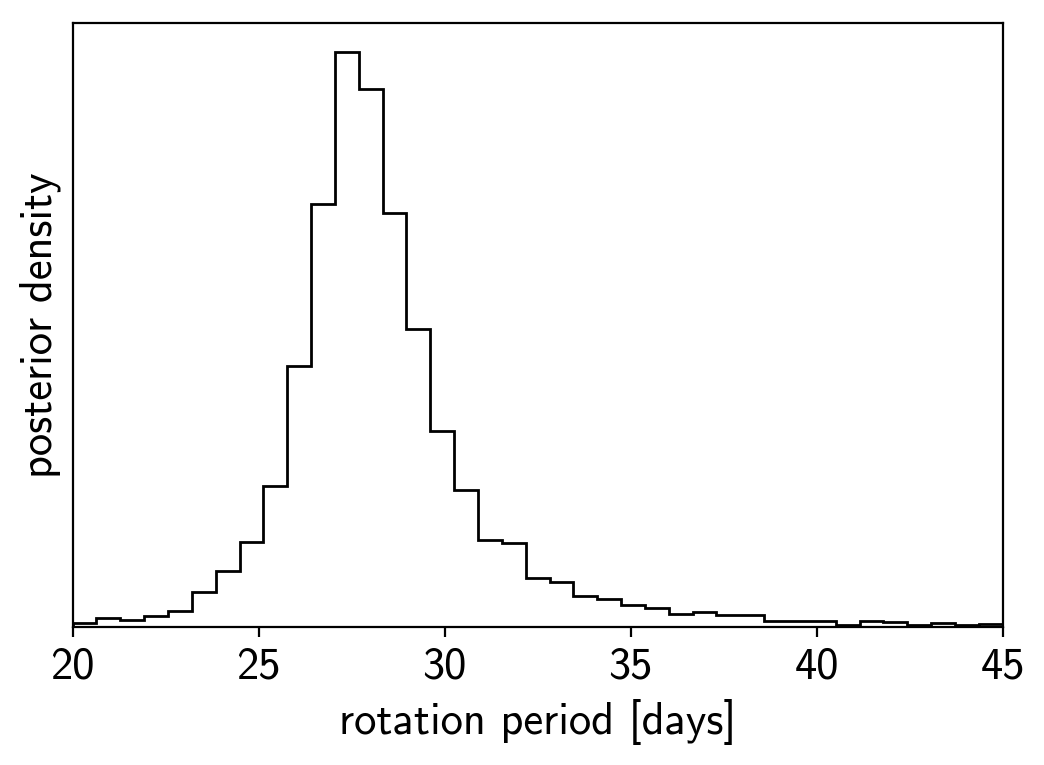

In [9]:
period_samples = trace["period"]
bins = np.linspace(20, 45, 40)
plt.hist(period_samples, bins, histtype="step", color="k")
plt.yticks([])
plt.xlim(bins.min(), bins.max())
plt.xlabel("rotation period [days]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [10]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:exoplanet, exoplanet:foremanmackey17,
exoplanet:foremanmackey18, exoplanet:pymc3, exoplanet:theano}.


In [11]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
...
